In [1]:
import matplotlib.pyplot  as plt
import imageio.v3 as iio
from model import ReLU , Sigmoid , Tanh , Identity , Linear  , Model , train_model,BCELoss,MSELoss
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np


baseline accuracy : 79.44 %


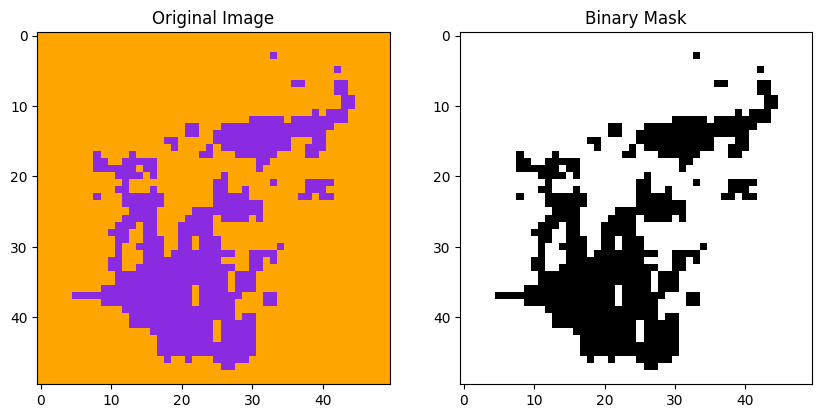

In [2]:
border_img = iio.imread("dataset/Q1/border.png")
# orange = [255,165,0]
# purple = [138  43 226]
def image_to_binary_mask(img:np.ndarray)->np.ndarray:
    """
    Convert the border image to a binary mask.
    Orange (Netherlands) -> 1
    Purple (Belgium) -> 0
    """

    # Correct RGB values
    orange = np.array([255, 165, 0])   # Netherlands
    purple = np.array([138, 43, 226])  # Belgium

    # Compute Euclidean distance to each color
    dist_orange = np.linalg.norm(img - orange, axis=-1)
    dist_purple = np.linalg.norm(img - purple, axis=-1)

    # Assign label 1 for closer to orange, else 0
    mask = (dist_orange < dist_purple).astype(np.uint8)

    return mask
mask = image_to_binary_mask(border_img)
baseline = (np.sum(mask) /( mask.shape[0]*mask.shape[1]))

print(f"baseline accuracy : {baseline*100} %")

fig , axes = plt.subplots(1,2,figsize=(10,5))
axes[0].imshow(border_img)
axes[0].set_title("Original Image")
axes[1].imshow(mask,cmap='gray')
axes[1].set_title("Binary Mask")
plt.show()

In [3]:
class BorderDataset:
    """
    Dataset class for the Belgium-Netherlands border classification task.
    Returns pixels with normalized coordinates and corresponding labels.
    """
    def __init__(self, binary_mask):
        """
        Initialize the dataset with the binary mask.
        """
        self.binary_mask = binary_mask
        self.height, self.width = binary_mask.shape
        # Create coordinate arrays
        y_coords, x_coords = np.indices((self.height, self.width))
        # Normalize to [0, 1]
        self.x_normalized = x_coords.flatten() / (self.width - 1)
        self.y_normalized = y_coords.flatten() / (self.height - 1)
        self.labels = binary_mask.flatten()
        # Create indices for shuffling
        self.indices = np.arange(len(self.labels))
    
    def shuffle(self):
        """Shuffle the dataset order."""
        # Set seed for reproducible shuffling
        np.random.seed(42)
        np.random.shuffle(self.indices)
        
    def get_all_samples(self):
        """
        Get all data points in shuffled order.
        """
        self.shuffle()
        coordinates = np.column_stack([
            self.x_normalized[self.indices], 
            self.y_normalized[self.indices]
        ])
        labels = self.labels[self.indices]
        return coordinates, labels
    
    def reconstruct_image_from_predictions(self, shuffled_predictions):
        """
        Reconstruct image from shuffled predictions by mapping them back to original positions.
        """
        # Create empty array for reconstructed image
        reconstructed = np.zeros(self.height * self.width)
        
        # Map shuffled predictions back to original positions
        reconstructed[self.indices] = shuffled_predictions.flatten()
        
        # Reshape to original image dimensions
        return reconstructed.reshape(self.height, self.width)
    
dataset = BorderDataset(mask)

# Map Prediction and Analysis

In [4]:
def run_model_on_border(layers , loss_fn , learning_rate=0.01 , max_epochs=1000 , mask=mask , batch_size=4 ,patience=100,run_name="sample_run",save_model=True,rel_loss_threshold=1e-6,learning_rate_=0.01,grad_step=1):
    """
    Create and train the model with given layers and loss function.
    """
    for layer in layers:
        layer.learning_rate = learning_rate
        
    model = Model(layers, loss_fn)
    print(f"Model created with {model.get_parameter_count()} parameters.")
    dataset = BorderDataset(mask)

    results = train_model(
        model=model,
        dataset=dataset,
        batch_size=batch_size,
        max_epochs=max_epochs,
        patience=patience,
        save_model=save_model,
        run_name=run_name,
        relative_loss_threshold=rel_loss_threshold,
        use_wandb=False,
        grad_accumulation_steps=grad_step
    )

    X,Y = dataset.get_all_samples()
    predictions = model.predict(X)
    threshold = 0.5  
    predicted_labels = (predictions > threshold).astype(int).flatten()

    true_labels = Y.flatten()

    # the ground truth map
    true_map = dataset.reconstruct_image_from_predictions(true_labels)

    # map generated from model predictions
    pred_map = dataset.reconstruct_image_from_predictions(predicted_labels)

    error_map = dataset.reconstruct_image_from_predictions((true_labels != predicted_labels).astype(int))

    # Error map
    height, width = dataset.height, dataset.width
    error_overlay = np.zeros((height, width, 3))
    error_overlay[:,:,0] = true_map  # Red channel = ground truth
    error_overlay[:,:,1] = true_map  # Green channel = ground truth  
    error_overlay[:,:,2] = true_map  # Blue channel = ground truth
    

    
    # Highlight errors in bright red
    error_overlay[error_map == 1] = [1, 0, 0]  # Bright red for errors

    check = (true_map == pred_map).astype(int)
    accuracy = np.sum(check) / check.size
    print(f"Model accuracy: {accuracy * 100:.2f}%")

    fig , axes = plt.subplots(1,3,figsize=(10,5))
    axes[0].imshow(true_map)     
    axes[0].set_title("True Labels")    
    axes[1].imshow(pred_map,cmap='gray')
    axes[1].set_title("Predicted Labels")
    axes[2].imshow(error_overlay)
    axes[2].set_title("Error Map")
    plt.show()
    # save the following images side-by-side in a single plot within the run folder
    fig.savefig(f"runs/{run_name}/results.png")

    return {
        "accuracy": accuracy,
        "final_loss": results['final_loss'],
        "samples_seen" :results['samples_seen'],
    }

In [5]:

test_architectures = [
    ([Linear(2, 16, ReLU()), Linear(16, 1, Sigmoid())], BCELoss()),
    ([Linear(2, 8, ReLU()),Linear(8, 8, ReLU()),Linear(8, 8, ReLU()), Linear(8, 1, Sigmoid())], MSELoss()),
    ([Linear(2, 16, ReLU()), Linear(16, 1, Tanh())], BCELoss()),
    ([Linear(2, 8, Identity()),Linear(8, 8, ReLU()),Linear(8, 8, ReLU()), Linear(8, 1, Tanh())], MSELoss()),
]

Running architecture 1/4
Model created with 65 parameters.
Starting training: border/architecture_1
Early stopping at epoch 3358
Training completed: 3359 epochs, 8397500 samples
Final loss: 0.269903


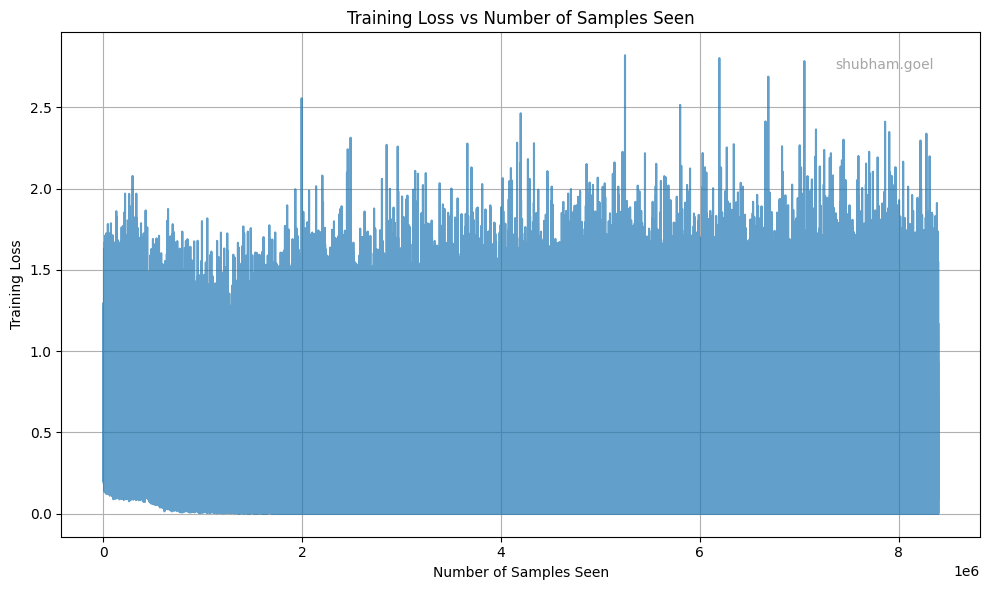

Results saved to runs/border/architecture_1/
Model accuracy: 85.68%


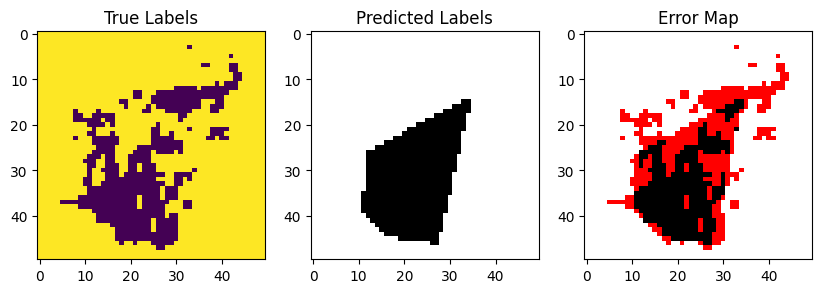

Running architecture 2/4
Model created with 177 parameters.
Starting training: border/architecture_2
Early stopping at epoch 2179
Training completed: 2180 epochs, 5450000 samples
Final loss: 0.040598


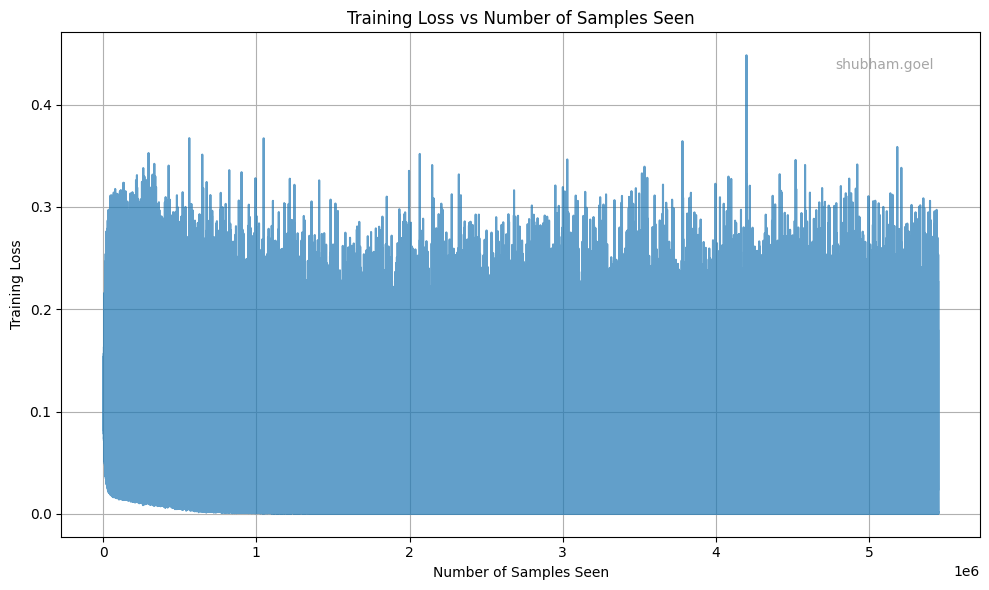

Results saved to runs/border/architecture_2/
Model accuracy: 88.64%


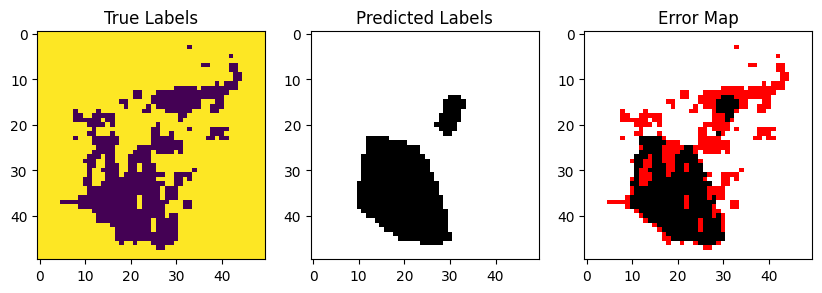

Running architecture 3/4
Model created with 65 parameters.
Starting training: border/architecture_3
Early stopping at epoch 501
Training completed: 502 epochs, 1255000 samples
Final loss: 7.101337


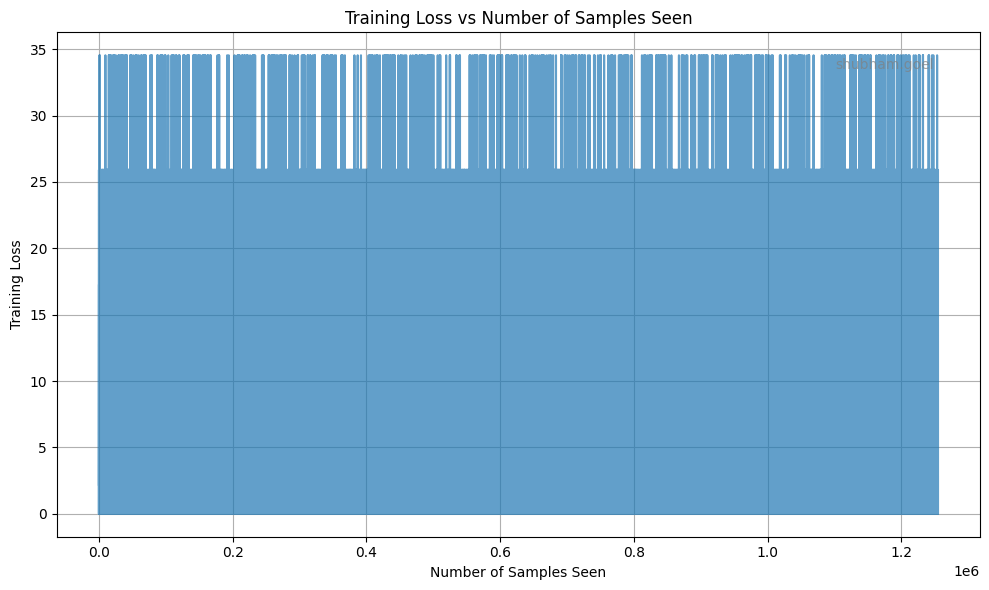

Results saved to runs/border/architecture_3/
Model accuracy: 79.44%


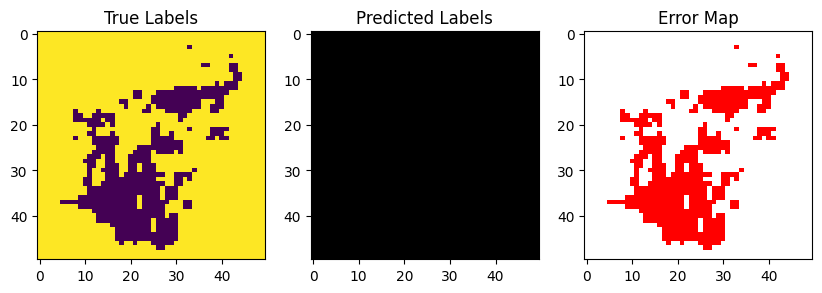

Running architecture 4/4
Model created with 177 parameters.
Starting training: border/architecture_4
Early stopping at epoch 3215
Training completed: 3216 epochs, 8040000 samples
Final loss: 0.031784


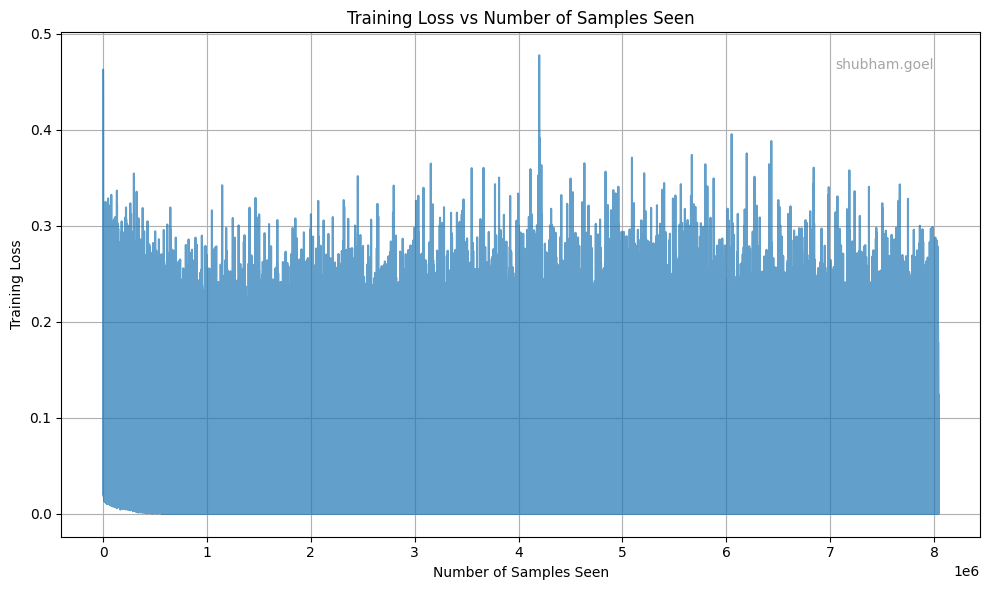

Results saved to runs/border/architecture_4/
Model accuracy: 91.36%


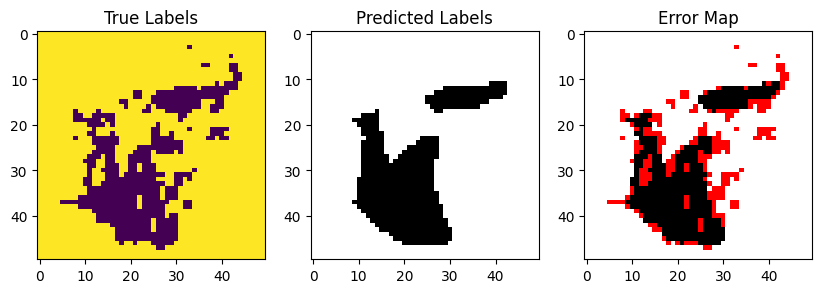

In [6]:
for i , (layers , loss_fn) in enumerate(test_architectures):
    print(f"Running architecture {i+1}/{len(test_architectures)}")

    result = run_model_on_border(
        layers=layers,
        loss_fn=loss_fn,
        learning_rate=0.01,
        max_epochs=10000,
        mask=mask,
        batch_size=4,
        patience=500,
        rel_loss_threshold=1e-6,
        run_name=f"border/architecture_{i+1}",
        save_model=True
    )
    # print(f"train_loss: {result['final_loss']}, accuracy: {result['accuracy']*100:.2f}%")

##  Experimentation with Architecture:

### For a fixed layer width, vary the number of layers. Plot the final loss and accuracy as a function of depth.

Running architecture with 1 hidden layers
Model created with 33 parameters.
Starting training: border/hidden_layers_1
Early stopping at epoch 2179
Training completed: 2180 epochs, 5450000 samples
Final loss: 0.289007


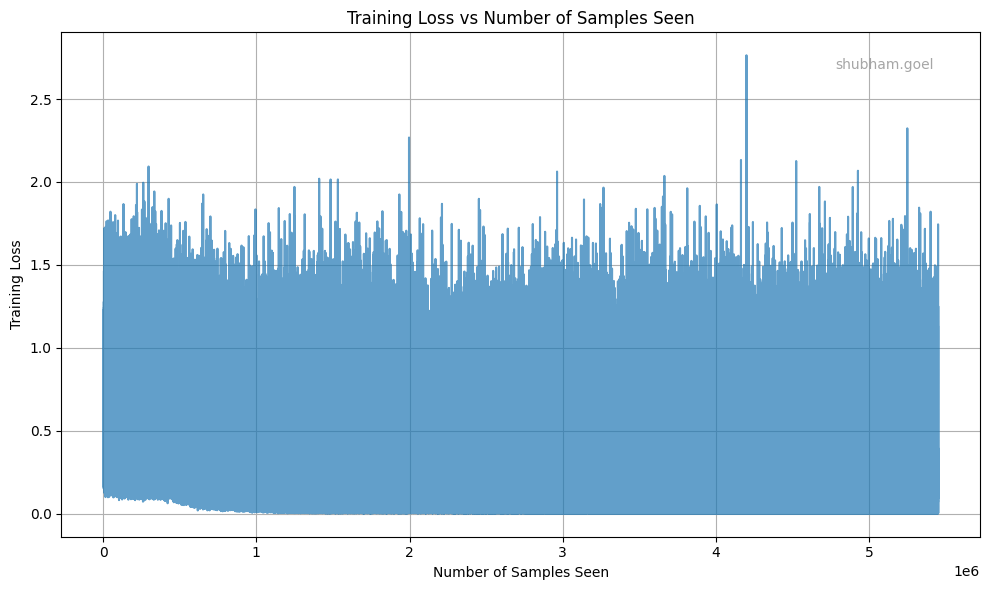

Results saved to runs/border/hidden_layers_1/
Model accuracy: 85.56%


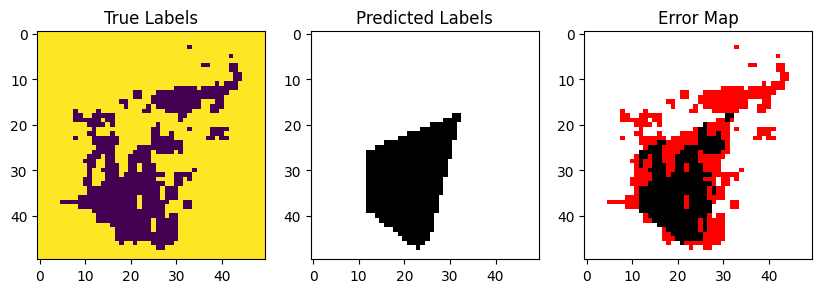

Running architecture with 2 hidden layers
Model created with 105 parameters.
Starting training: border/hidden_layers_2
Early stopping at epoch 1807
Training completed: 1808 epochs, 4520000 samples
Final loss: 0.226801


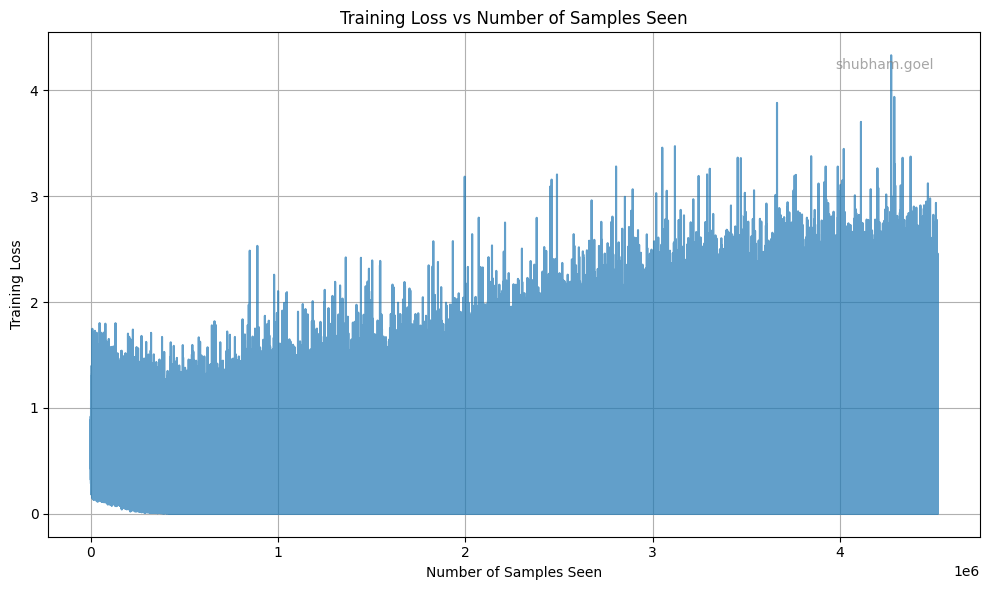

Results saved to runs/border/hidden_layers_2/
Model accuracy: 90.76%


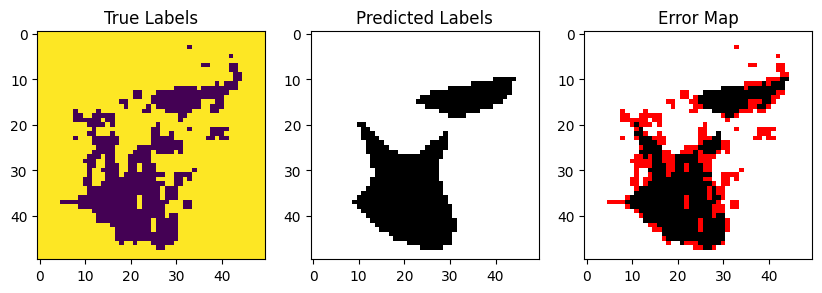

Running architecture with 3 hidden layers
Model created with 177 parameters.
Starting training: border/hidden_layers_3
Early stopping at epoch 1251
Training completed: 1252 epochs, 3130000 samples
Final loss: 0.234166


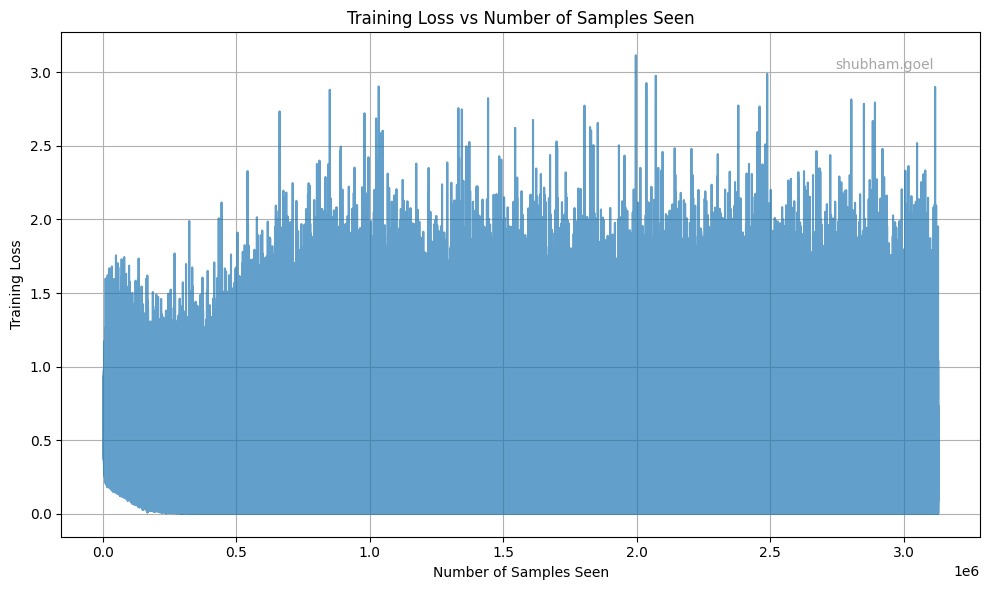

Results saved to runs/border/hidden_layers_3/
Model accuracy: 89.04%


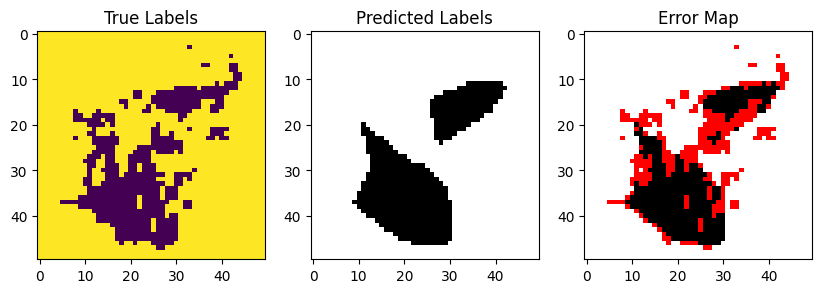

Running architecture with 4 hidden layers
Model created with 249 parameters.
Starting training: border/hidden_layers_4
Early stopping at epoch 2119
Training completed: 2120 epochs, 5300000 samples
Final loss: 0.194813


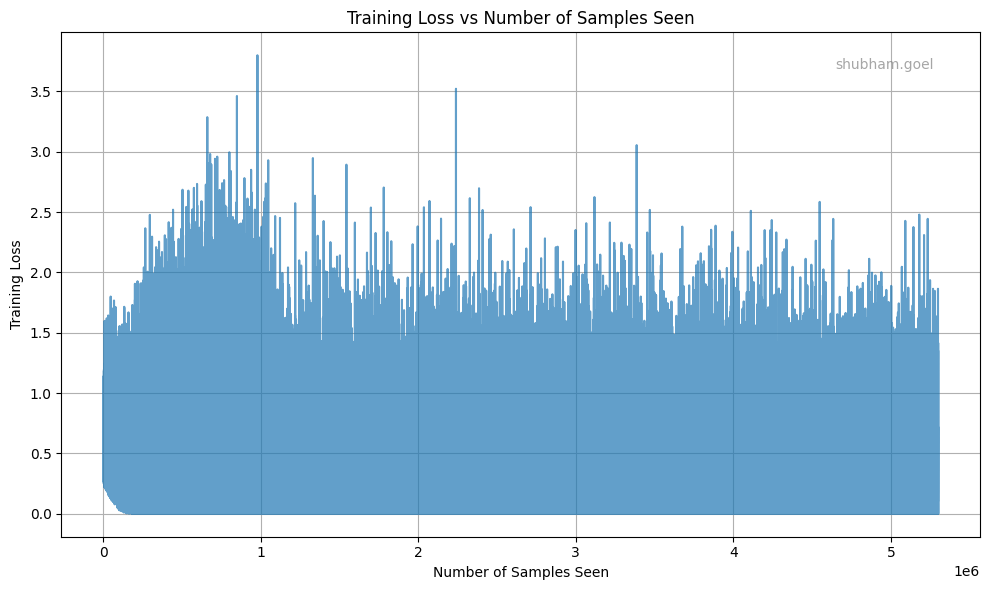

Results saved to runs/border/hidden_layers_4/
Model accuracy: 91.56%


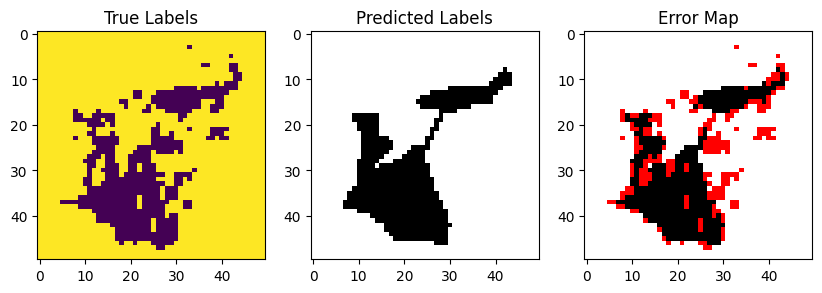

Running architecture with 5 hidden layers
Model created with 321 parameters.
Starting training: border/hidden_layers_5
Early stopping at epoch 1575
Training completed: 1576 epochs, 3940000 samples
Final loss: 0.228619


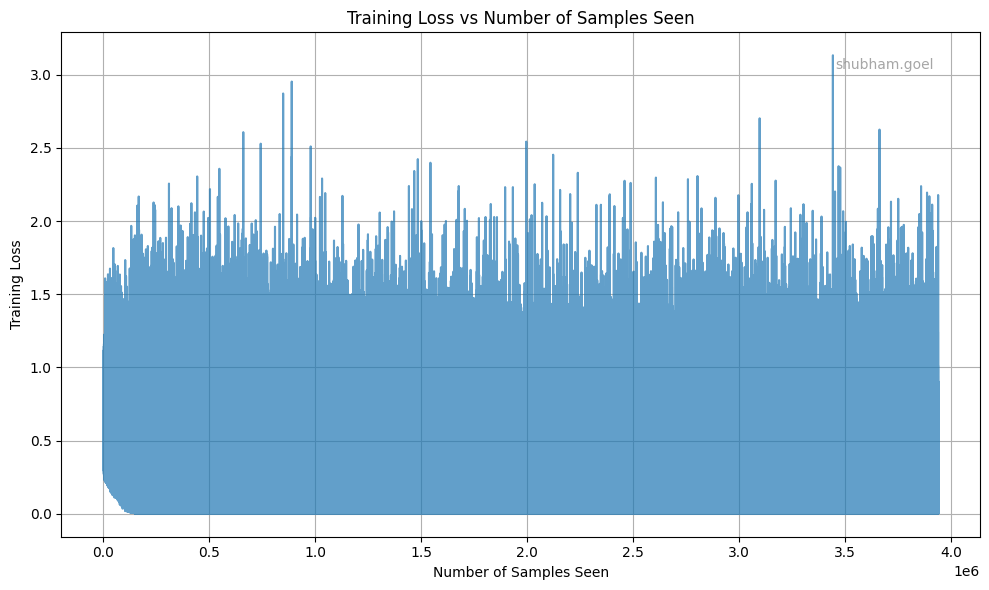

Results saved to runs/border/hidden_layers_5/
Model accuracy: 90.28%


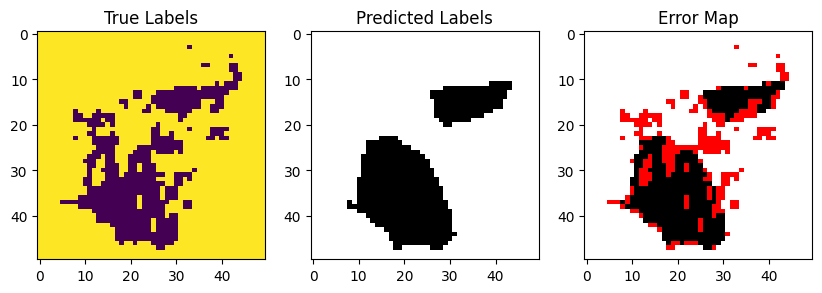

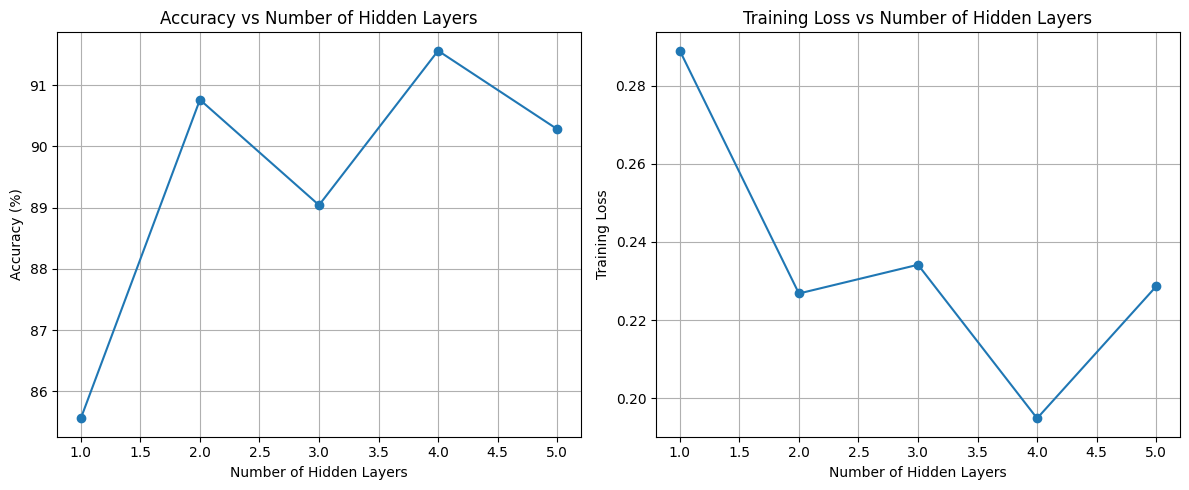

In [8]:
HIDDEN_SIZE = 8
OUTPUT_SIZE = 1
MAX_NUM_OF_HIDDEN_LAYERS = 5

accuracy_results = []
train_losses = []
for i in range(1, MAX_NUM_OF_HIDDEN_LAYERS + 1):
    layers = []
    # Input layer
    layers.append(Linear(input_size=2, output_size=HIDDEN_SIZE, activation_function=ReLU(), learning_rate=0.01))
    
    # Hidden layers
    for _ in range(i - 1):
        layers.append(Linear(input_size=HIDDEN_SIZE, output_size=HIDDEN_SIZE, activation_function=ReLU(), learning_rate=0.01))
    
    # Output layer
    layers.append(Linear(input_size=HIDDEN_SIZE, output_size=OUTPUT_SIZE, activation_function=Sigmoid(), learning_rate=0.01))
    
    print(f"Running architecture with {i} hidden layers")
    
    result = run_model_on_border(
        layers=layers,
        loss_fn=BCELoss(),
        learning_rate=0.01,
        max_epochs=10000,
        mask=mask,
        batch_size=4,
        patience=500,
        rel_loss_threshold=1e-6,
        run_name=f"border/hidden_layers_{i}",
        save_model=True
    )

    accuracy_results.append(result['accuracy'] * 100)
    train_losses.append(result['final_loss'])

# Plotting accuracy and training loss vs number of hidden layers
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, MAX_NUM_OF_HIDDEN_LAYERS + 1), accuracy_results, marker='o')
plt.title("Accuracy vs Number of Hidden Layers")
plt.xlabel("Number of Hidden Layers")
plt.ylabel("Accuracy (%)")
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(1, MAX_NUM_OF_HIDDEN_LAYERS + 1), train_losses, marker='o')
plt.title("Training Loss vs Number of Hidden Layers")
plt.xlabel("Number of Hidden Layers")
plt.ylabel("Training Loss")
plt.grid()

plt.tight_layout()
plt.show()

### For a fixed number of layers, vary the width of the layers. Plot the final loss and accuracy as a function of width.

Running architecture with width 1
Model created with 7 parameters.
Starting training: border/width_1
Early stopping at epoch 607
Training completed: 608 epochs, 1520000 samples
Final loss: 0.485707


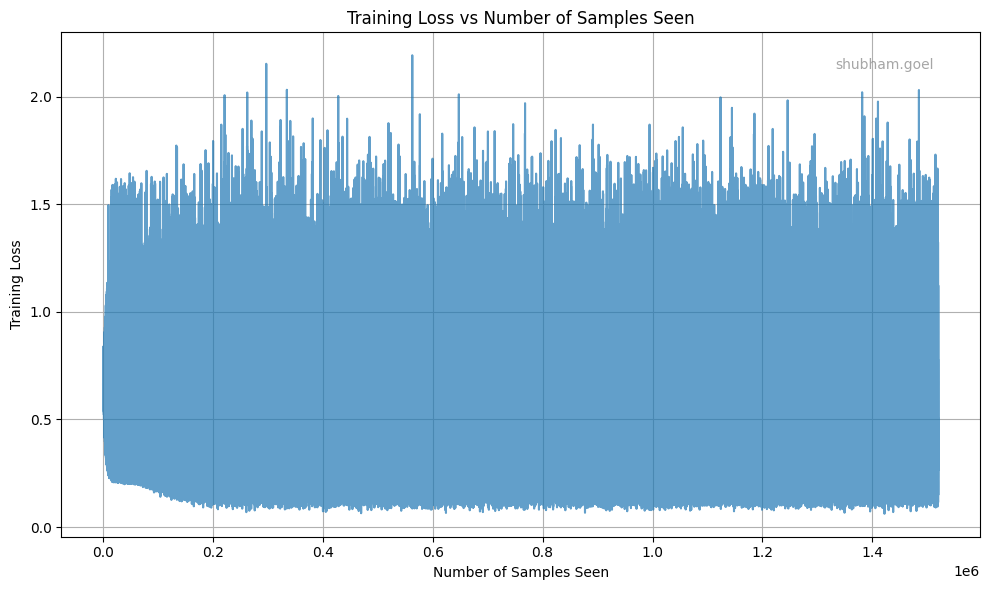

Results saved to runs/border/width_1/
Model accuracy: 79.44%


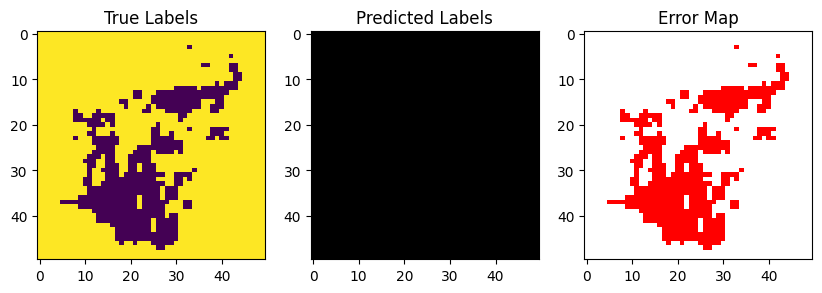

Running architecture with width 4
Model created with 37 parameters.
Starting training: border/width_4
Early stopping at epoch 1422
Training completed: 1423 epochs, 3557500 samples
Final loss: 0.277156


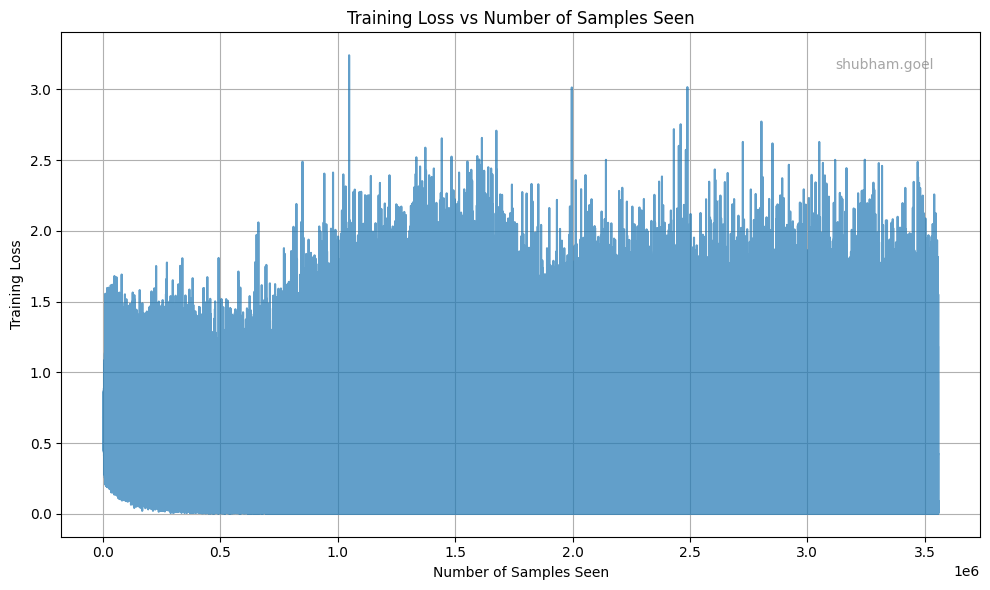

Results saved to runs/border/width_4/
Model accuracy: 86.96%


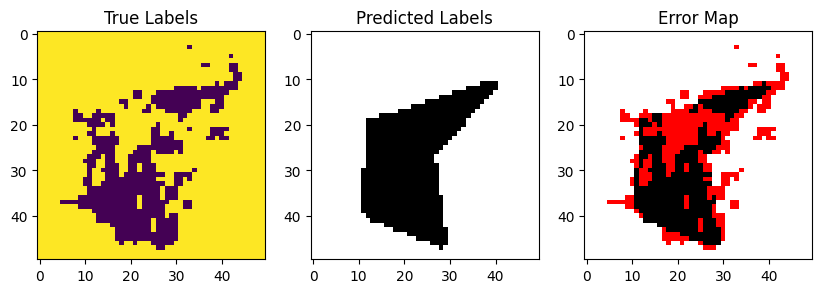

Running architecture with width 7
Model created with 85 parameters.
Starting training: border/width_7
Early stopping at epoch 1271
Training completed: 1272 epochs, 3180000 samples
Final loss: 0.276545


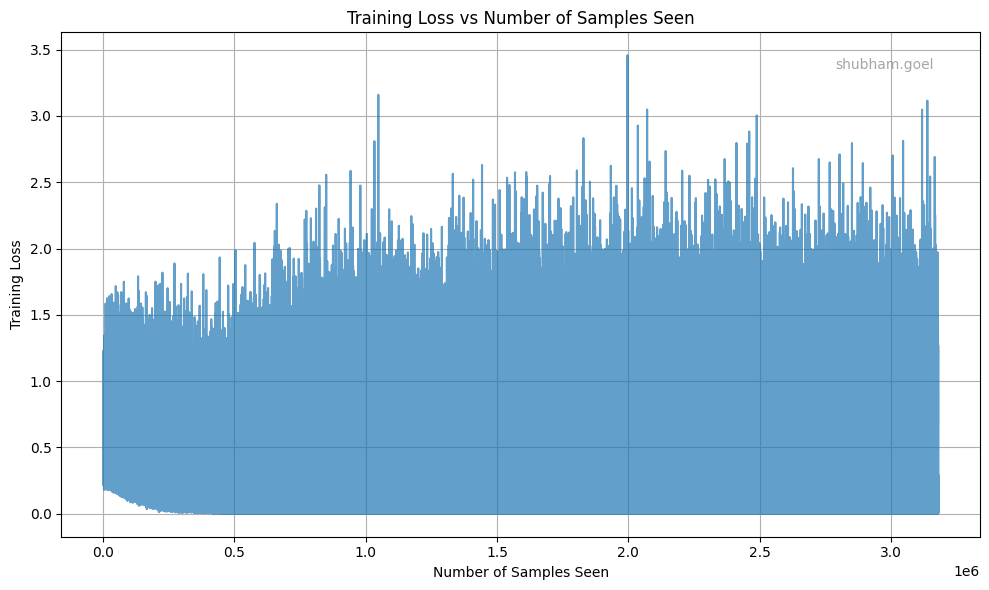

Results saved to runs/border/width_7/
Model accuracy: 86.08%


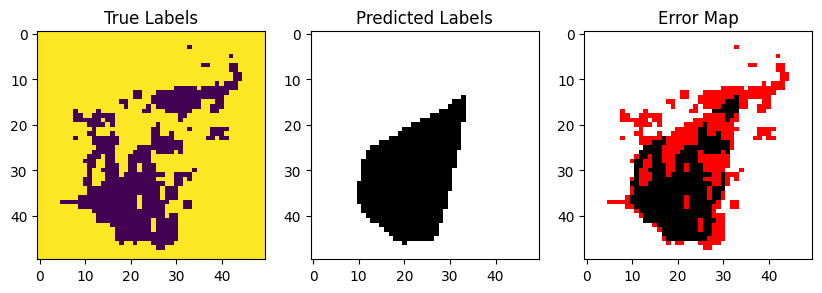

Running architecture with width 10
Model created with 151 parameters.
Starting training: border/width_10
Early stopping at epoch 1284
Training completed: 1285 epochs, 3212500 samples
Final loss: 0.238886


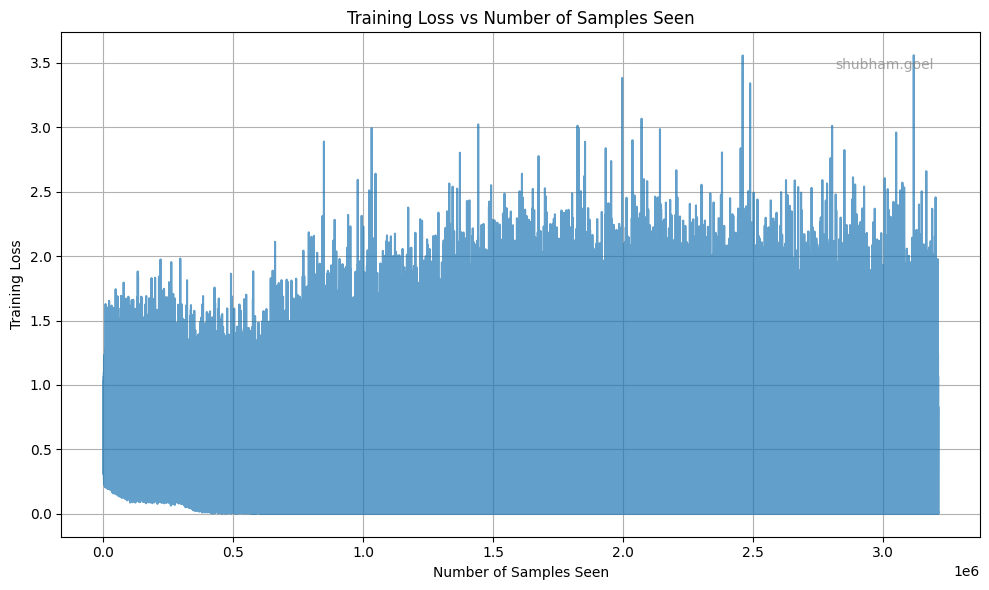

Results saved to runs/border/width_10/
Model accuracy: 90.20%


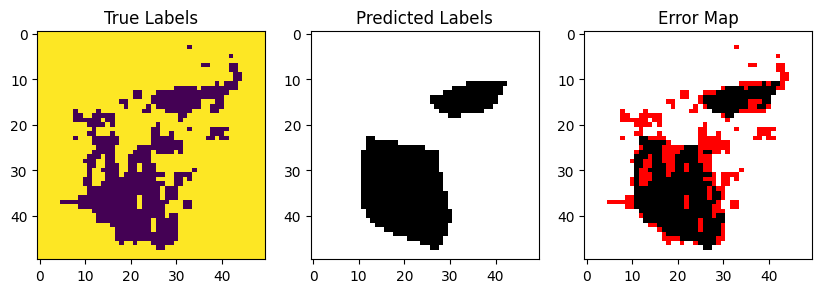

Running architecture with width 13
Model created with 235 parameters.
Starting training: border/width_13
Early stopping at epoch 2126
Training completed: 2127 epochs, 5317500 samples
Final loss: 0.217301


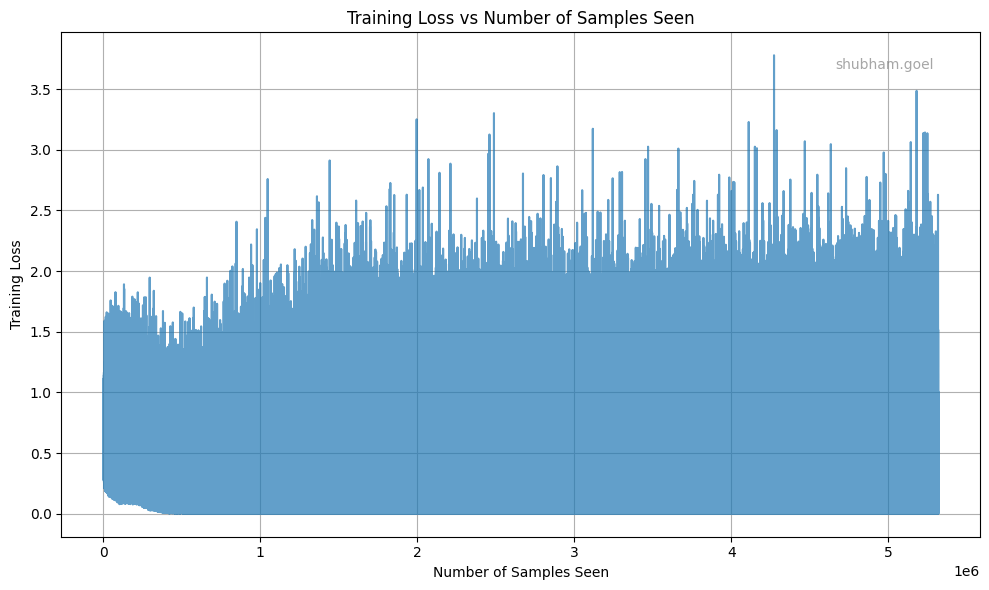

Results saved to runs/border/width_13/
Model accuracy: 91.24%


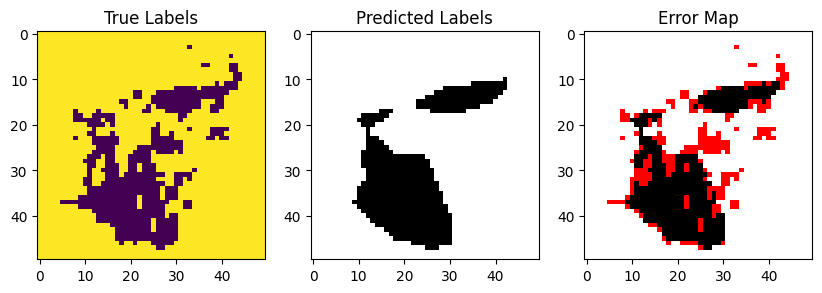

Running architecture with width 16
Model created with 337 parameters.
Starting training: border/width_16
Early stopping at epoch 2867
Training completed: 2868 epochs, 7170000 samples
Final loss: 0.204200


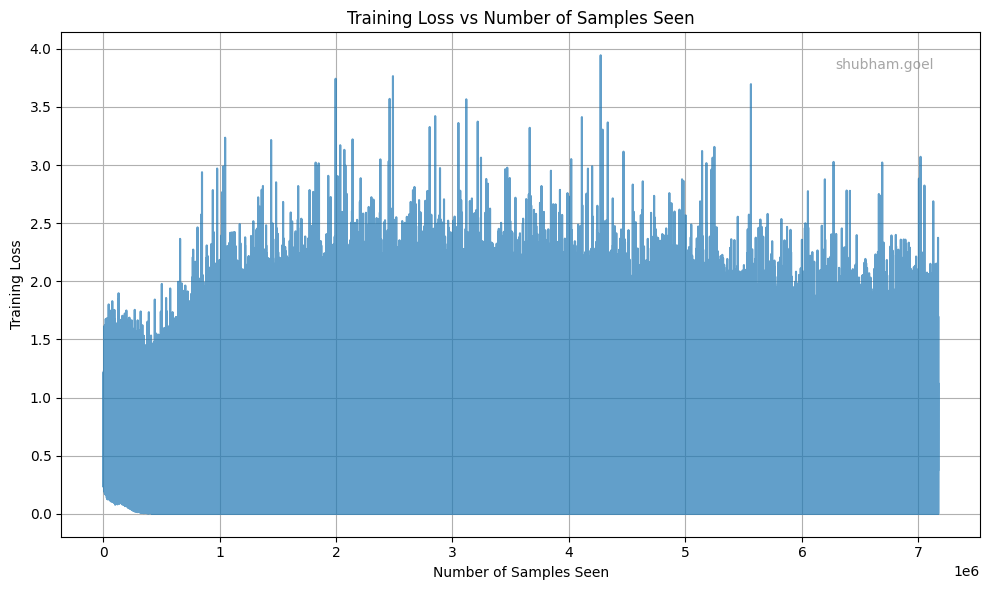

Results saved to runs/border/width_16/
Model accuracy: 91.64%


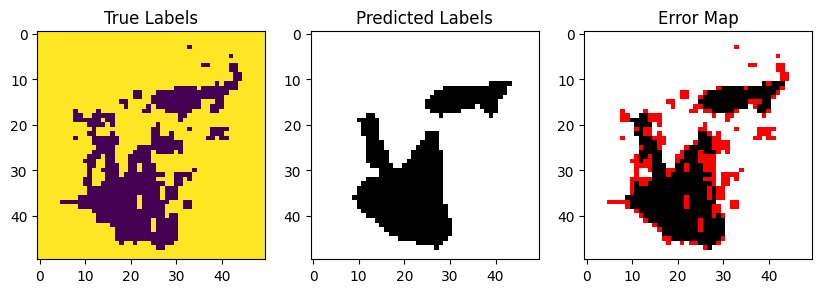

Running architecture with width 19
Model created with 457 parameters.
Starting training: border/width_19
Early stopping at epoch 2126
Training completed: 2127 epochs, 5317500 samples
Final loss: 0.214312


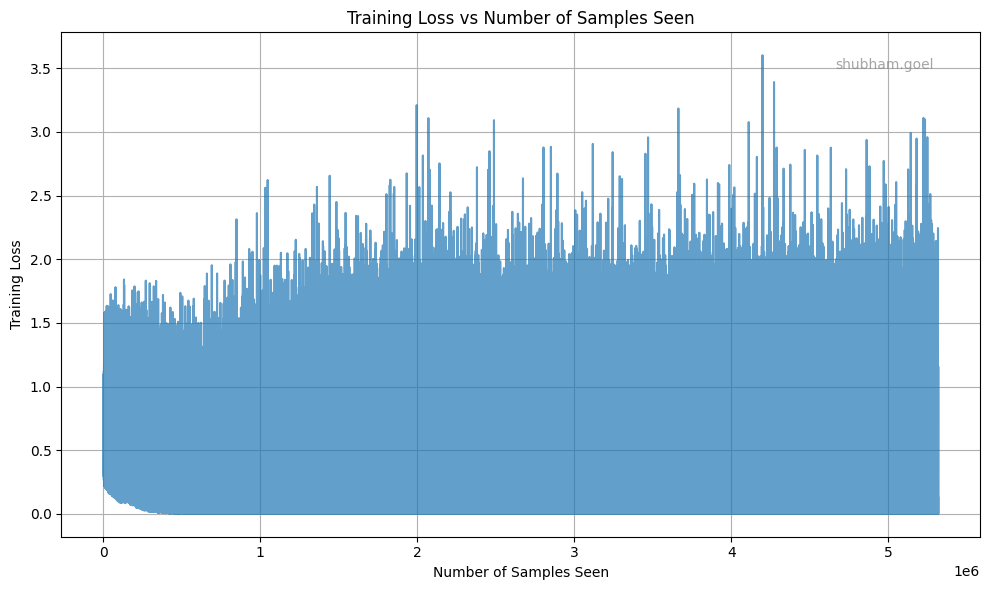

Results saved to runs/border/width_19/
Model accuracy: 91.08%


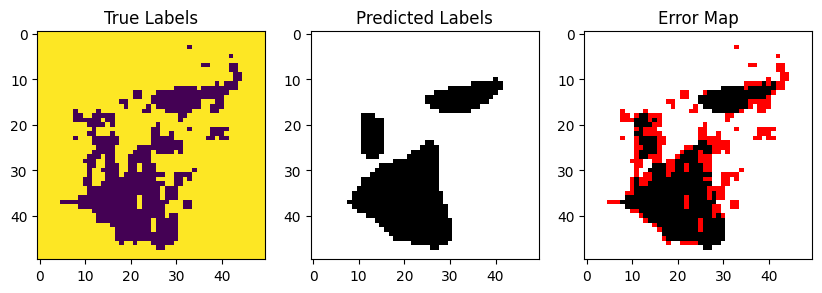

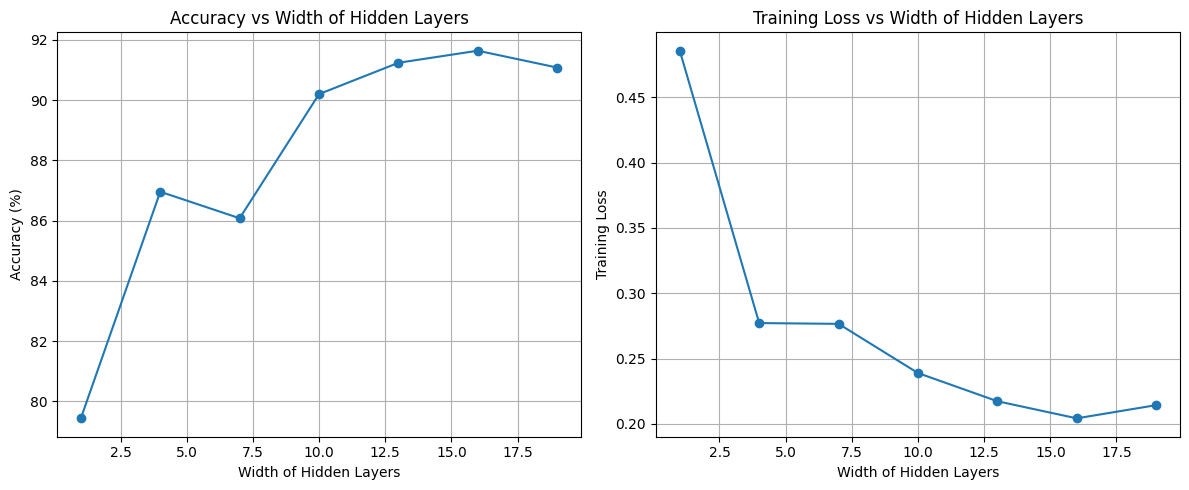

In [ ]:
MAX_NUM_OF_HIDDEN_LAYERS = 2
MAX_WIDTH = 20
HIDDEN_SIZE = 8
OUTPUT_SIZE = 1

accuracy_results = []
train_losses = []

for width in range(1, MAX_WIDTH + 1, 3):
    layers = []
    # Input layer
    layers.append(Linear(input_size=2, output_size=width, activation_function=ReLU(), learning_rate=0.01))
    
    # Hidden layers
    for _ in range(MAX_NUM_OF_HIDDEN_LAYERS - 1):
        layers.append(Linear(input_size=width, output_size=width, activation_function=ReLU(), learning_rate=0.01))
    
    # Output layer
    layers.append(Linear(input_size=width, output_size=OUTPUT_SIZE, activation_function=Sigmoid(), learning_rate=0.01))
    
    print(f"Running architecture with width {width}")
    
    result = run_model_on_border(
        layers=layers,
        loss_fn=BCELoss(),
        learning_rate=0.01,
        max_epochs=10000,
        mask=mask,
        batch_size=4,
        patience=500,
        rel_loss_threshold=1e-6,
        run_name=f"border/width_{width}",
        save_model=True
    )

    accuracy_results.append(result['accuracy'] * 100)
    train_losses.append(result['final_loss'])

# Plotting accuracy and training loss vs width of hidden layers
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, MAX_WIDTH + 1, 3), accuracy_results, marker='o')
plt.title("Accuracy vs Width of Hidden Layers")
plt.xlabel("Width of Hidden Layers")
plt.ylabel("Accuracy (%)")
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(1, MAX_WIDTH + 1, 3), train_losses, marker='o')
plt.title("Training Loss vs Width of Hidden Layers")
plt.xlabel("Width of Hidden Layers")
plt.ylabel("Training Loss")
plt.grid()

plt.tight_layout()
plt.show()


### Experimentation with Hyperparameters:

* Train with a variety of batch size, grad accumulation steps, and learning
rates.
* Provide a comparison of the time taken to converge and the total number of
samples needed to converge for different hyperparameter settings.

Running with batch size 4 and grad accumulation 1 and learning rate 0.01
Model created with 105 parameters.
Starting training: border/batch_4_gradacc_1
Early stopping at epoch 1807
Training completed: 1808 epochs, 4520000 samples
Final loss: 0.226801


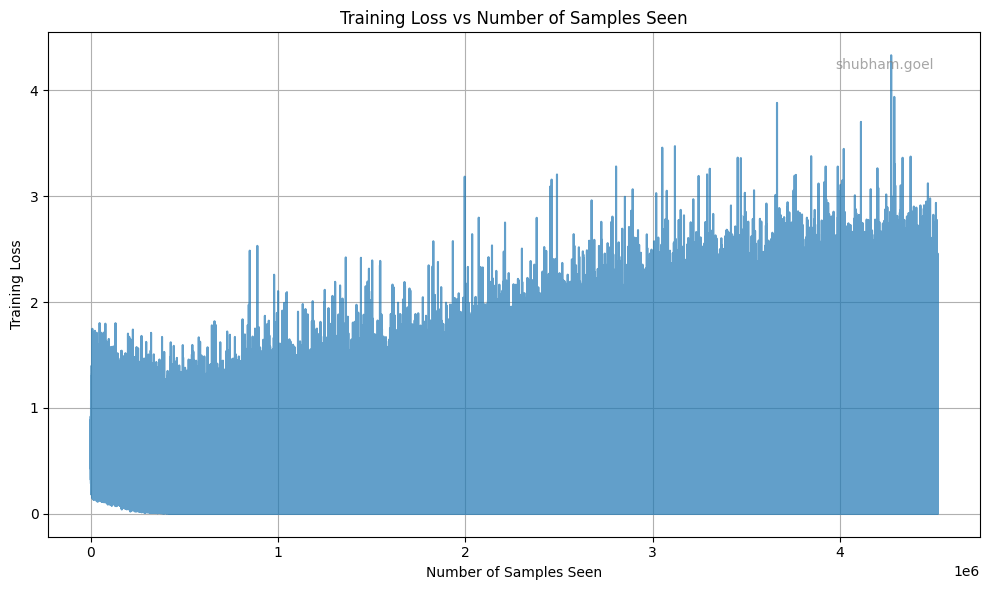

Results saved to runs/border/batch_4_gradacc_1/
Model accuracy: 90.76%


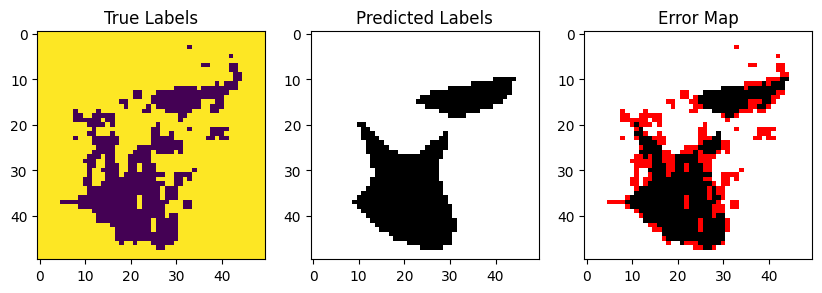

Time taken: 137.78 seconds
train_loss: 0.22680081186202583, accuracy: 90.76%
Running with batch size 4 and grad accumulation 1 and learning rate 0.1
Model created with 105 parameters.
Starting training: border/batch_4_gradacc_1
Early stopping at epoch 828
Training completed: 829 epochs, 2072500 samples
Final loss: 0.228622


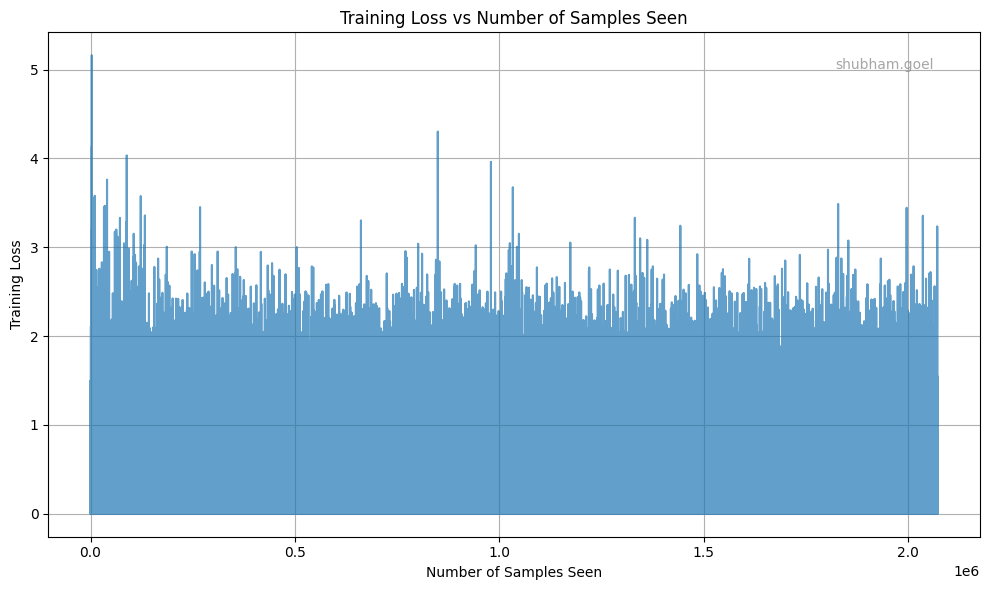

Results saved to runs/border/batch_4_gradacc_1/
Model accuracy: 90.92%


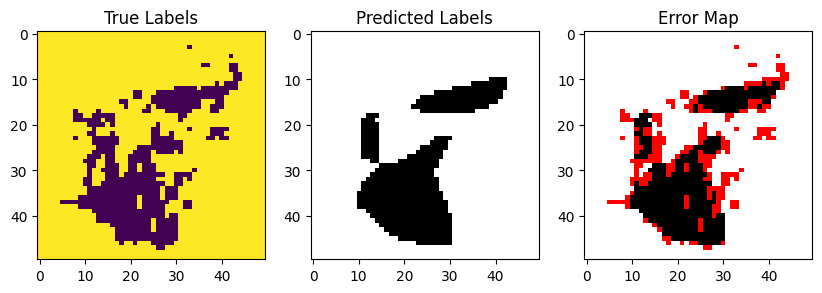

Time taken: 64.96 seconds
train_loss: 0.22862215391546234, accuracy: 90.92%
Running with batch size 4 and grad accumulation 1 and learning rate 0.5
Model created with 105 parameters.
Starting training: border/batch_4_gradacc_1
Early stopping at epoch 571
Training completed: 572 epochs, 1430000 samples
Final loss: 0.268718


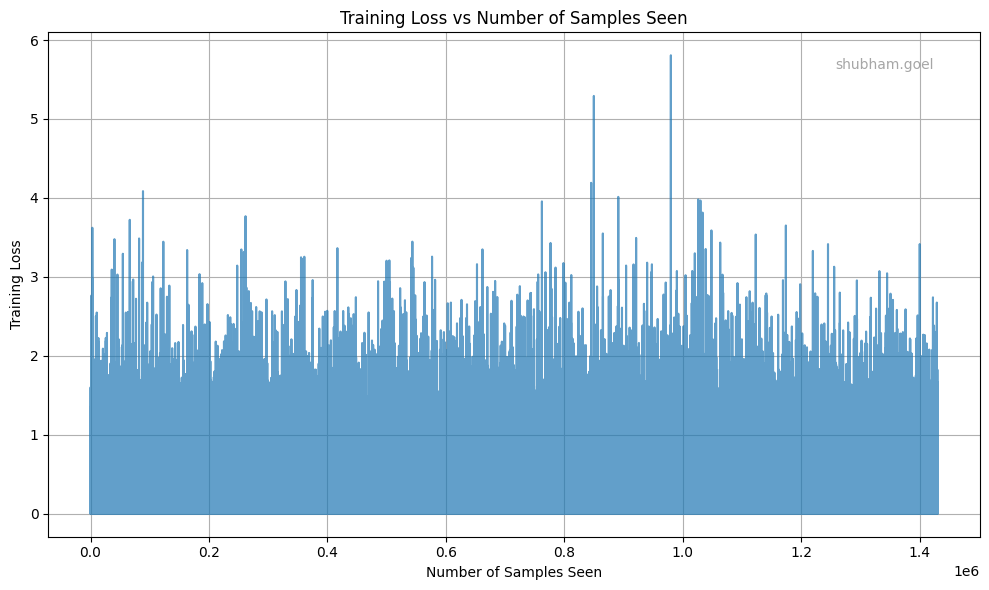

Results saved to runs/border/batch_4_gradacc_1/
Model accuracy: 89.60%


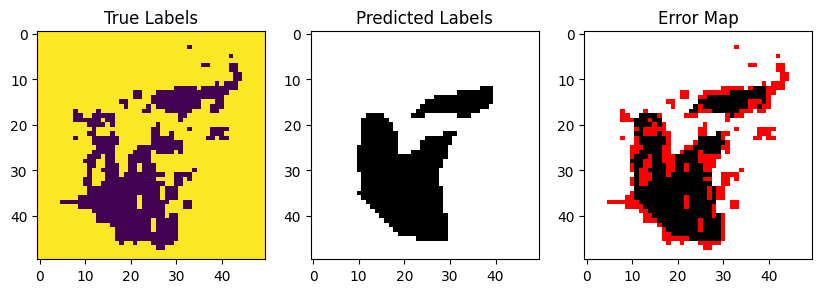

Time taken: 43.45 seconds
train_loss: 0.26871801740069756, accuracy: 89.60%
Running with batch size 4 and grad accumulation 2 and learning rate 0.01
Model created with 105 parameters.
Starting training: border/batch_4_gradacc_2
Early stopping at epoch 2515
Training completed: 2516 epochs, 6290000 samples
Final loss: 0.199947


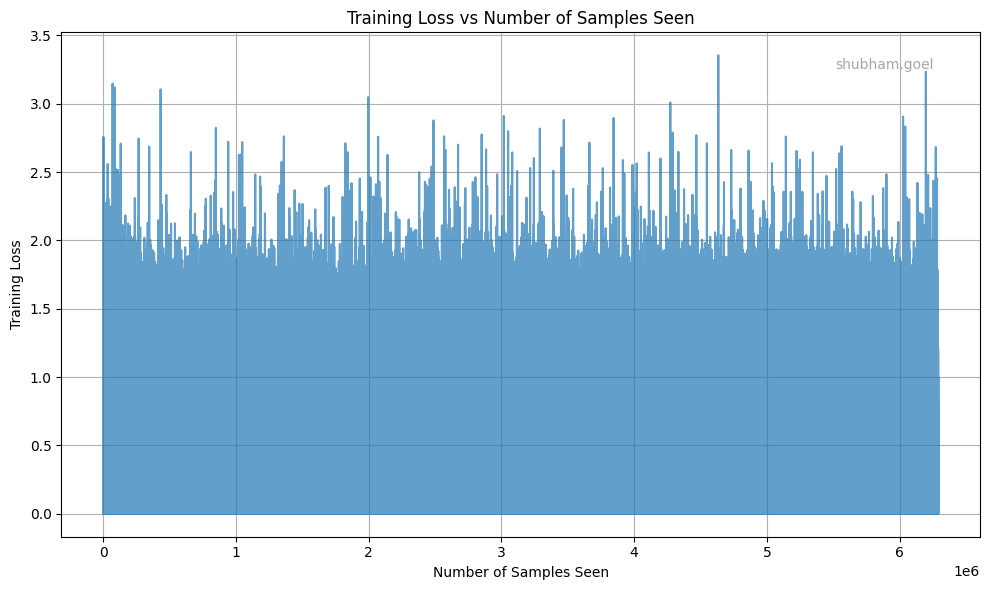

Results saved to runs/border/batch_4_gradacc_2/
Model accuracy: 91.72%


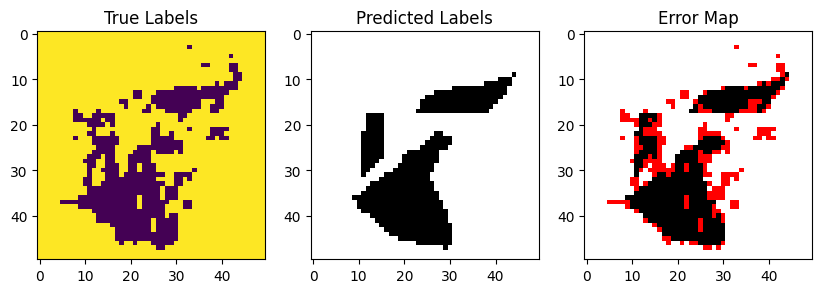

Time taken: 178.21 seconds
train_loss: 0.1999471197654259, accuracy: 91.72%
Running with batch size 4 and grad accumulation 2 and learning rate 0.1
Model created with 105 parameters.
Starting training: border/batch_4_gradacc_2
Early stopping at epoch 534
Training completed: 535 epochs, 1337500 samples
Final loss: 0.205098


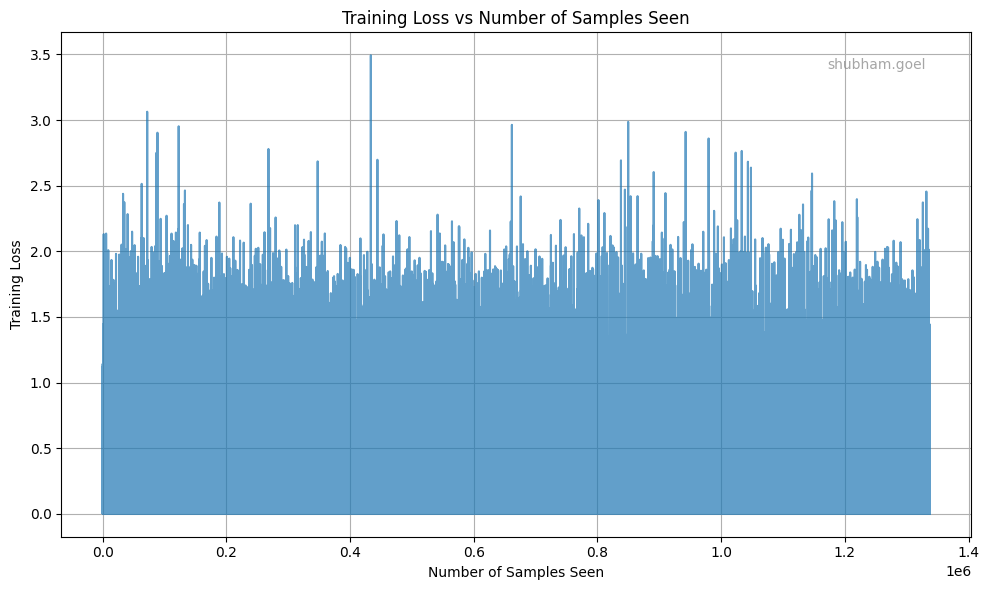

Results saved to runs/border/batch_4_gradacc_2/
Model accuracy: 91.96%


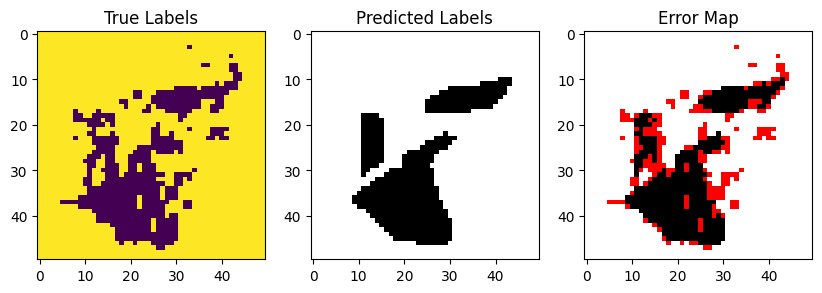

Time taken: 40.25 seconds
train_loss: 0.20509839514945608, accuracy: 91.96%
Running with batch size 4 and grad accumulation 2 and learning rate 0.5
Model created with 105 parameters.
Starting training: border/batch_4_gradacc_2
Early stopping at epoch 508
Training completed: 509 epochs, 1272500 samples
Final loss: 0.233691


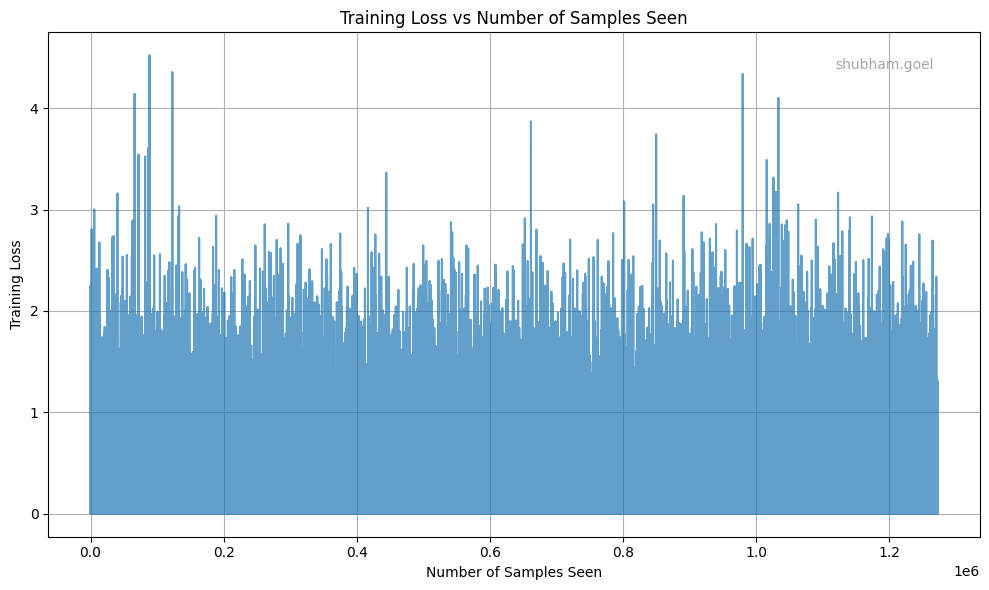

Results saved to runs/border/batch_4_gradacc_2/
Model accuracy: 91.20%


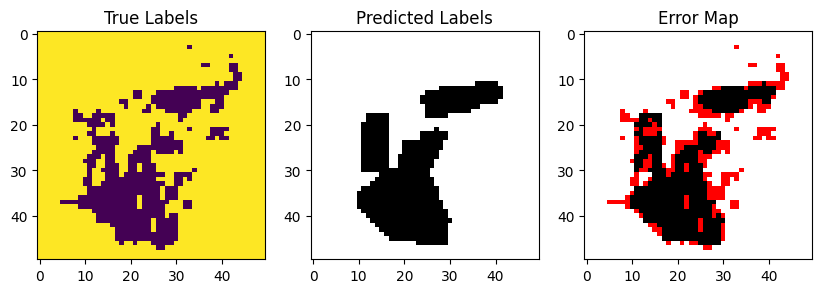

Time taken: 38.38 seconds
train_loss: 0.2336910427530842, accuracy: 91.20%
Running with batch size 4 and grad accumulation 4 and learning rate 0.01
Model created with 105 parameters.
Starting training: border/batch_4_gradacc_4
Early stopping at epoch 2478
Training completed: 2479 epochs, 6197500 samples
Final loss: 0.193051


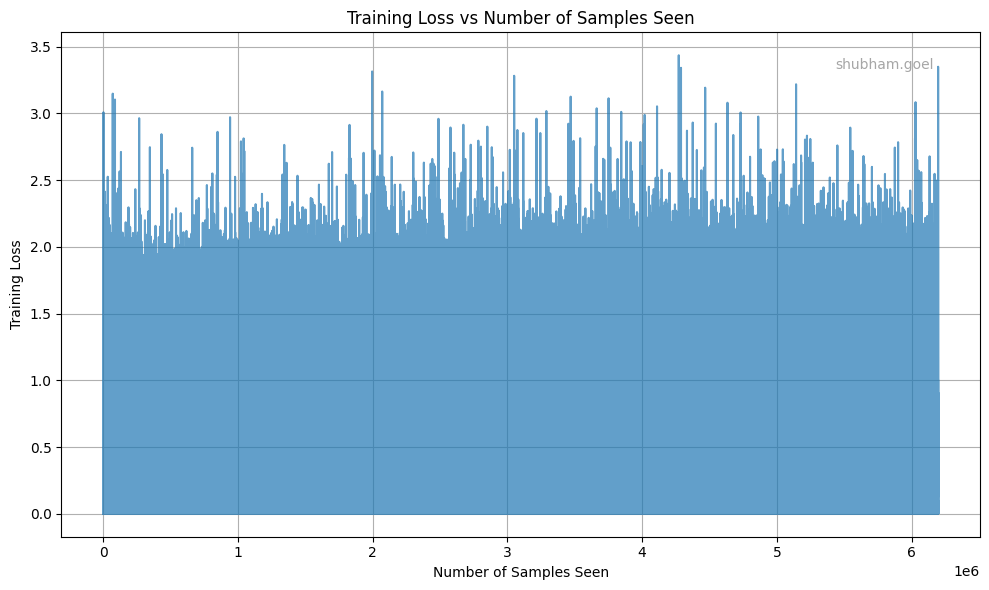

Results saved to runs/border/batch_4_gradacc_4/
Model accuracy: 91.68%


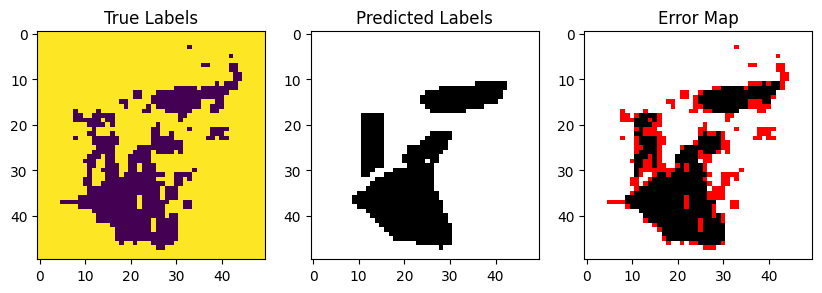

Time taken: 174.45 seconds
train_loss: 0.19305109519962754, accuracy: 91.68%
Running with batch size 4 and grad accumulation 4 and learning rate 0.1
Model created with 105 parameters.
Starting training: border/batch_4_gradacc_4
Early stopping at epoch 502
Training completed: 503 epochs, 1257500 samples
Final loss: 0.198049


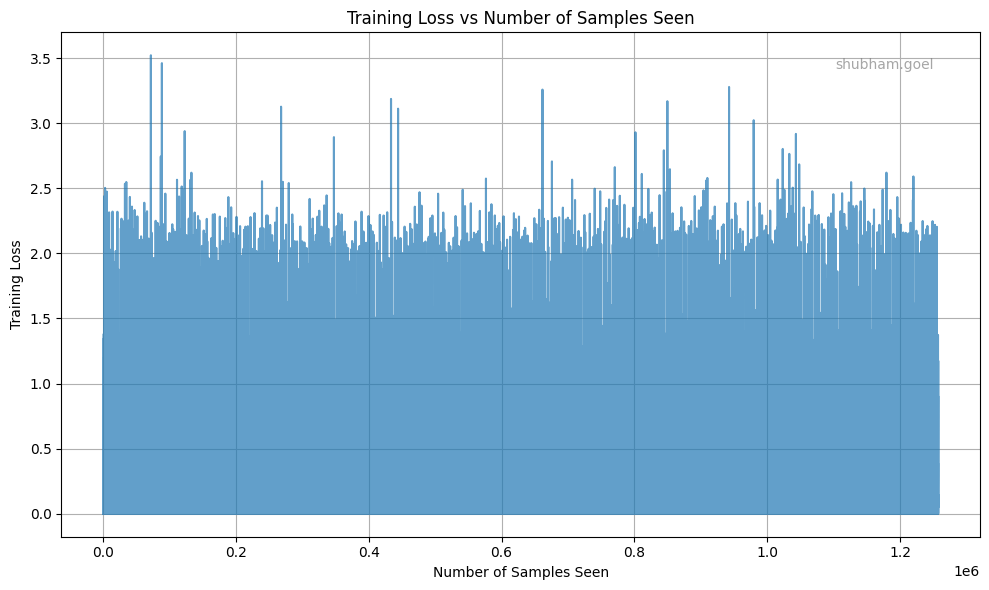

Results saved to runs/border/batch_4_gradacc_4/
Model accuracy: 91.76%


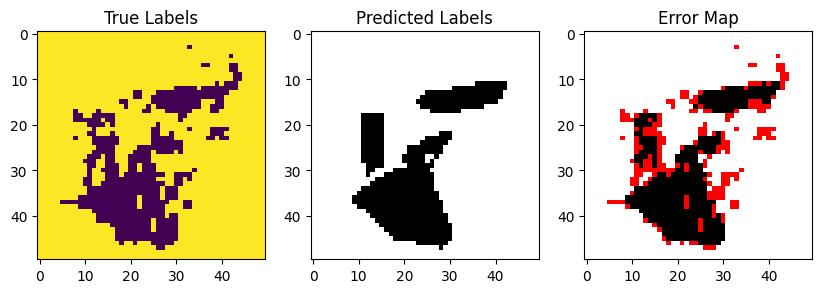

Time taken: 36.18 seconds
train_loss: 0.19804852348065102, accuracy: 91.76%
Running with batch size 4 and grad accumulation 4 and learning rate 0.5
Model created with 105 parameters.
Starting training: border/batch_4_gradacc_4
Early stopping at epoch 507
Training completed: 508 epochs, 1270000 samples
Final loss: 0.219305


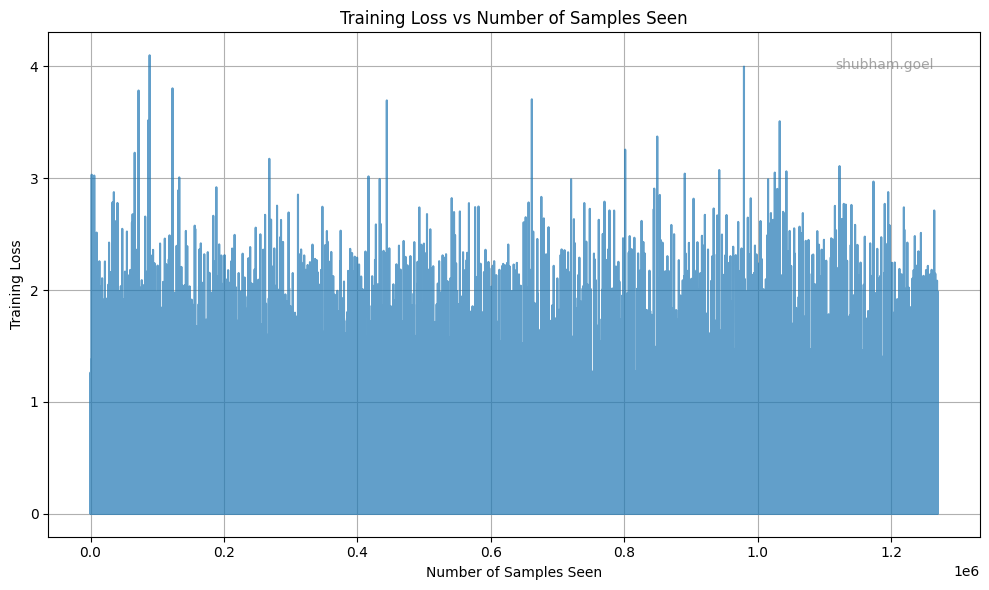

Results saved to runs/border/batch_4_gradacc_4/
Model accuracy: 90.12%


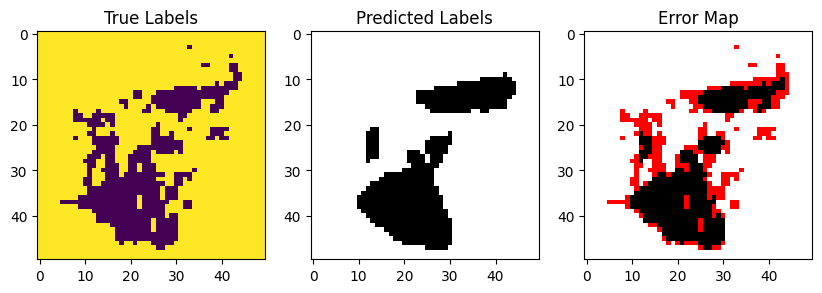

Time taken: 35.97 seconds
train_loss: 0.21930483370722204, accuracy: 90.12%
Running with batch size 4 and grad accumulation 8 and learning rate 0.01
Model created with 105 parameters.
Starting training: border/batch_4_gradacc_8
Early stopping at epoch 3359
Training completed: 3360 epochs, 8400000 samples
Final loss: 0.191479


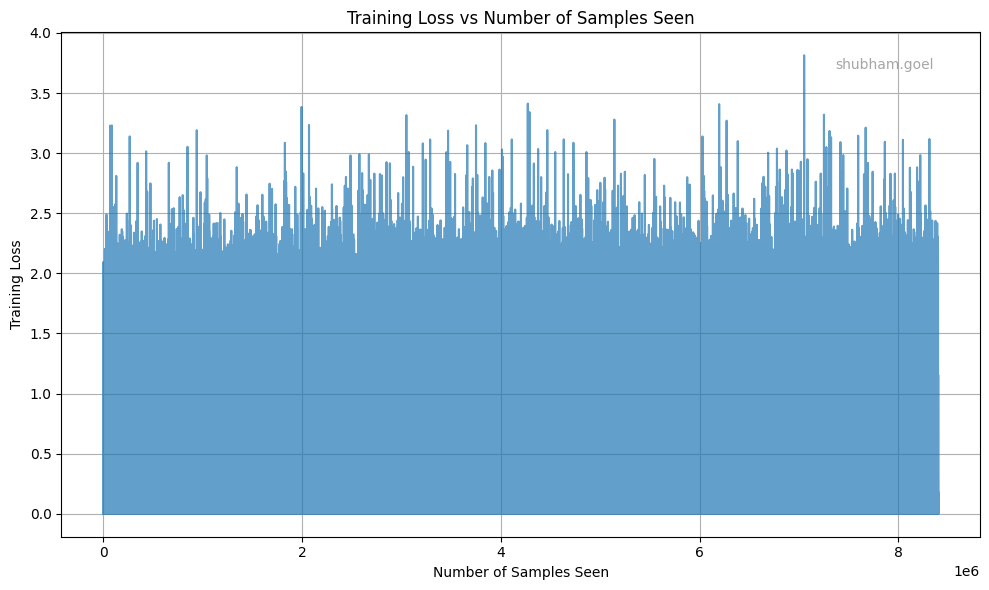

Results saved to runs/border/batch_4_gradacc_8/
Model accuracy: 91.52%


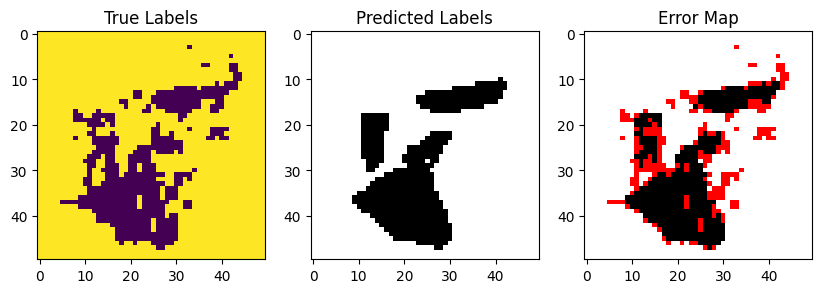

Time taken: 232.38 seconds
train_loss: 0.19147925435158694, accuracy: 91.52%
Running with batch size 4 and grad accumulation 8 and learning rate 0.1
Model created with 105 parameters.
Starting training: border/batch_4_gradacc_8
Early stopping at epoch 502
Training completed: 503 epochs, 1257500 samples
Final loss: 0.194235


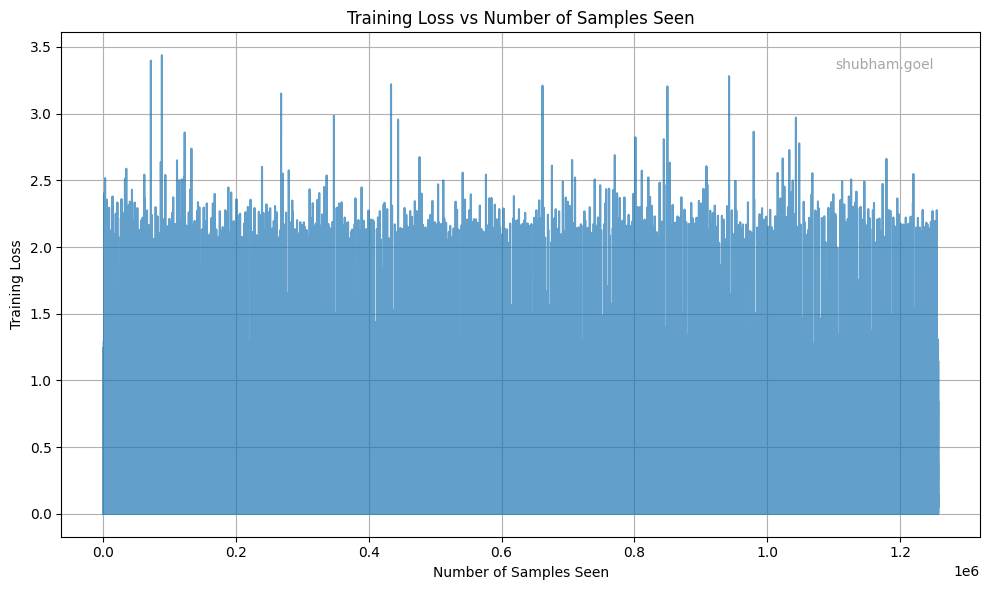

Results saved to runs/border/batch_4_gradacc_8/
Model accuracy: 91.76%


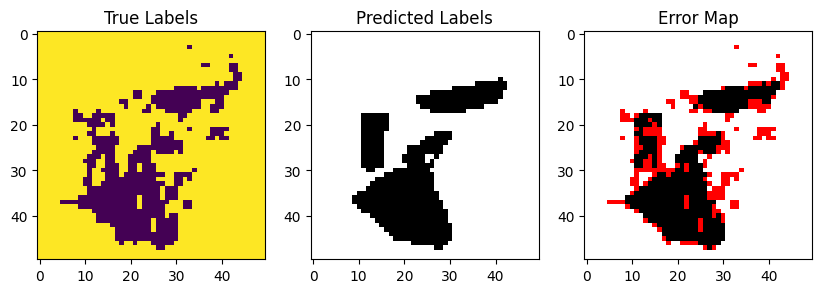

Time taken: 35.13 seconds
train_loss: 0.19423515386917875, accuracy: 91.76%
Running with batch size 4 and grad accumulation 8 and learning rate 0.5
Model created with 105 parameters.
Starting training: border/batch_4_gradacc_8
Early stopping at epoch 506
Training completed: 507 epochs, 1267500 samples
Final loss: 0.204069


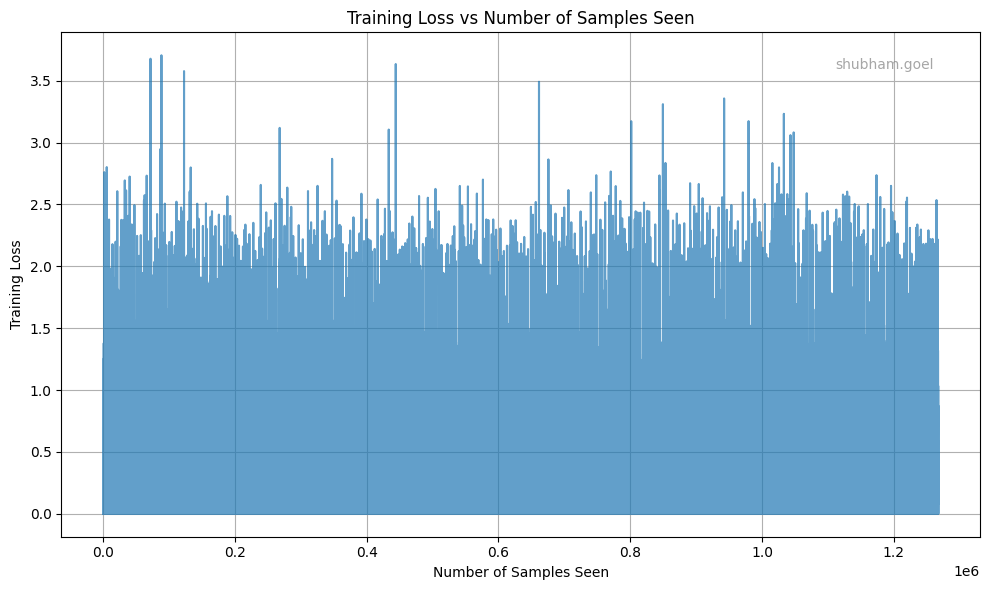

Results saved to runs/border/batch_4_gradacc_8/
Model accuracy: 91.80%


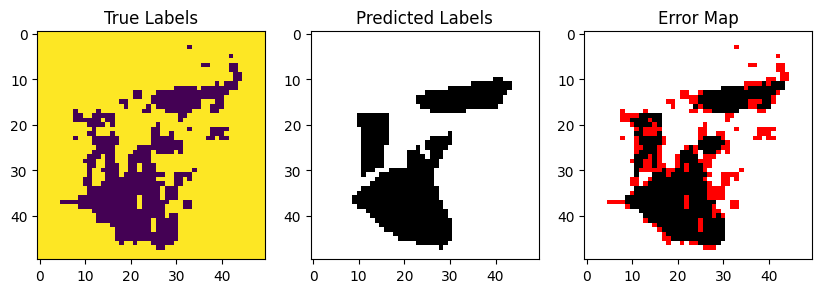

Time taken: 35.22 seconds
train_loss: 0.2040690935119633, accuracy: 91.80%
Running with batch size 16 and grad accumulation 1 and learning rate 0.01
Model created with 105 parameters.
Starting training: border/batch_16_gradacc_1
Early stopping at epoch 504
Training completed: 505 epochs, 1262500 samples
Final loss: 0.193921


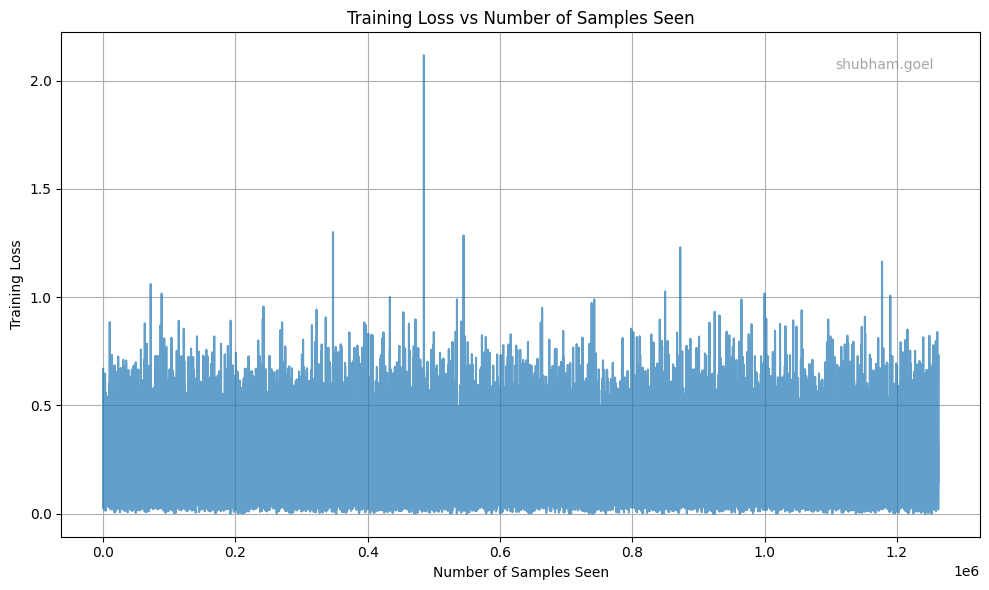

Results saved to runs/border/batch_16_gradacc_1/
Model accuracy: 91.64%


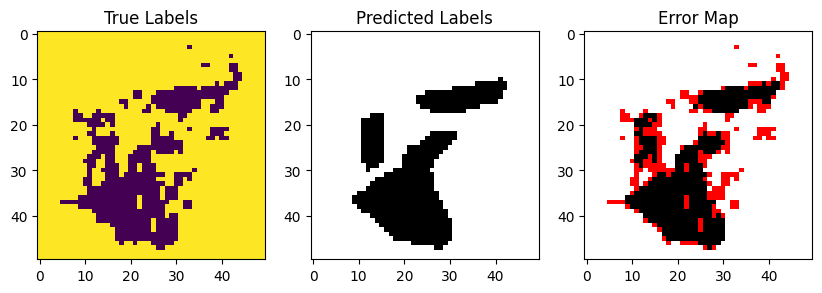

Time taken: 10.90 seconds
train_loss: 0.19392078133099178, accuracy: 91.64%
Running with batch size 16 and grad accumulation 1 and learning rate 0.1
Model created with 105 parameters.
Starting training: border/batch_16_gradacc_1
Early stopping at epoch 504
Training completed: 505 epochs, 1262500 samples
Final loss: 0.195992


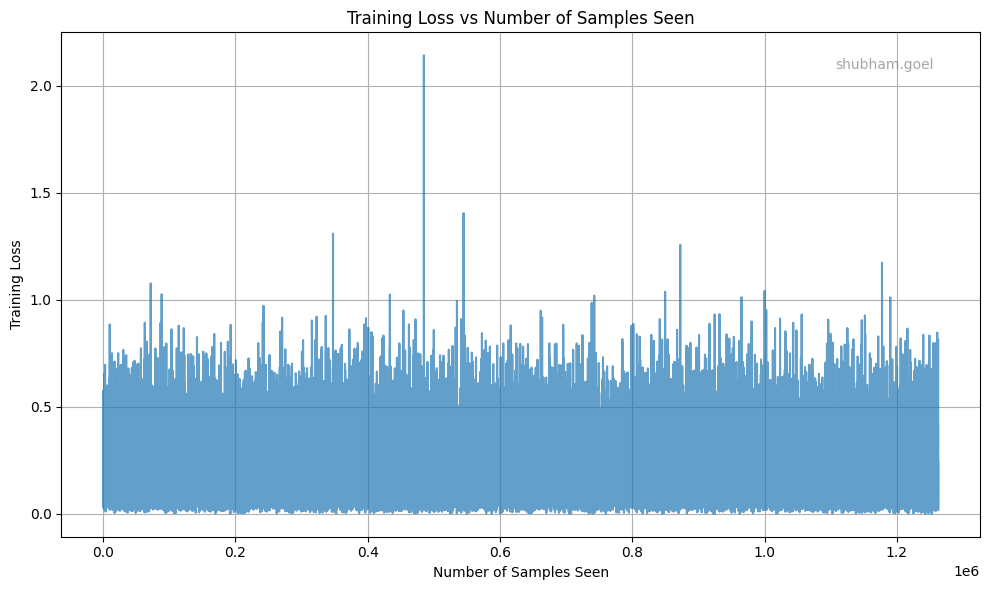

Results saved to runs/border/batch_16_gradacc_1/
Model accuracy: 91.04%


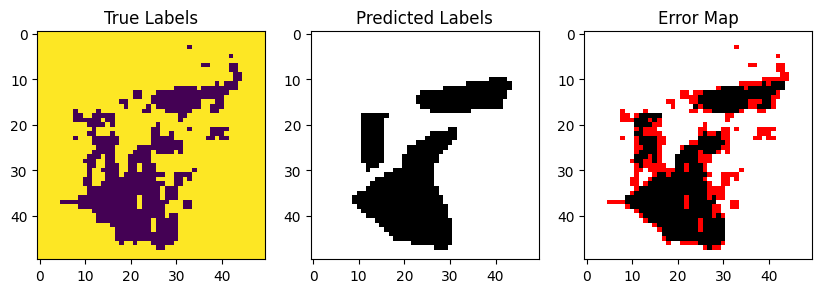

Time taken: 10.85 seconds
train_loss: 0.19599216871554215, accuracy: 91.04%
Running with batch size 16 and grad accumulation 1 and learning rate 0.5
Model created with 105 parameters.
Starting training: border/batch_16_gradacc_1
Early stopping at epoch 500
Training completed: 501 epochs, 1252500 samples
Final loss: 0.204131


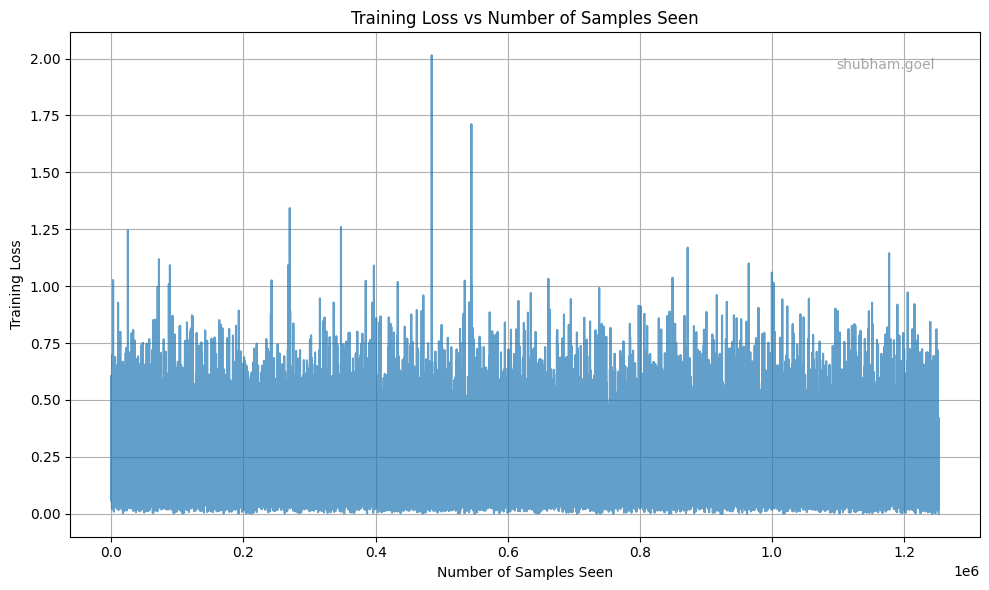

Results saved to runs/border/batch_16_gradacc_1/
Model accuracy: 91.80%


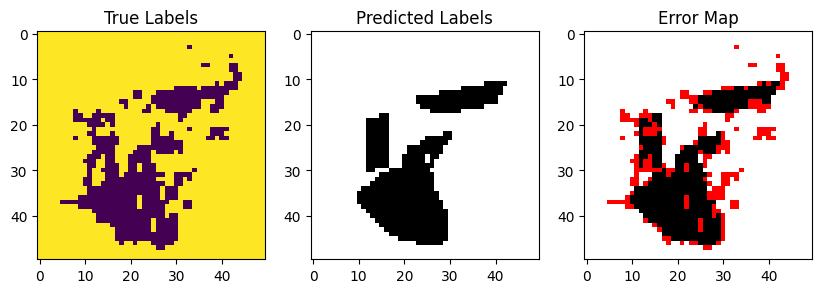

Time taken: 11.07 seconds
train_loss: 0.20413098184676914, accuracy: 91.80%
Running with batch size 16 and grad accumulation 2 and learning rate 0.01
Model created with 105 parameters.
Starting training: border/batch_16_gradacc_2
Early stopping at epoch 504
Training completed: 505 epochs, 1262500 samples
Final loss: 0.193441


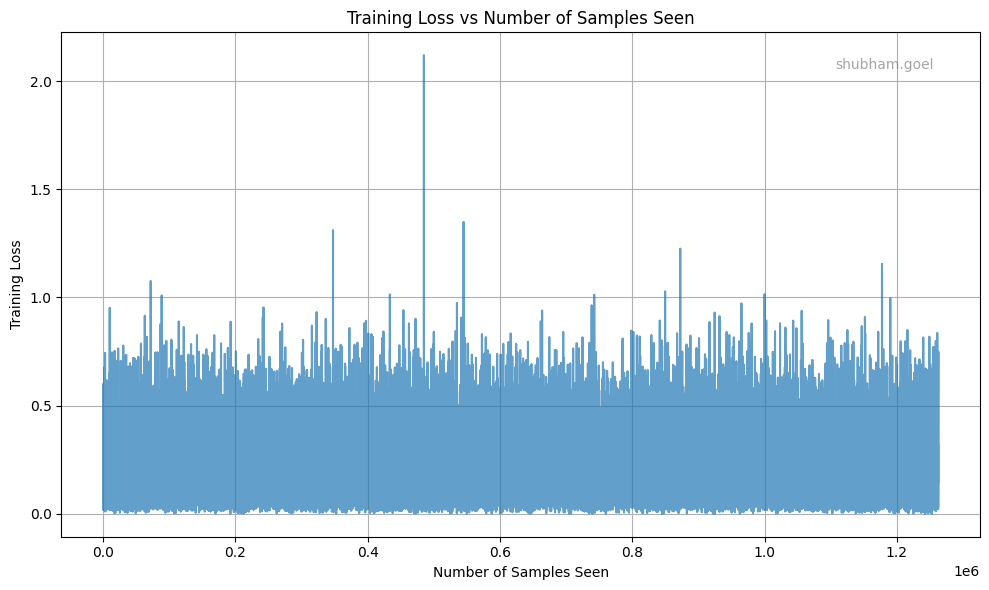

Results saved to runs/border/batch_16_gradacc_2/
Model accuracy: 91.68%


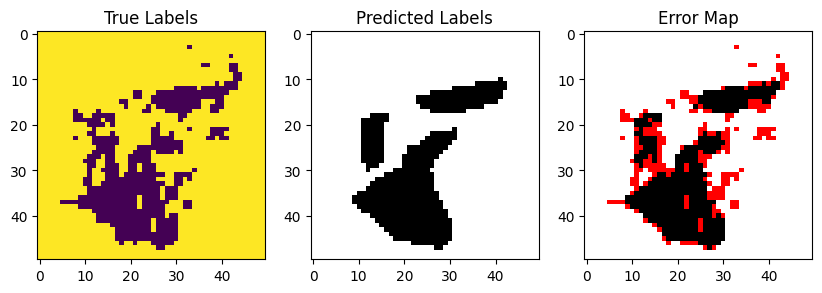

Time taken: 10.64 seconds
train_loss: 0.19344065084828269, accuracy: 91.68%
Running with batch size 16 and grad accumulation 2 and learning rate 0.1
Model created with 105 parameters.
Starting training: border/batch_16_gradacc_2
Early stopping at epoch 504
Training completed: 505 epochs, 1262500 samples
Final loss: 0.194501


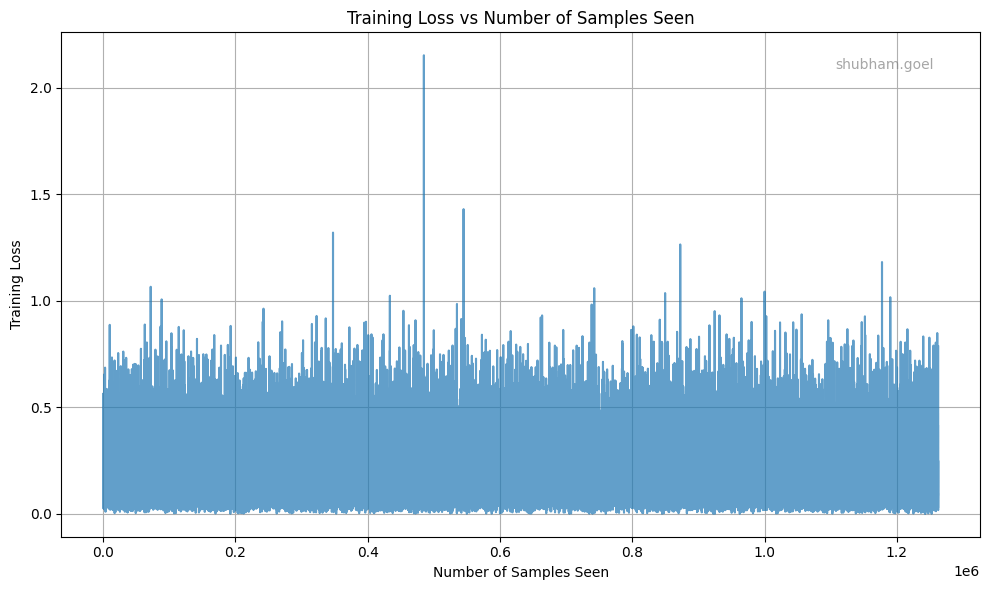

Results saved to runs/border/batch_16_gradacc_2/
Model accuracy: 91.48%


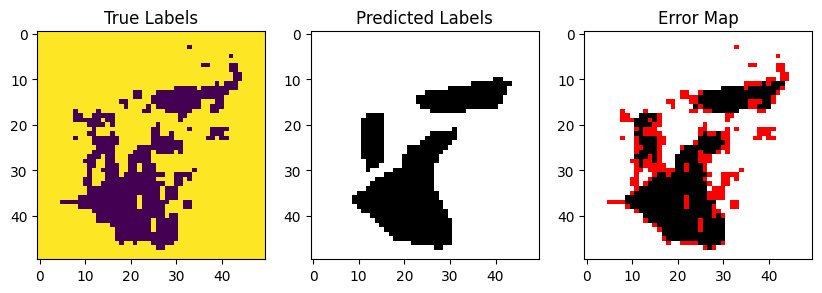

Time taken: 10.91 seconds
train_loss: 0.19450148751589508, accuracy: 91.48%
Running with batch size 16 and grad accumulation 2 and learning rate 0.5
Model created with 105 parameters.
Starting training: border/batch_16_gradacc_2
Early stopping at epoch 500
Training completed: 501 epochs, 1252500 samples
Final loss: 0.195669


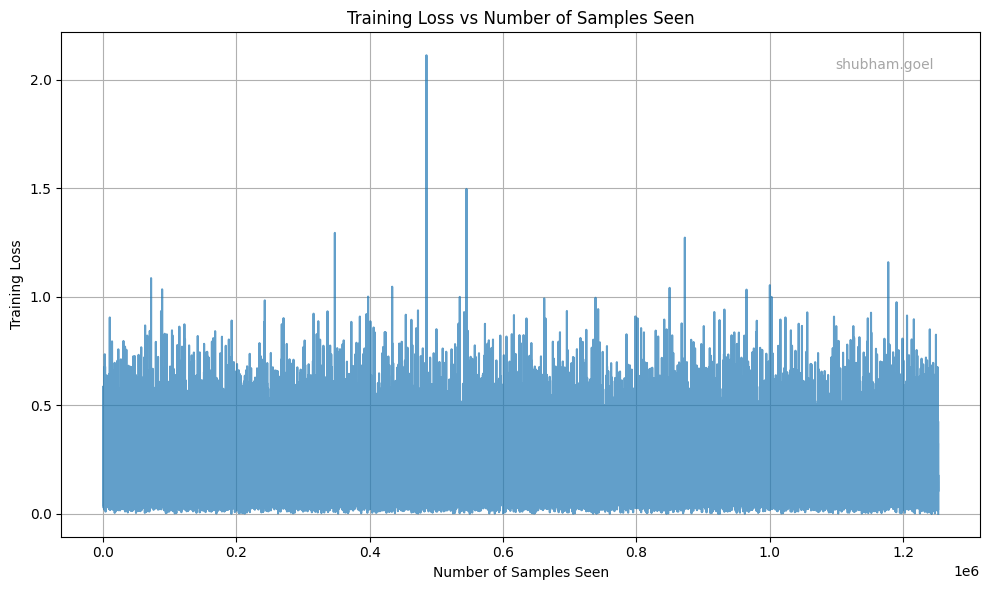

Results saved to runs/border/batch_16_gradacc_2/
Model accuracy: 91.52%


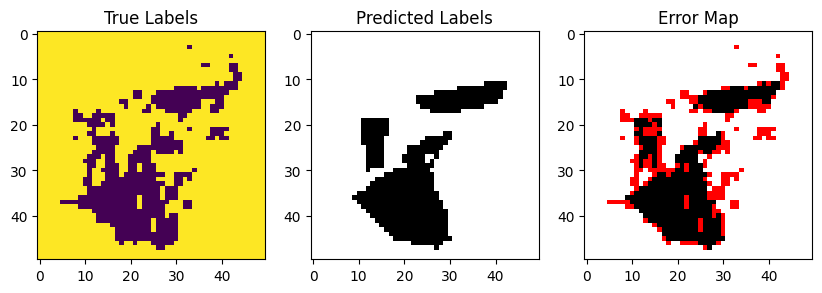

Time taken: 10.30 seconds
train_loss: 0.19566873354158512, accuracy: 91.52%
Running with batch size 16 and grad accumulation 4 and learning rate 0.01
Model created with 105 parameters.
Starting training: border/batch_16_gradacc_4
Early stopping at epoch 504
Training completed: 505 epochs, 1262500 samples
Final loss: 0.193129


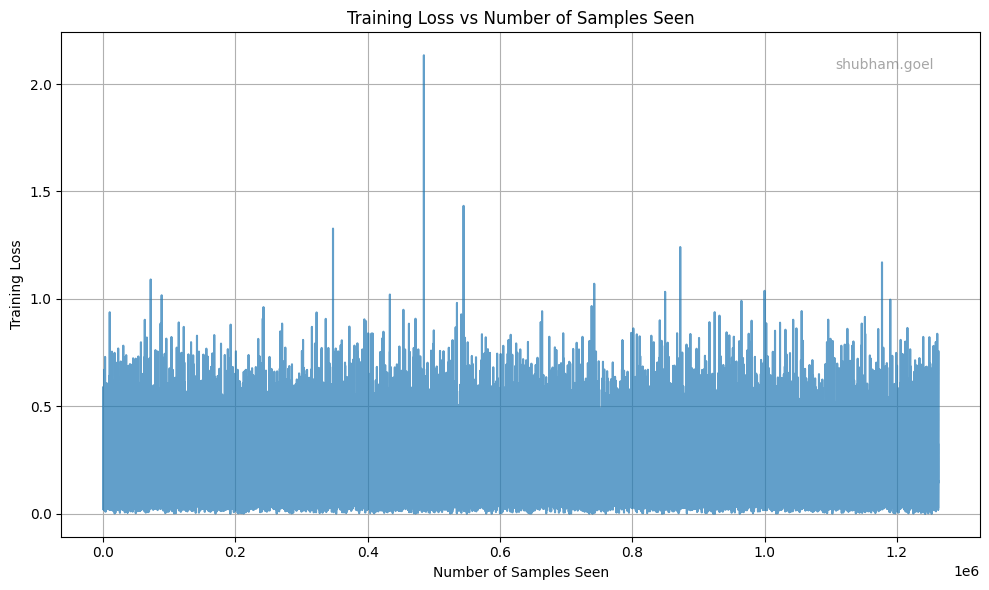

Results saved to runs/border/batch_16_gradacc_4/
Model accuracy: 91.76%


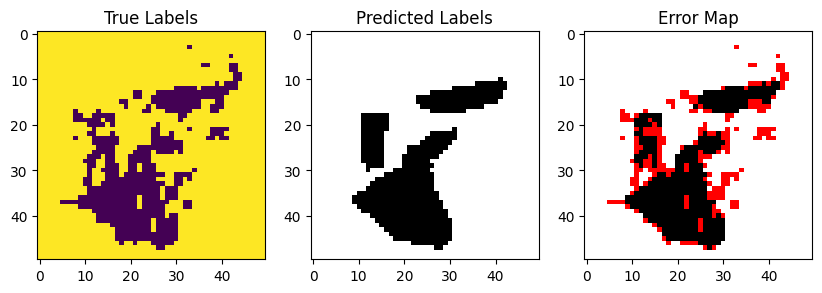

Time taken: 10.19 seconds
train_loss: 0.1931291434939257, accuracy: 91.76%
Running with batch size 16 and grad accumulation 4 and learning rate 0.1
Model created with 105 parameters.
Starting training: border/batch_16_gradacc_4
Early stopping at epoch 504
Training completed: 505 epochs, 1262500 samples
Final loss: 0.193750


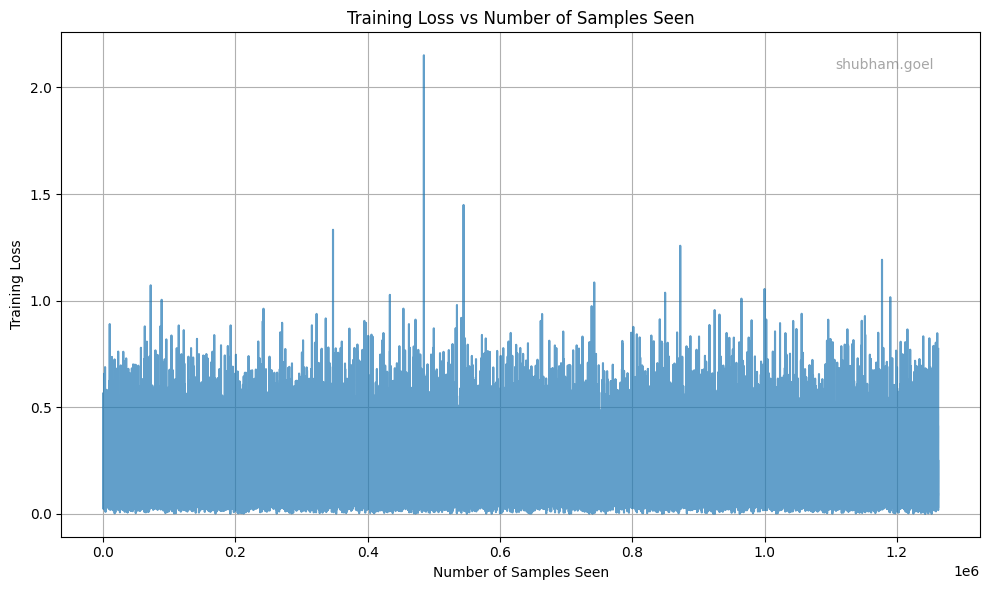

Results saved to runs/border/batch_16_gradacc_4/
Model accuracy: 91.72%


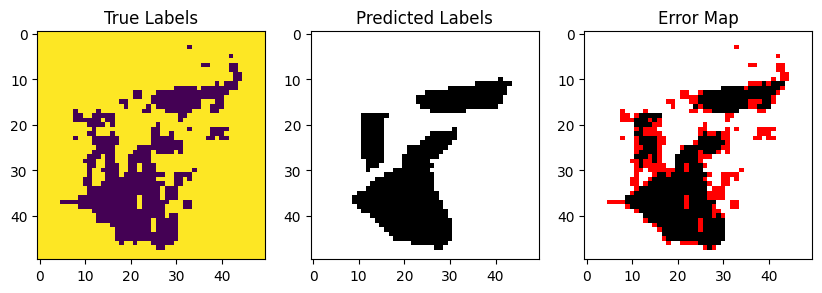

Time taken: 10.77 seconds
train_loss: 0.19374986911317402, accuracy: 91.72%
Running with batch size 16 and grad accumulation 4 and learning rate 0.5
Model created with 105 parameters.
Starting training: border/batch_16_gradacc_4
Early stopping at epoch 504
Training completed: 505 epochs, 1262500 samples
Final loss: 0.197168


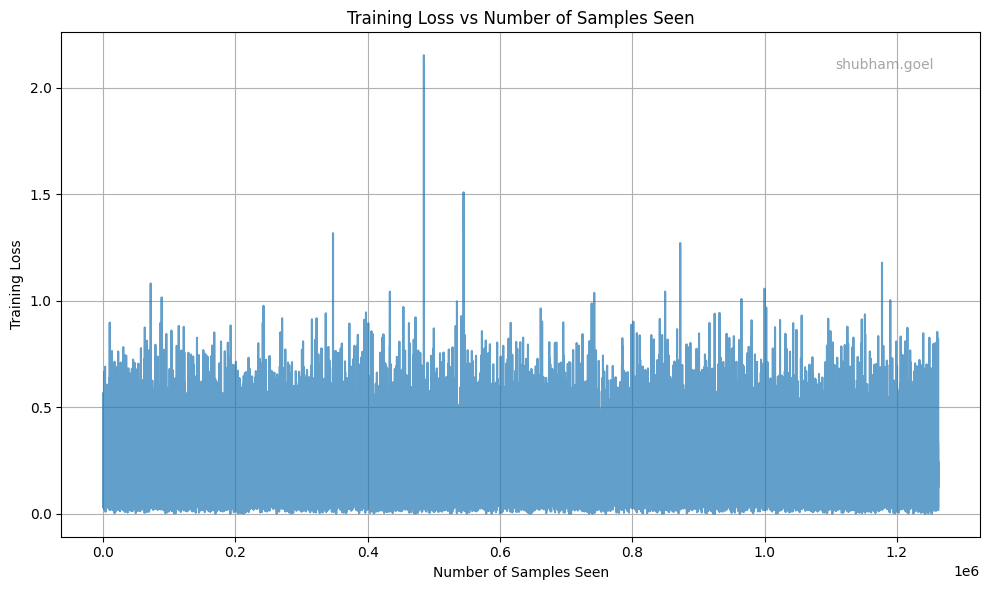

Results saved to runs/border/batch_16_gradacc_4/
Model accuracy: 91.24%


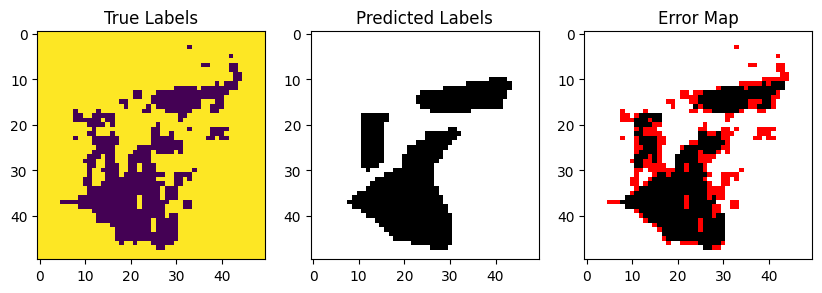

Time taken: 10.27 seconds
train_loss: 0.19716773267955712, accuracy: 91.24%
Running with batch size 16 and grad accumulation 8 and learning rate 0.01
Model created with 105 parameters.
Starting training: border/batch_16_gradacc_8
Early stopping at epoch 526
Training completed: 527 epochs, 1317500 samples
Final loss: 0.191582


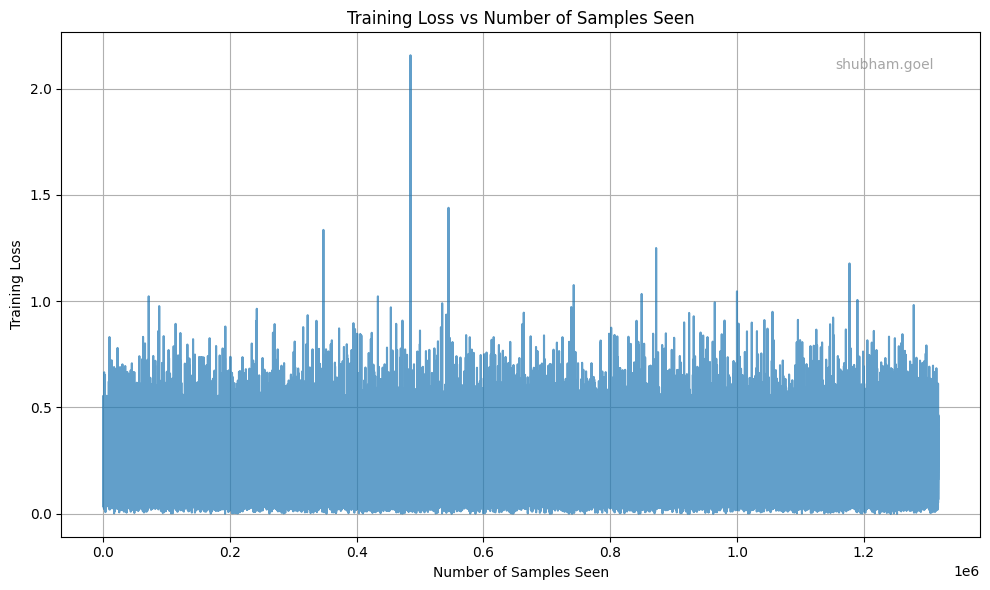

Results saved to runs/border/batch_16_gradacc_8/
Model accuracy: 91.92%


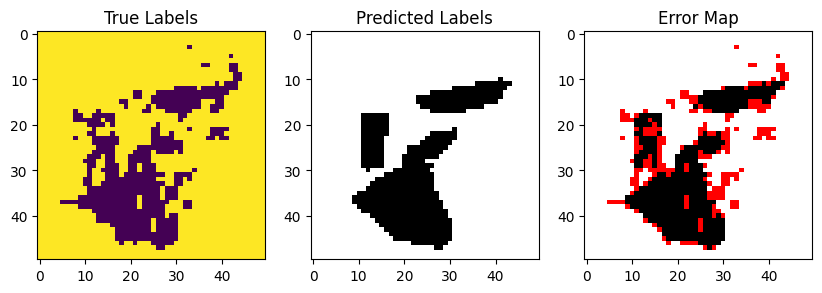

Time taken: 10.73 seconds
train_loss: 0.1915815982372022, accuracy: 91.92%
Running with batch size 16 and grad accumulation 8 and learning rate 0.1
Model created with 105 parameters.
Starting training: border/batch_16_gradacc_8
Early stopping at epoch 504
Training completed: 505 epochs, 1262500 samples
Final loss: 0.193299


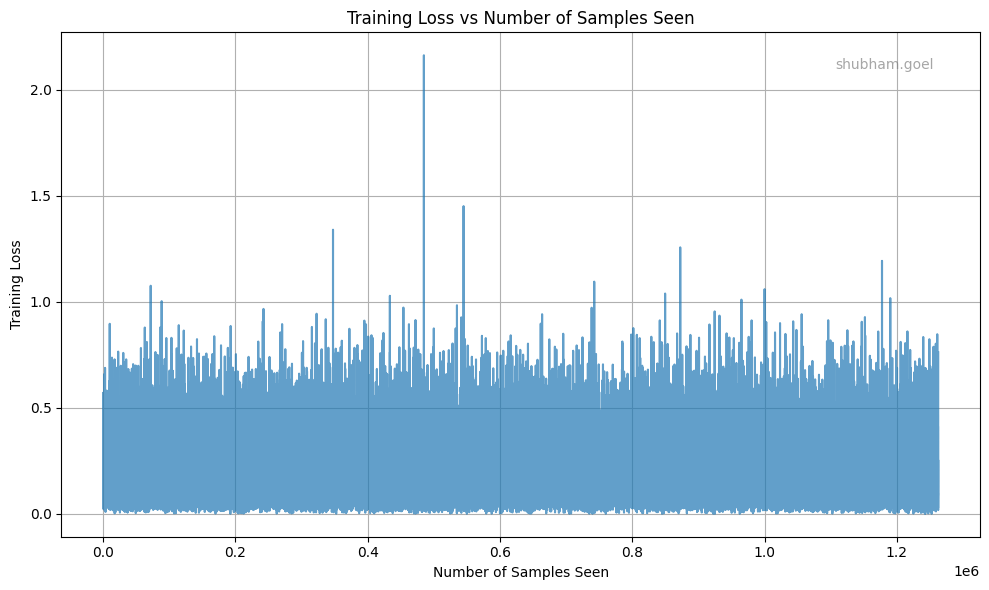

Results saved to runs/border/batch_16_gradacc_8/
Model accuracy: 91.72%


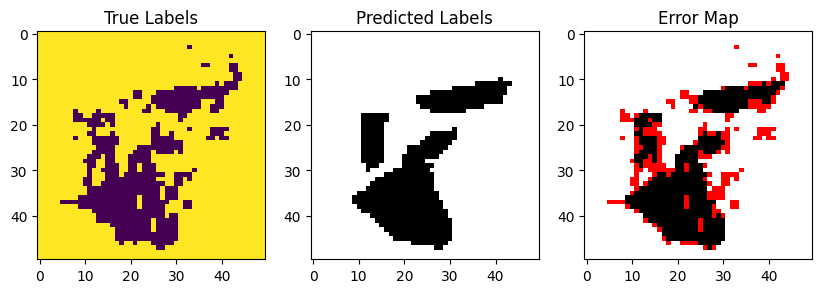

Time taken: 10.40 seconds
train_loss: 0.19329905619789878, accuracy: 91.72%
Running with batch size 16 and grad accumulation 8 and learning rate 0.5
Model created with 105 parameters.
Starting training: border/batch_16_gradacc_8
Early stopping at epoch 504
Training completed: 505 epochs, 1262500 samples
Final loss: 0.194900


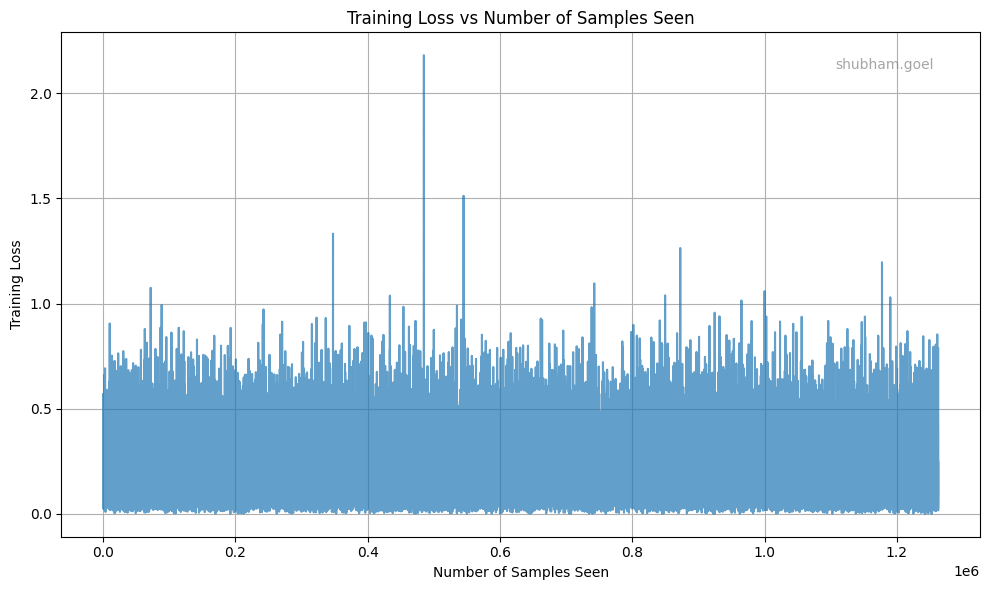

Results saved to runs/border/batch_16_gradacc_8/
Model accuracy: 91.44%


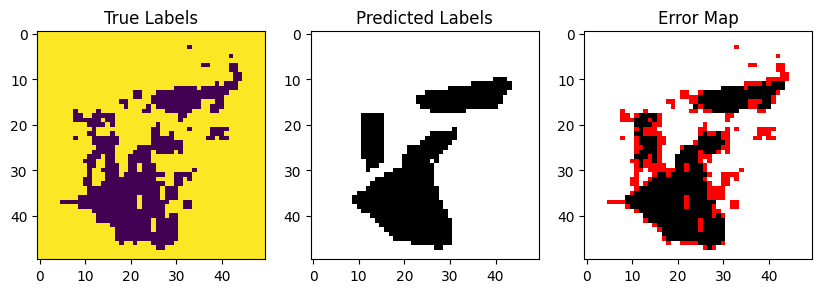

Time taken: 10.38 seconds
train_loss: 0.1949003512272966, accuracy: 91.44%
Running with batch size 64 and grad accumulation 1 and learning rate 0.01
Model created with 105 parameters.
Starting training: border/batch_64_gradacc_1
Early stopping at epoch 504
Training completed: 505 epochs, 1262500 samples
Final loss: 0.203394


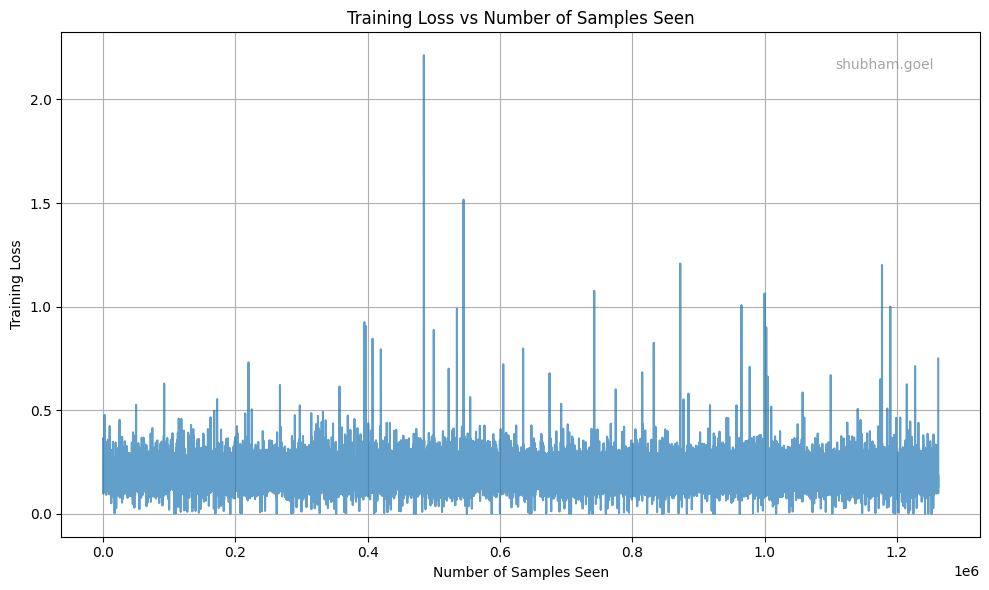

Results saved to runs/border/batch_64_gradacc_1/
Model accuracy: 91.92%


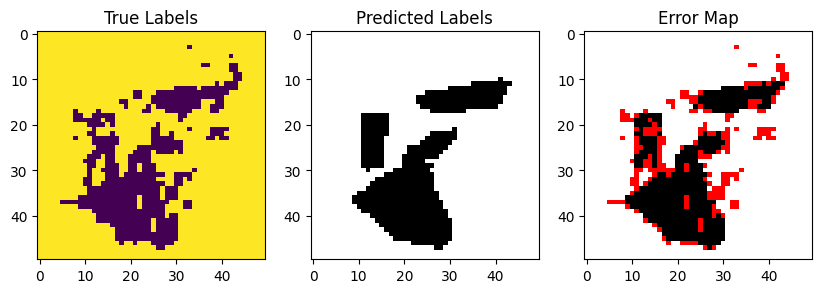

Time taken: 3.62 seconds
train_loss: 0.20339443171216587, accuracy: 91.92%
Running with batch size 64 and grad accumulation 1 and learning rate 0.1
Model created with 105 parameters.
Starting training: border/batch_64_gradacc_1
Early stopping at epoch 503
Training completed: 504 epochs, 1260000 samples
Final loss: 0.195750


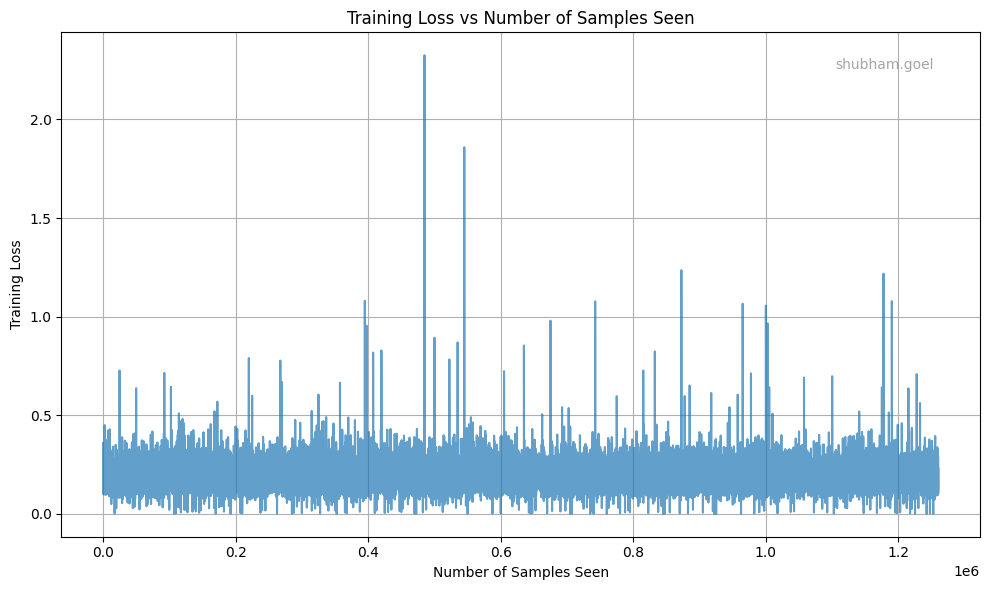

Results saved to runs/border/batch_64_gradacc_1/
Model accuracy: 91.60%


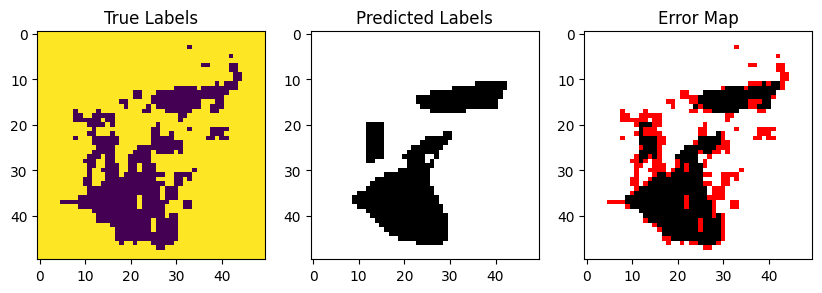

Time taken: 3.50 seconds
train_loss: 0.19574954214323978, accuracy: 91.60%
Running with batch size 64 and grad accumulation 1 and learning rate 0.5
Model created with 105 parameters.
Starting training: border/batch_64_gradacc_1
Early stopping at epoch 500
Training completed: 501 epochs, 1252500 samples
Final loss: 0.235230


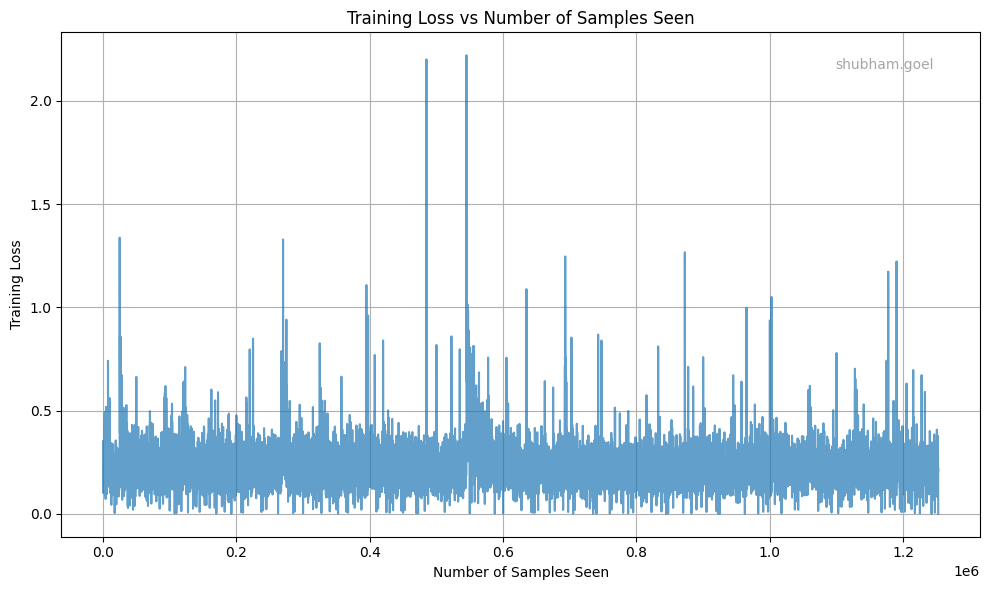

Results saved to runs/border/batch_64_gradacc_1/
Model accuracy: 90.36%


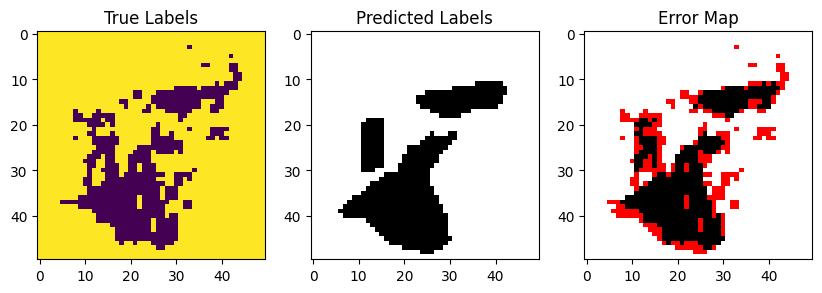

Time taken: 3.50 seconds
train_loss: 0.23523020847397133, accuracy: 90.36%
Running with batch size 64 and grad accumulation 2 and learning rate 0.01
Model created with 105 parameters.
Starting training: border/batch_64_gradacc_2
Early stopping at epoch 594
Training completed: 595 epochs, 1487500 samples
Final loss: 0.207058


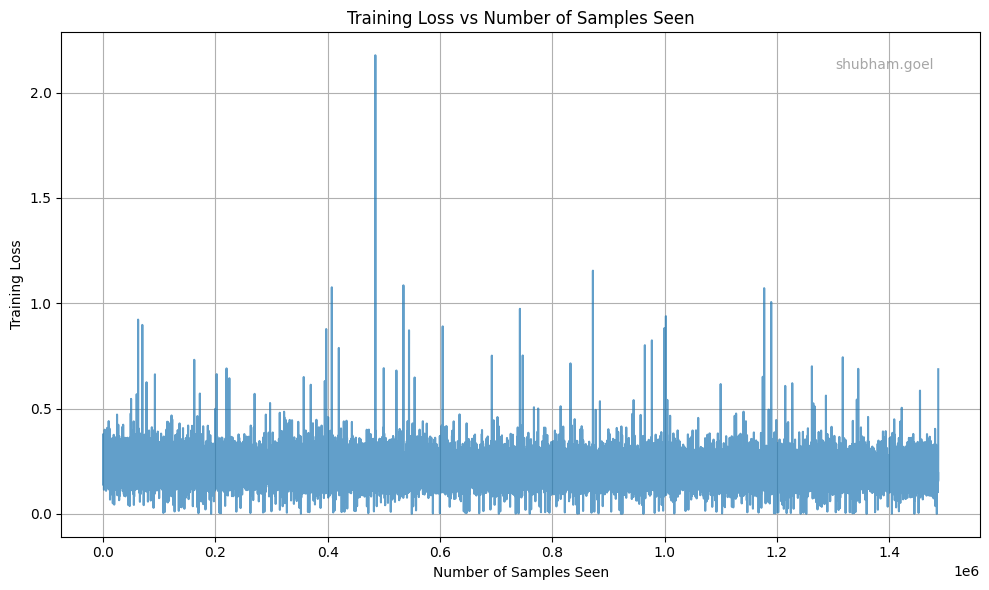

Results saved to runs/border/batch_64_gradacc_2/
Model accuracy: 91.76%


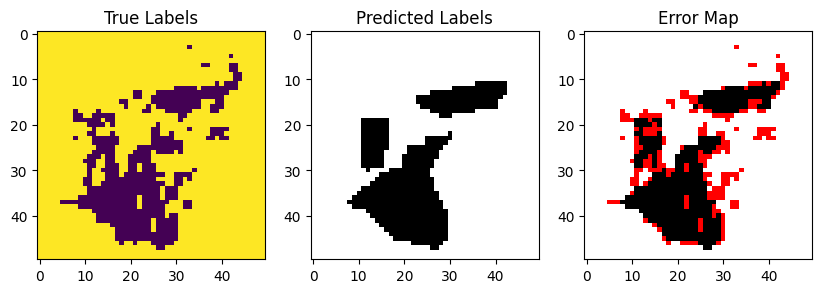

Time taken: 3.88 seconds
train_loss: 0.20705802966222514, accuracy: 91.76%
Running with batch size 64 and grad accumulation 2 and learning rate 0.1
Model created with 105 parameters.
Starting training: border/batch_64_gradacc_2
Early stopping at epoch 504
Training completed: 505 epochs, 1262500 samples
Final loss: 0.205941


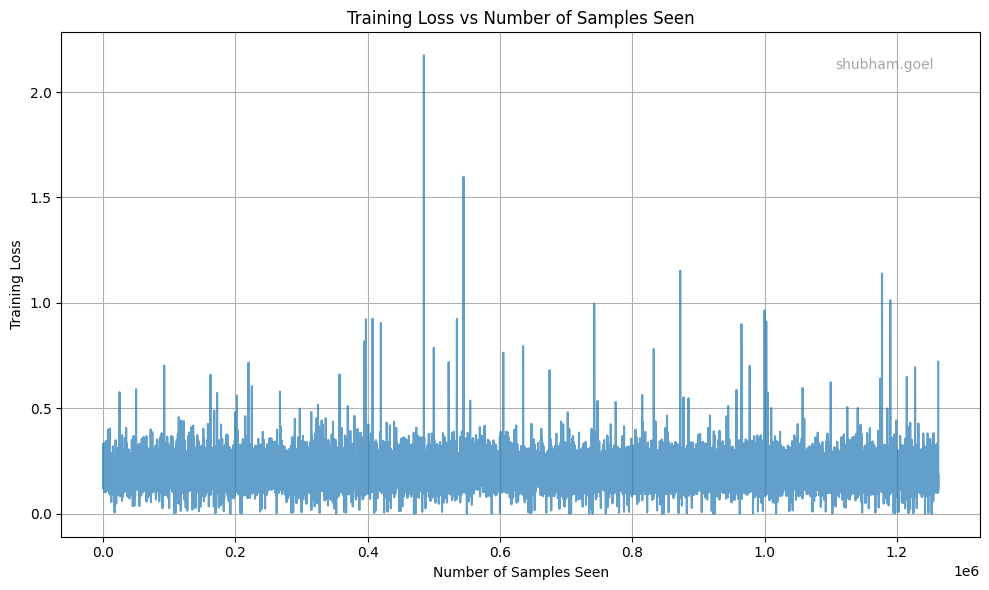

Results saved to runs/border/batch_64_gradacc_2/
Model accuracy: 91.84%


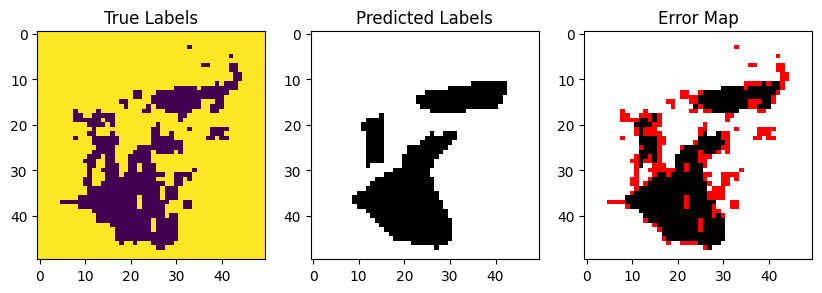

Time taken: 3.40 seconds
train_loss: 0.2059413912814656, accuracy: 91.84%
Running with batch size 64 and grad accumulation 2 and learning rate 0.5
Model created with 105 parameters.
Starting training: border/batch_64_gradacc_2
Early stopping at epoch 500
Training completed: 501 epochs, 1252500 samples
Final loss: 0.201023


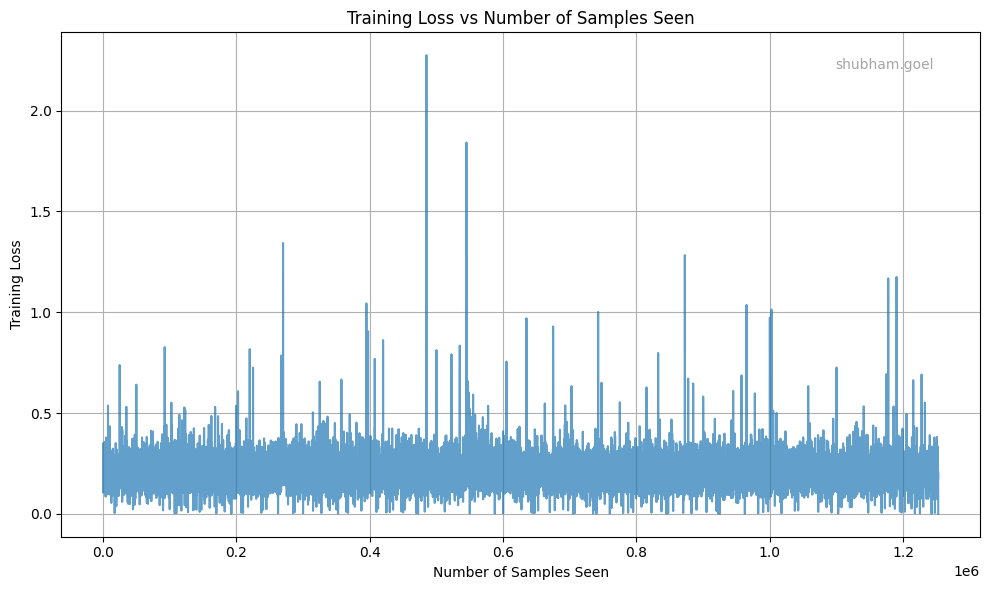

Results saved to runs/border/batch_64_gradacc_2/
Model accuracy: 91.48%


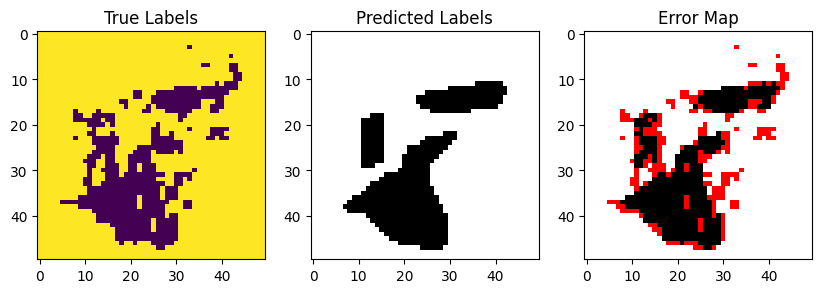

Time taken: 3.35 seconds
train_loss: 0.2010233431833493, accuracy: 91.48%
Running with batch size 64 and grad accumulation 4 and learning rate 0.01
Model created with 105 parameters.
Starting training: border/batch_64_gradacc_4
Early stopping at epoch 504
Training completed: 505 epochs, 1262500 samples
Final loss: 0.205699


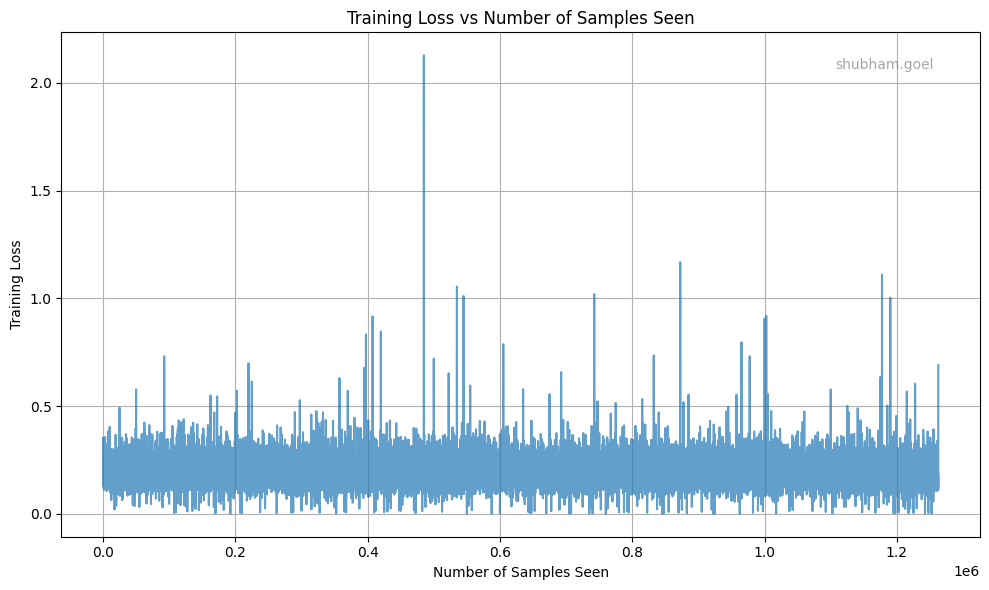

Results saved to runs/border/batch_64_gradacc_4/
Model accuracy: 92.00%


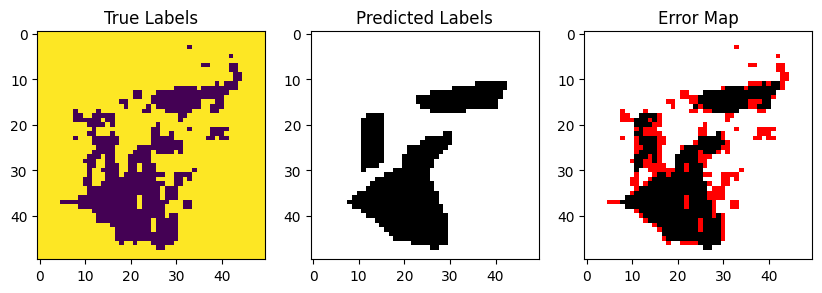

Time taken: 3.31 seconds
train_loss: 0.20569854619376512, accuracy: 92.00%
Running with batch size 64 and grad accumulation 4 and learning rate 0.1
Model created with 105 parameters.
Starting training: border/batch_64_gradacc_4
Early stopping at epoch 504
Training completed: 505 epochs, 1262500 samples
Final loss: 0.203936


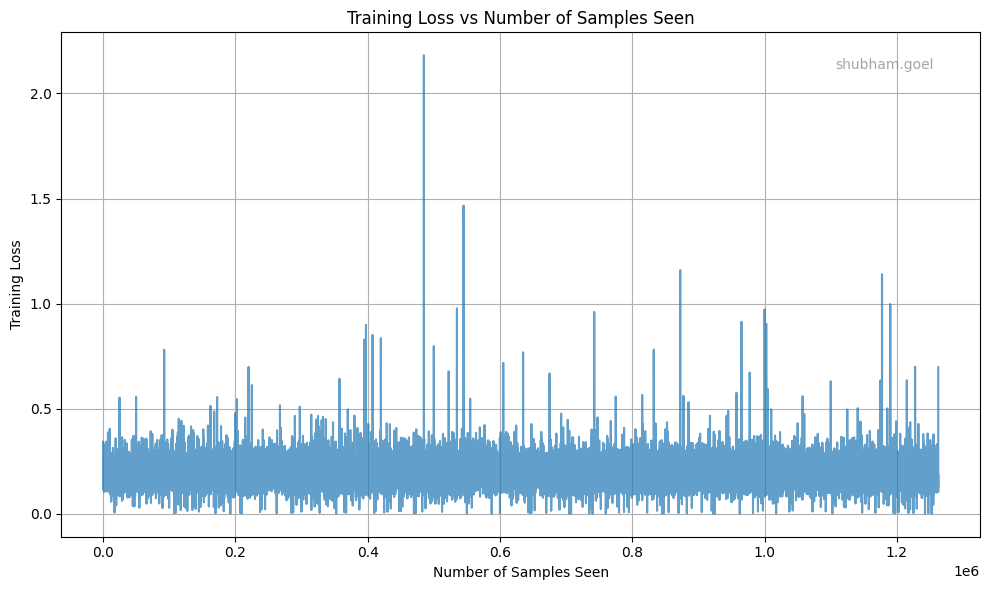

Results saved to runs/border/batch_64_gradacc_4/
Model accuracy: 91.76%


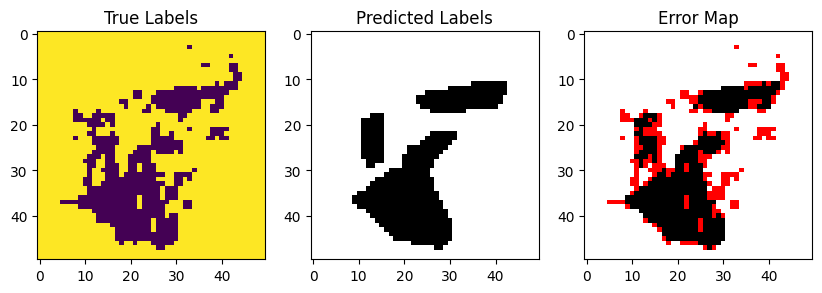

Time taken: 3.33 seconds
train_loss: 0.20393587866613183, accuracy: 91.76%
Running with batch size 64 and grad accumulation 4 and learning rate 0.5
Model created with 105 parameters.
Starting training: border/batch_64_gradacc_4
Early stopping at epoch 504
Training completed: 505 epochs, 1262500 samples
Final loss: 0.210714


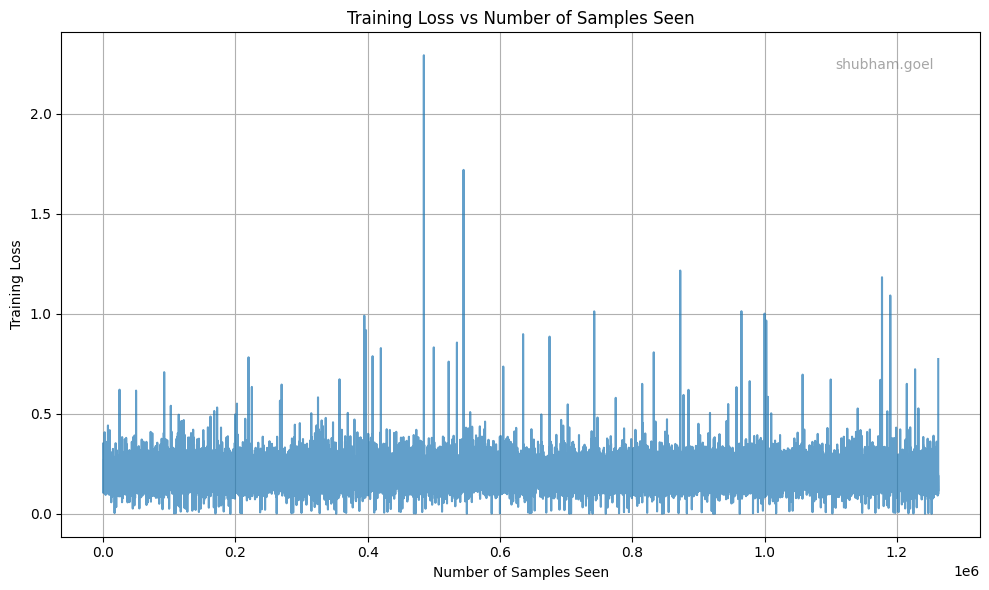

Results saved to runs/border/batch_64_gradacc_4/
Model accuracy: 91.20%


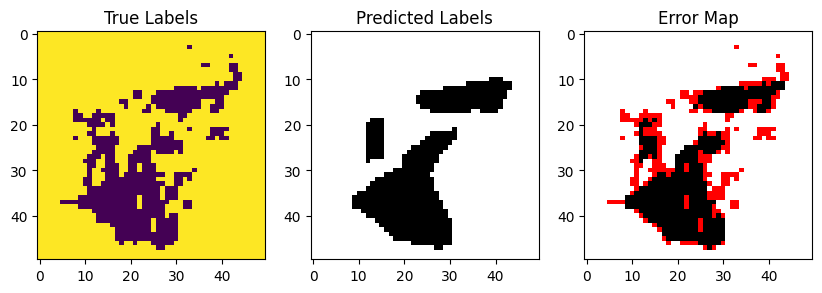

Time taken: 3.32 seconds
train_loss: 0.21071449289767438, accuracy: 91.20%
Running with batch size 64 and grad accumulation 8 and learning rate 0.01
Model created with 105 parameters.
Starting training: border/batch_64_gradacc_8
Early stopping at epoch 504
Training completed: 505 epochs, 1262500 samples
Final loss: 0.203295


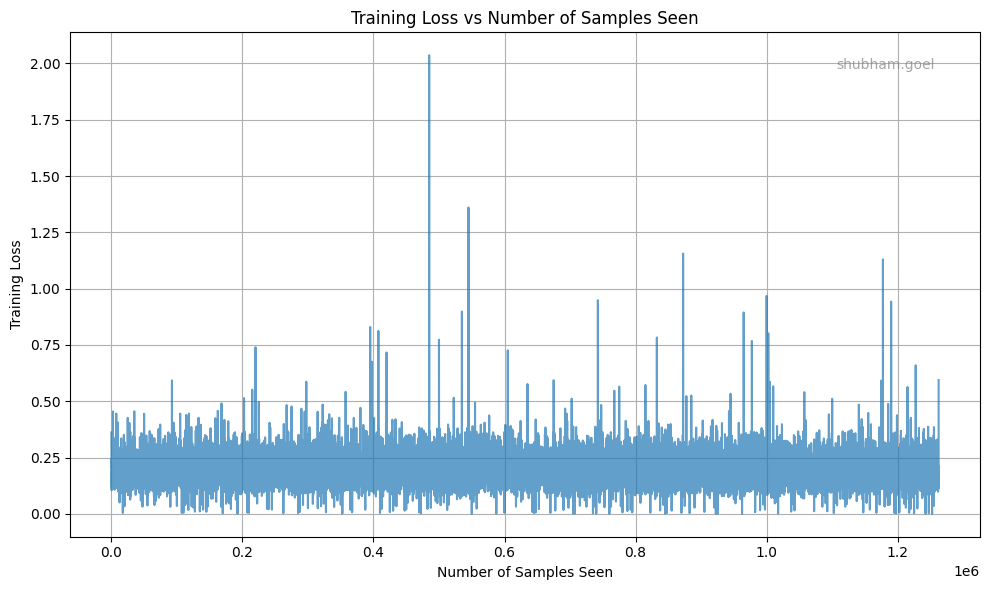

Results saved to runs/border/batch_64_gradacc_8/
Model accuracy: 91.56%


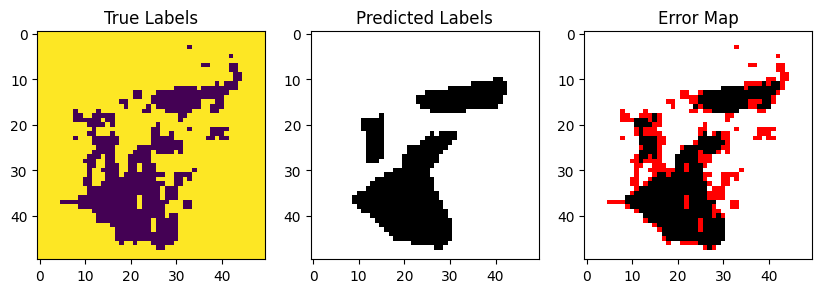

Time taken: 3.32 seconds
train_loss: 0.20329514527491913, accuracy: 91.56%
Running with batch size 64 and grad accumulation 8 and learning rate 0.1
Model created with 105 parameters.
Starting training: border/batch_64_gradacc_8
Early stopping at epoch 504
Training completed: 505 epochs, 1262500 samples
Final loss: 0.203268


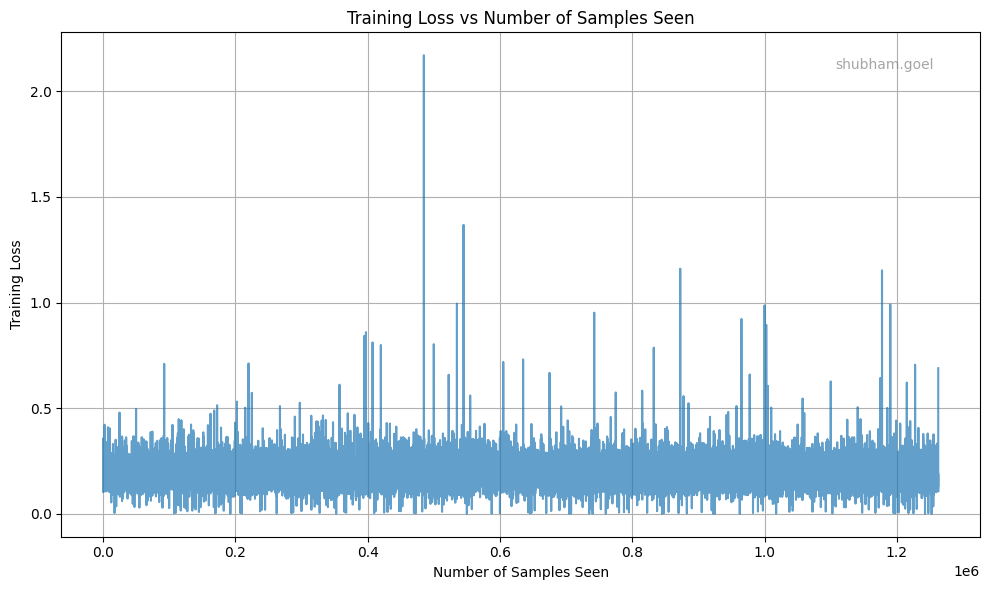

Results saved to runs/border/batch_64_gradacc_8/
Model accuracy: 91.76%


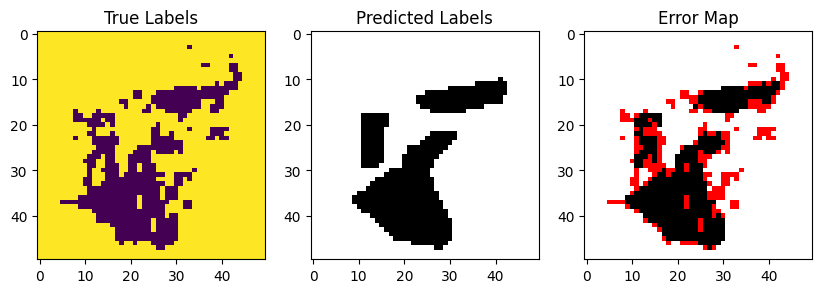

Time taken: 3.28 seconds
train_loss: 0.20326827646969678, accuracy: 91.76%
Running with batch size 64 and grad accumulation 8 and learning rate 0.5
Model created with 105 parameters.
Starting training: border/batch_64_gradacc_8
Early stopping at epoch 504
Training completed: 505 epochs, 1262500 samples
Final loss: 0.205979


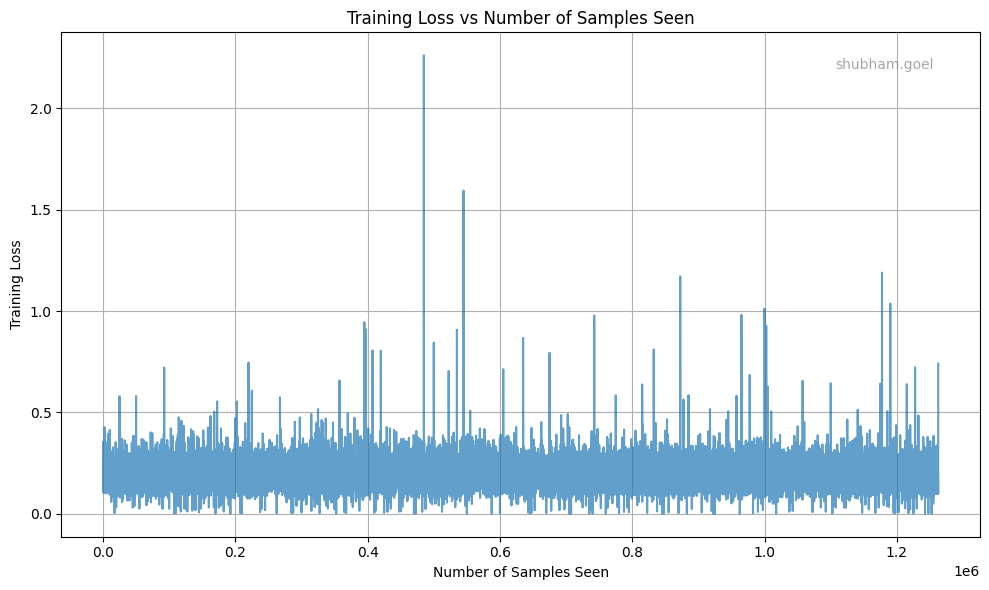

Results saved to runs/border/batch_64_gradacc_8/
Model accuracy: 91.48%


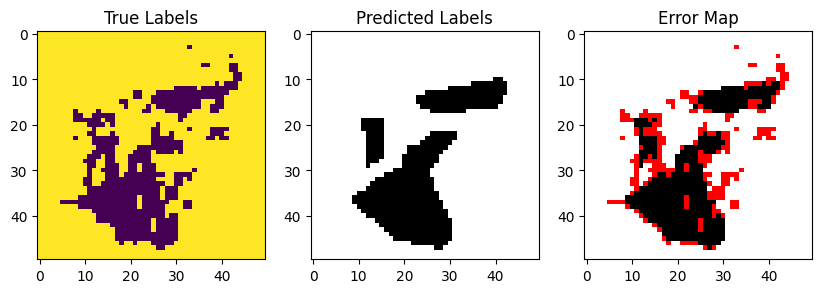

Time taken: 3.28 seconds
train_loss: 0.20597875353517833, accuracy: 91.48%
Running with batch size 128 and grad accumulation 1 and learning rate 0.01
Model created with 105 parameters.
Starting training: border/batch_128_gradacc_1
Early stopping at epoch 505
Training completed: 506 epochs, 1265000 samples
Final loss: 0.194446


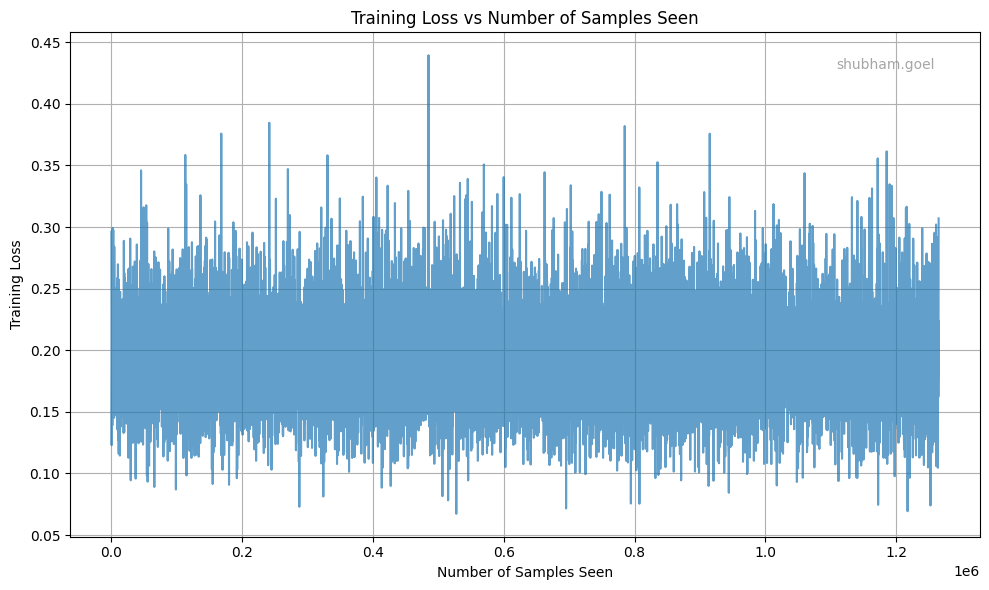

Results saved to runs/border/batch_128_gradacc_1/
Model accuracy: 91.60%


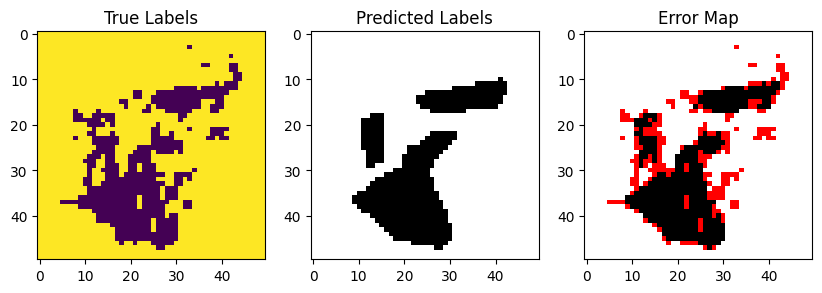

Time taken: 2.49 seconds
train_loss: 0.19444561687044665, accuracy: 91.60%
Running with batch size 128 and grad accumulation 1 and learning rate 0.1
Model created with 105 parameters.
Starting training: border/batch_128_gradacc_1
Early stopping at epoch 505
Training completed: 506 epochs, 1265000 samples
Final loss: 0.193884


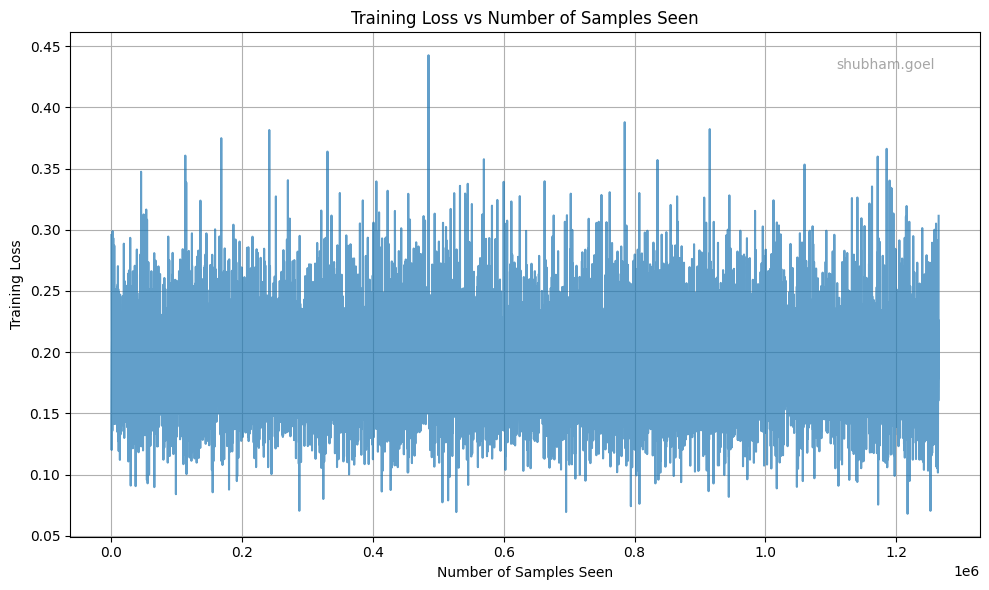

Results saved to runs/border/batch_128_gradacc_1/
Model accuracy: 91.84%


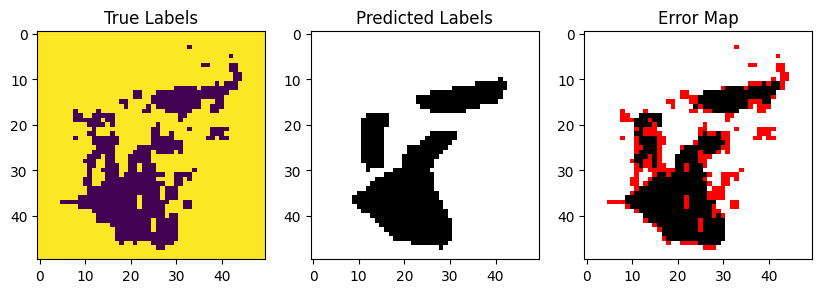

Time taken: 2.42 seconds
train_loss: 0.1938842198643419, accuracy: 91.84%
Running with batch size 128 and grad accumulation 1 and learning rate 0.5
Model created with 105 parameters.
Starting training: border/batch_128_gradacc_1
Early stopping at epoch 501
Training completed: 502 epochs, 1255000 samples
Final loss: 0.190720


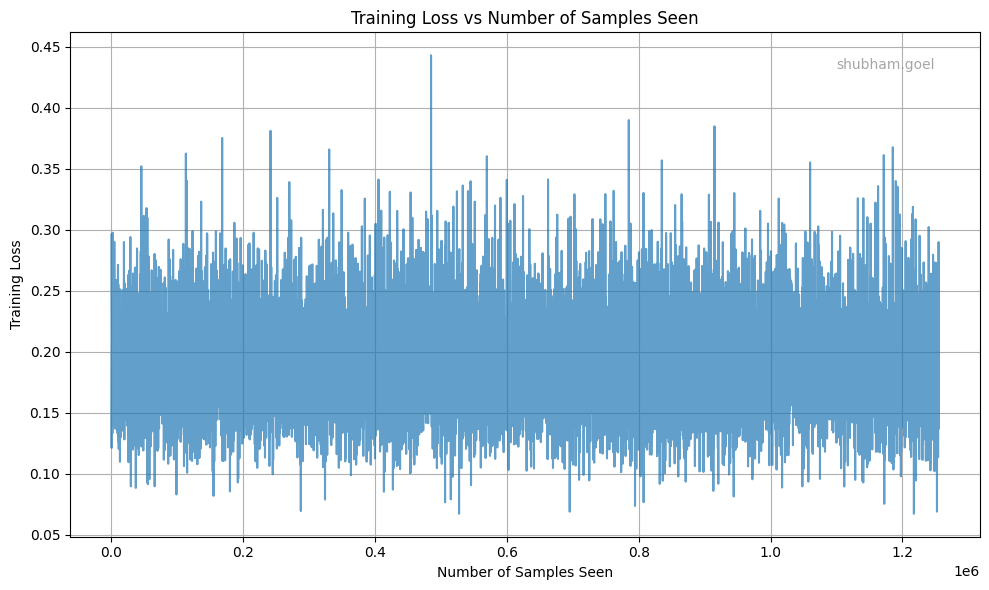

Results saved to runs/border/batch_128_gradacc_1/
Model accuracy: 91.84%


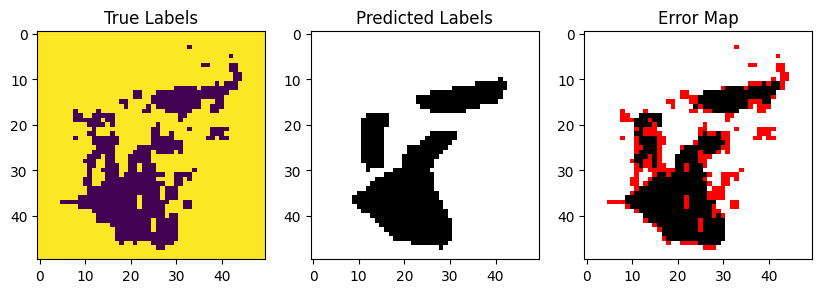

Time taken: 2.45 seconds
train_loss: 0.19072037891837762, accuracy: 91.84%
Running with batch size 128 and grad accumulation 2 and learning rate 0.01
Model created with 105 parameters.
Starting training: border/batch_128_gradacc_2
Early stopping at epoch 501
Training completed: 502 epochs, 1255000 samples
Final loss: 0.190567


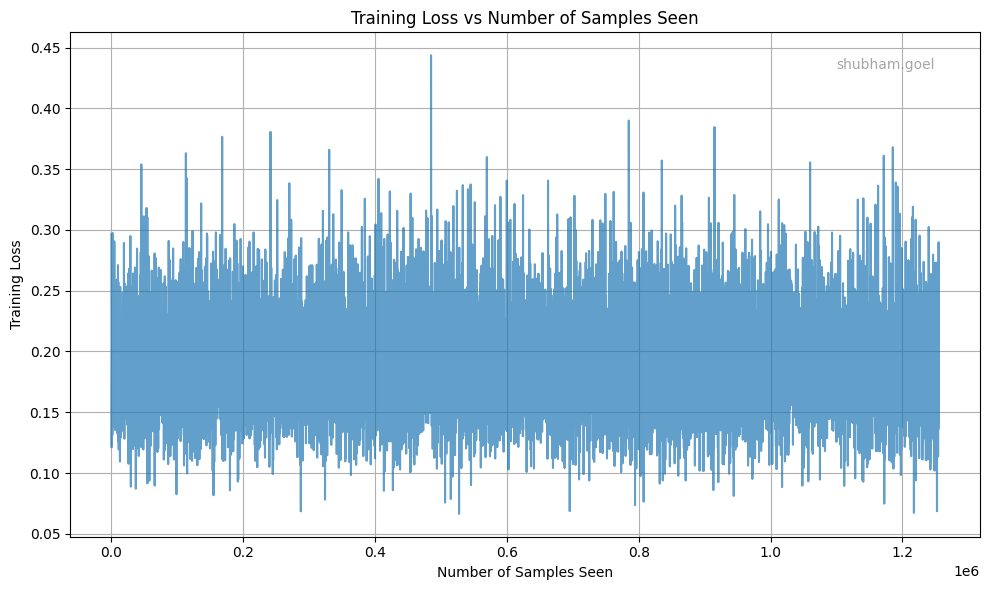

Results saved to runs/border/batch_128_gradacc_2/
Model accuracy: 91.84%


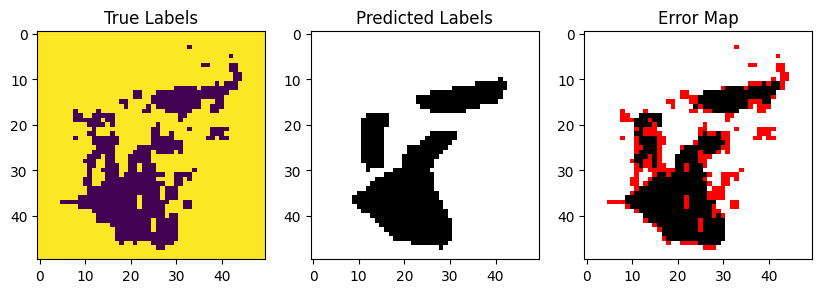

Time taken: 2.34 seconds
train_loss: 0.19056740467892513, accuracy: 91.84%
Running with batch size 128 and grad accumulation 2 and learning rate 0.1
Model created with 105 parameters.
Starting training: border/batch_128_gradacc_2
Early stopping at epoch 501
Training completed: 502 epochs, 1255000 samples
Final loss: 0.190577


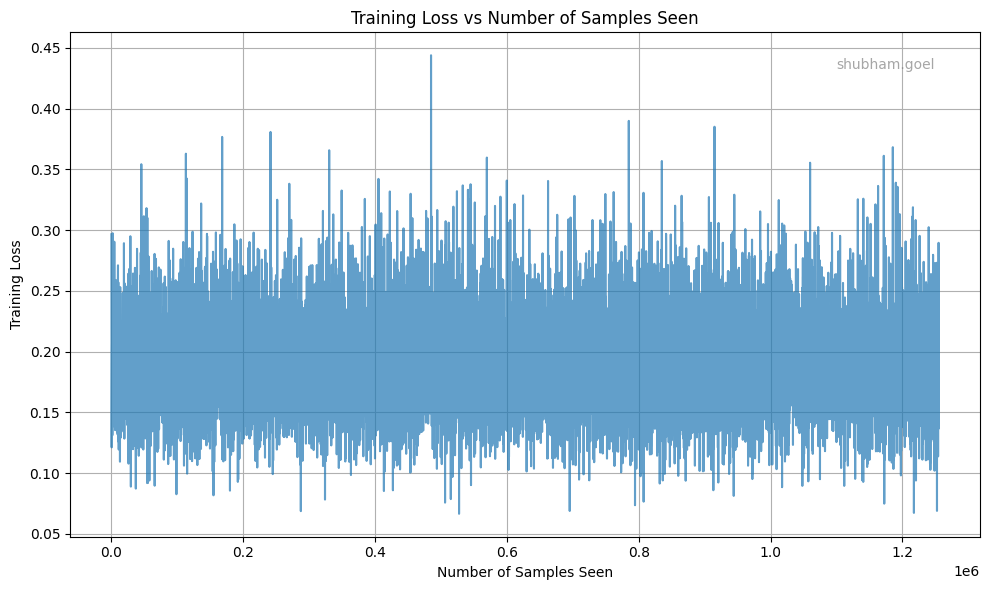

Results saved to runs/border/batch_128_gradacc_2/
Model accuracy: 91.84%


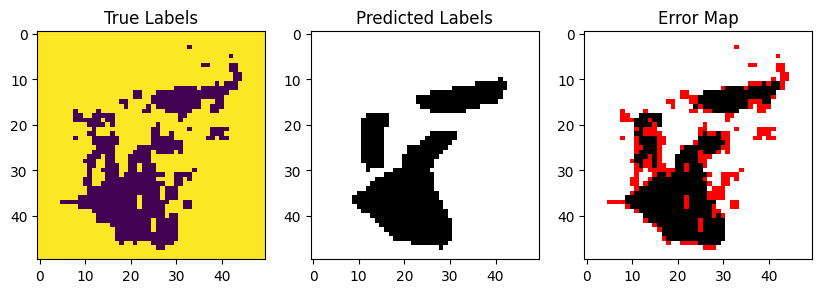

Time taken: 2.83 seconds
train_loss: 0.19057678335120332, accuracy: 91.84%
Running with batch size 128 and grad accumulation 2 and learning rate 0.5
Model created with 105 parameters.
Starting training: border/batch_128_gradacc_2
Early stopping at epoch 501
Training completed: 502 epochs, 1255000 samples
Final loss: 0.190569


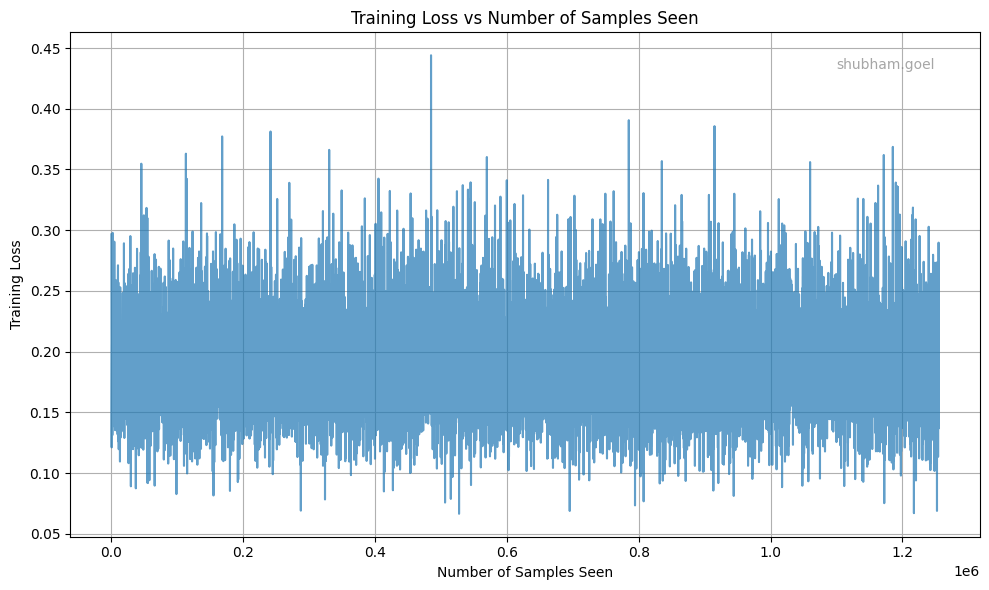

Results saved to runs/border/batch_128_gradacc_2/
Model accuracy: 91.84%


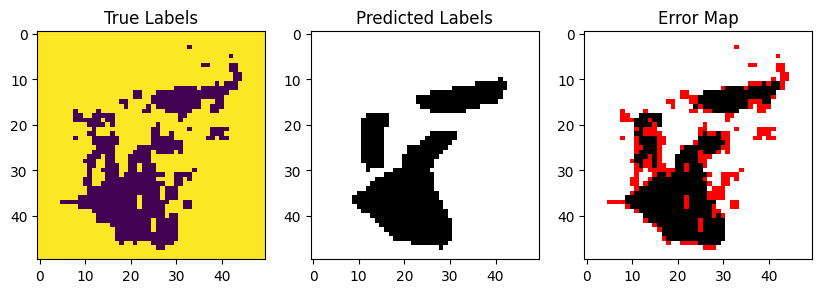

Time taken: 2.32 seconds
train_loss: 0.1905688611798308, accuracy: 91.84%
Running with batch size 128 and grad accumulation 4 and learning rate 0.01
Model created with 105 parameters.
Starting training: border/batch_128_gradacc_4
Early stopping at epoch 501
Training completed: 502 epochs, 1255000 samples
Final loss: 0.190492


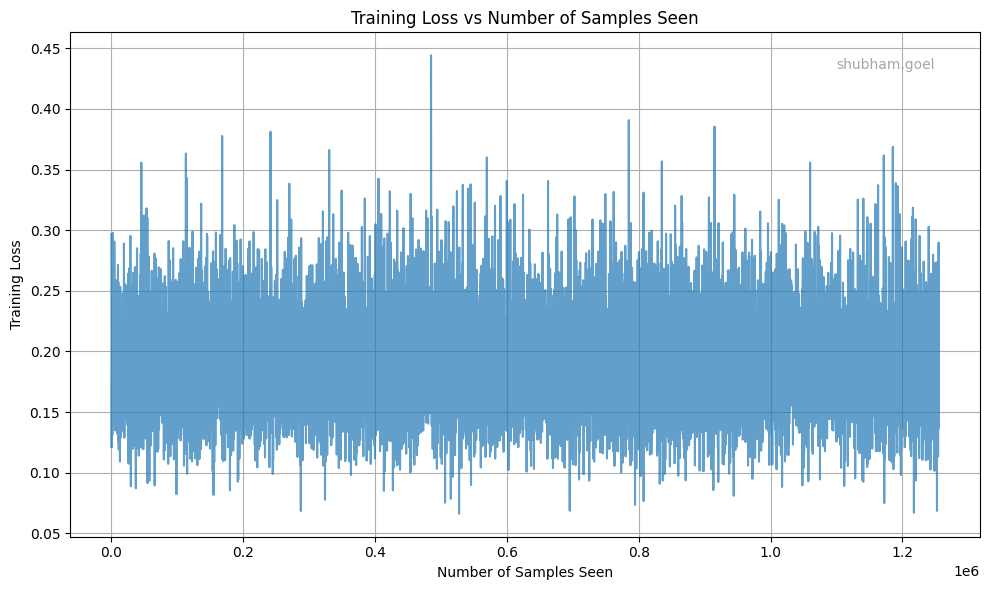

Results saved to runs/border/batch_128_gradacc_4/
Model accuracy: 91.84%


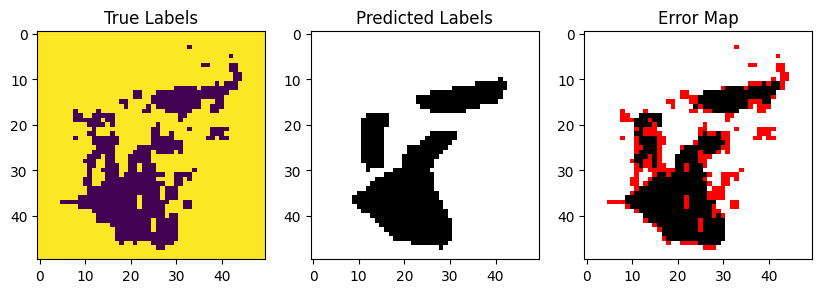

Time taken: 2.44 seconds
train_loss: 0.19049151854133867, accuracy: 91.84%
Running with batch size 128 and grad accumulation 4 and learning rate 0.1
Model created with 105 parameters.
Starting training: border/batch_128_gradacc_4
Early stopping at epoch 501
Training completed: 502 epochs, 1255000 samples
Final loss: 0.190495


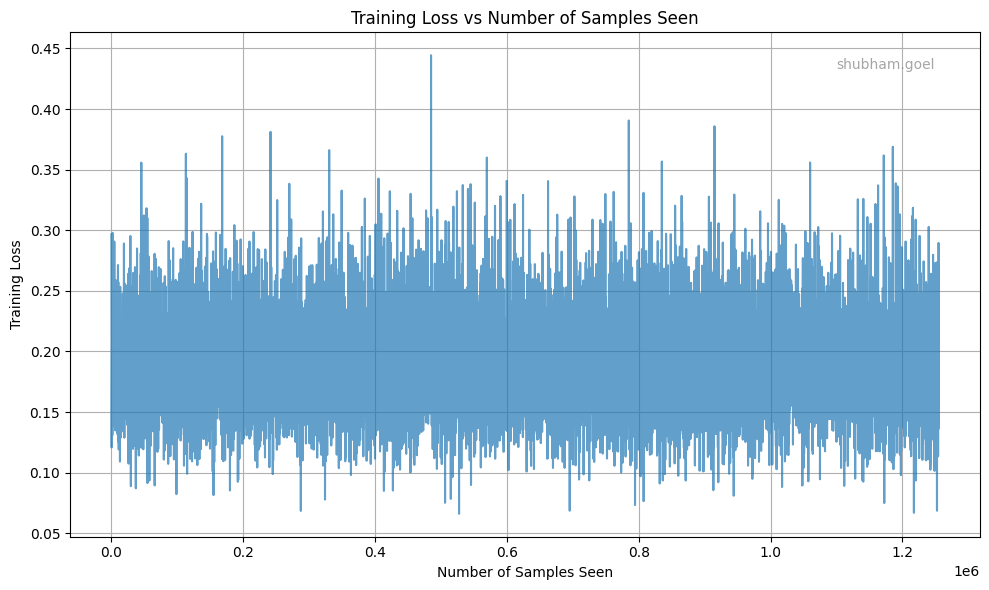

Results saved to runs/border/batch_128_gradacc_4/
Model accuracy: 91.84%


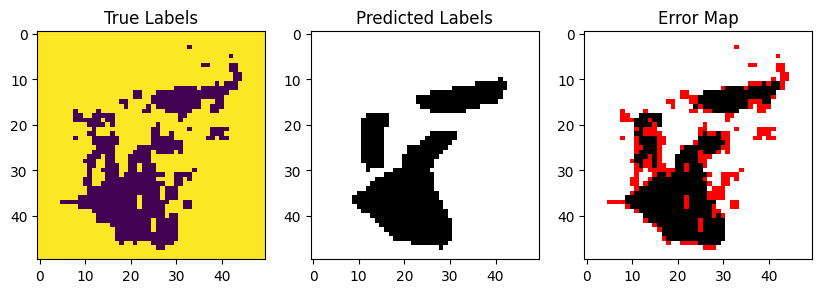

Time taken: 2.35 seconds
train_loss: 0.19049468877727577, accuracy: 91.84%
Running with batch size 128 and grad accumulation 4 and learning rate 0.5
Model created with 105 parameters.
Starting training: border/batch_128_gradacc_4
Early stopping at epoch 501
Training completed: 502 epochs, 1255000 samples
Final loss: 0.190493


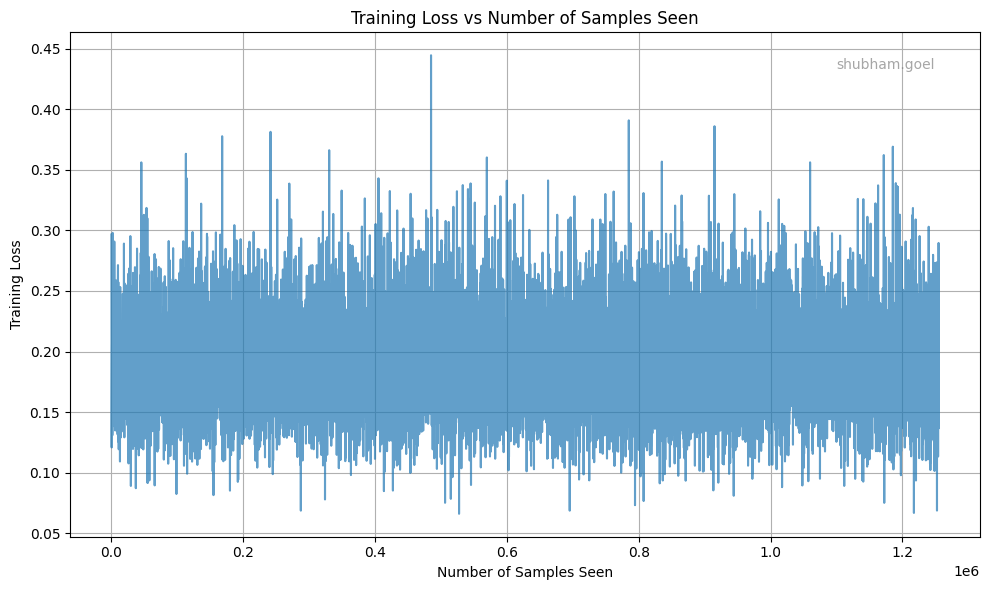

Results saved to runs/border/batch_128_gradacc_4/
Model accuracy: 91.84%


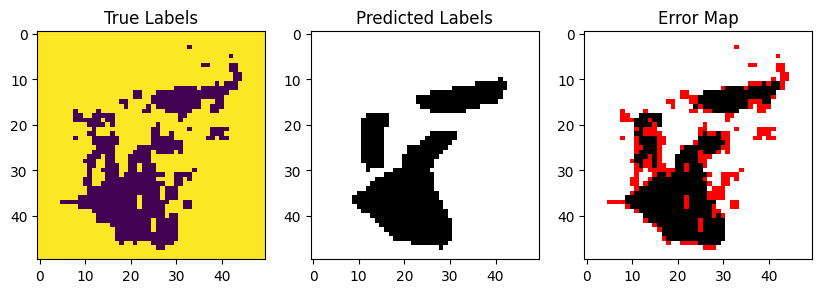

Time taken: 2.38 seconds
train_loss: 0.1904927094016159, accuracy: 91.84%
Running with batch size 128 and grad accumulation 8 and learning rate 0.01
Model created with 105 parameters.
Starting training: border/batch_128_gradacc_8
Early stopping at epoch 501
Training completed: 502 epochs, 1255000 samples
Final loss: 0.190460


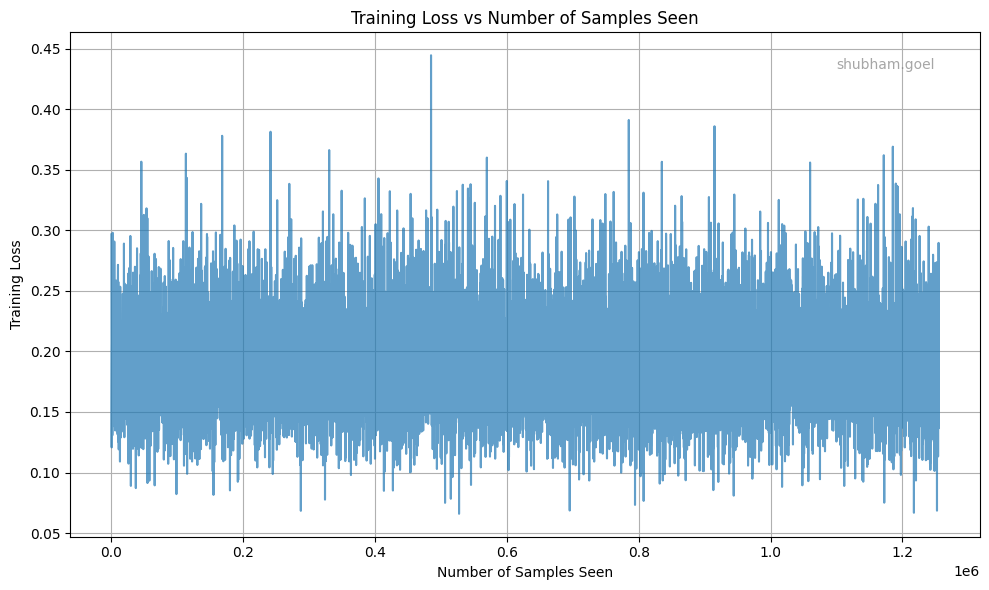

Results saved to runs/border/batch_128_gradacc_8/
Model accuracy: 91.84%


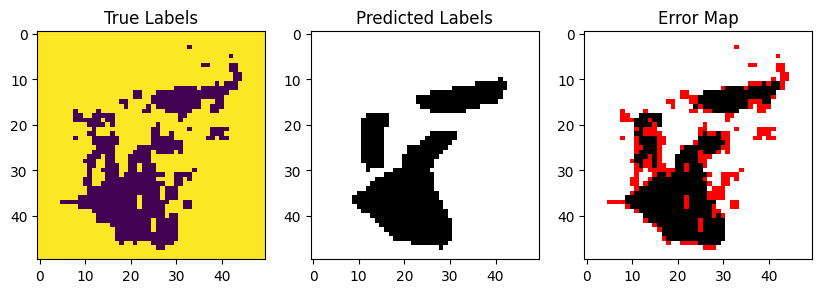

Time taken: 2.28 seconds
train_loss: 0.19046034705288126, accuracy: 91.84%
Running with batch size 128 and grad accumulation 8 and learning rate 0.1
Model created with 105 parameters.
Starting training: border/batch_128_gradacc_8
Early stopping at epoch 501
Training completed: 502 epochs, 1255000 samples
Final loss: 0.190460


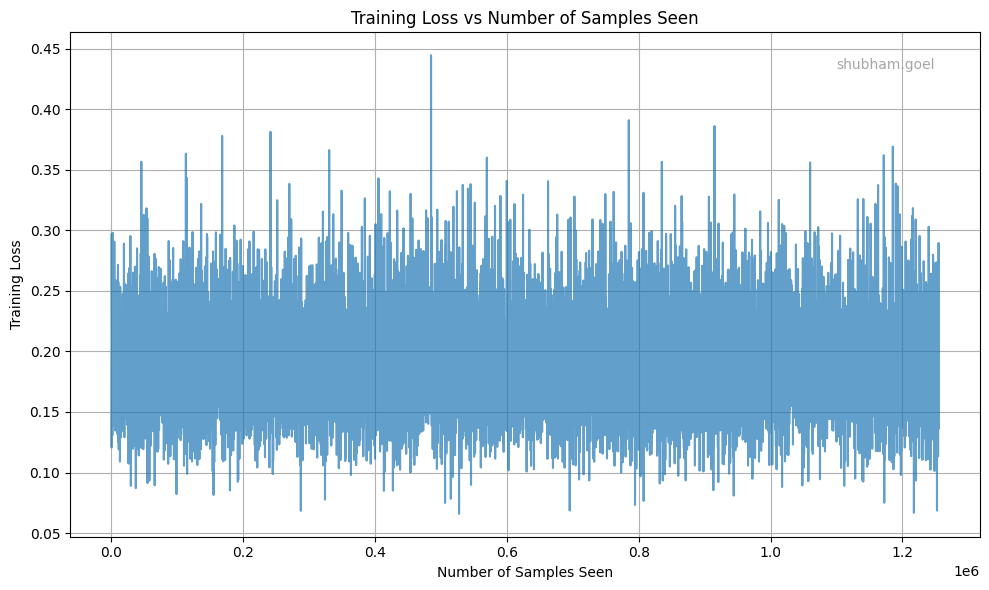

Results saved to runs/border/batch_128_gradacc_8/
Model accuracy: 91.84%


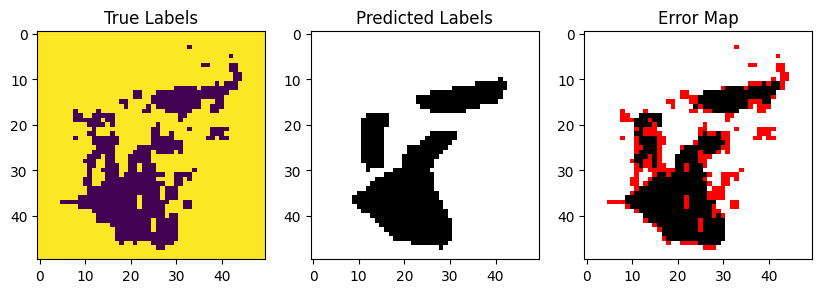

Time taken: 2.38 seconds
train_loss: 0.19046005745644057, accuracy: 91.84%
Running with batch size 128 and grad accumulation 8 and learning rate 0.5
Model created with 105 parameters.
Starting training: border/batch_128_gradacc_8
Early stopping at epoch 501
Training completed: 502 epochs, 1255000 samples
Final loss: 0.190458


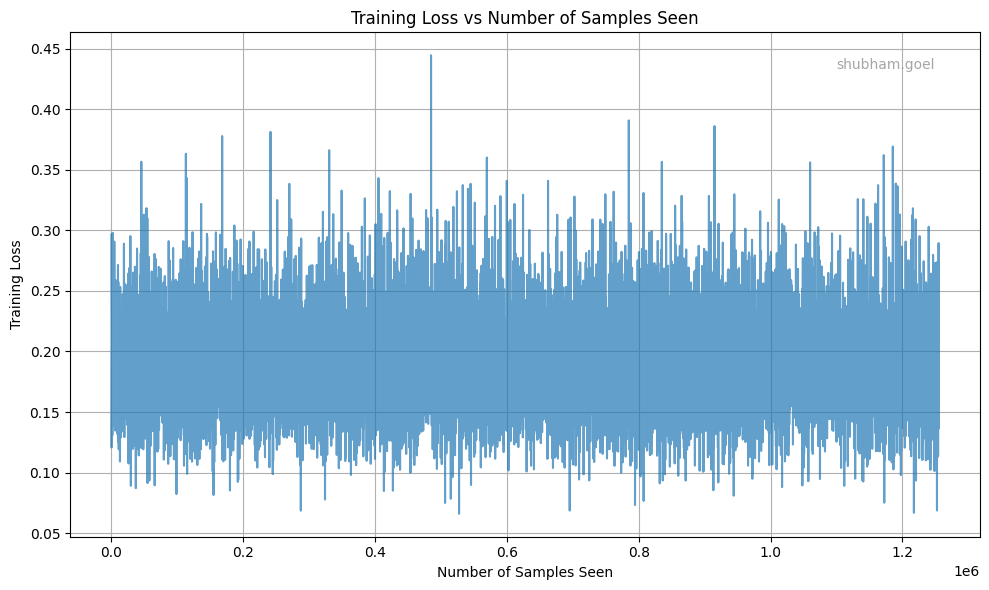

Results saved to runs/border/batch_128_gradacc_8/
Model accuracy: 91.84%


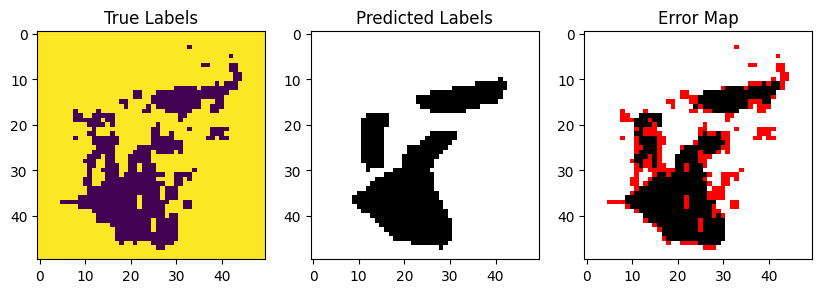

Time taken: 2.27 seconds
train_loss: 0.19045762359716906, accuracy: 91.84%


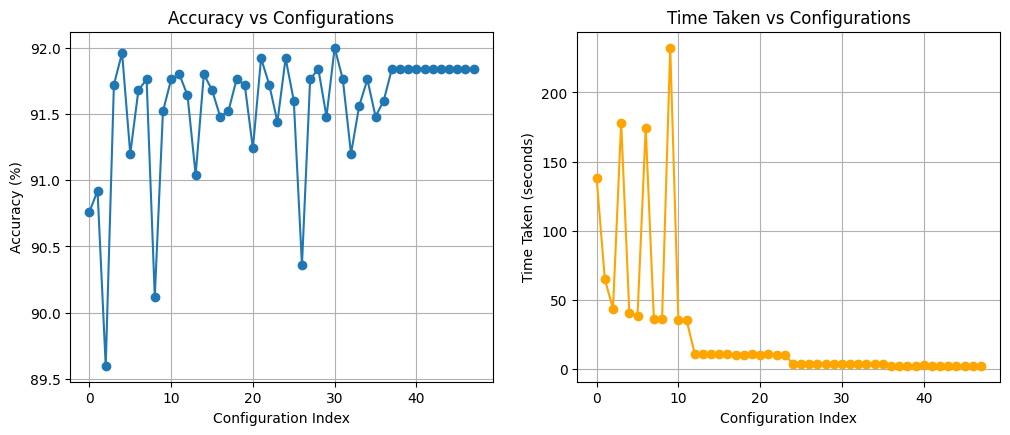

In [8]:
import time
layers = [
    Linear(input_size=2, output_size=8, activation_function=ReLU(), learning_rate=0.01),
    Linear(input_size=8, output_size=8, activation_function =ReLU(), learning_rate=0.01),
    Linear(input_size=8, output_size=1, activation_function=Sigmoid(), learning_rate=0.01)
]

model = Model(layers, BCELoss())

BATCH_SIZES = [4, 16, 64, 128]
GRAD_ACCUMULATION_STEPS = [1, 2, 4, 8]
LEARNING_RATES = [0.01, 0.1 , 0.5]

accuracy_results = []
train_losses = []
samples_seen = []
time_list = []

for batch_size in BATCH_SIZES:
    for grad_accumulation in GRAD_ACCUMULATION_STEPS:
        for learning_rate in LEARNING_RATES:
            print(f"Running with batch size {batch_size} and grad accumulation {grad_accumulation} and learning rate {learning_rate}")
            time_start = time.time()
            result = run_model_on_border(
                layers=layers,
                loss_fn=BCELoss(),
                learning_rate=learning_rate,
                max_epochs=10000,
                mask=mask,
                batch_size=batch_size,
                patience=500,
                rel_loss_threshold=1e-6,
                run_name=f"border/batch_{batch_size}_gradacc_{grad_accumulation}",
                save_model=True,
                learning_rate_=0.01,
                grad_step=grad_accumulation
            )
            time_end = time.time()
            time_taken = time_end - time_start
            print(f"Time taken: {time_taken:.2f} seconds")
            print(f"train_loss: {result['final_loss']}, accuracy: {result['accuracy']*100:.2f}%")
            accuracy_results.append(result['accuracy'] * 100)
            train_losses.append(result['final_loss'])
            samples_seen.append(result['samples_seen'])
            time_list.append(time_taken)

# Plotting accuracy and training loss vs batch size and grad accumulation steps
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.plot(range(len(accuracy_results)), accuracy_results, marker='o')
plt.title("Accuracy vs Configurations")
plt.xlabel("Configuration Index")
plt.ylabel("Accuracy (%)")
plt.grid()  

#plotting time taken and samples seen vs batch size and grad accumulation steps
plt.subplot(2, 2, 2)
plt.plot(range(len(time_list)), time_list, marker='o', color='orange')
plt.title("Time Taken vs Configurations")
plt.xlabel("Configuration Index")
plt.ylabel("Time Taken (seconds)")
plt.grid()  


## Final Challenge


## Minimize Model Size

params =  105

When i was doing the EXPERIMENT WITH ARCHITECTURE PART (fixed width , vary number of layers)
i observed that:
with 2 layers and width = 8 
i was able to achieve an accuracy of 91.32 % 

so i did hyperparameter tuning on this architecture and achieved  a best accuracy of 91.44 %
batch_size = 64
grad_accumulation_step = 4

## Minimize Training Samples.

In [3]:
class BorderSubSetDataset:
    def __init__(self, binary_mask, subset_ratio=1.0):
        self.binary_mask = binary_mask
        self.height, self.width = binary_mask.shape
        y_coords, x_coords = np.indices((self.height, self.width))
        self.x_normalized = x_coords.flatten() / (self.width - 1)
        self.y_normalized = y_coords.flatten() / (self.height - 1)
        self.labels = binary_mask.flatten()
        self.indices = np.arange(len(self.labels))
        # Get subset size
        self.subset_size = int(len(self.indices) * subset_ratio)
        self.shuffle()  # Initialize with shuffled indices

        # Get distribution of labels in the subset
        self.subset_labels = self.labels[self.subset_indices]
        self.label_counts = {
            0: np.sum(self.subset_labels == 0),
            1: np.sum(self.subset_labels == 1)
        }
        self.label_distribution = {
            0: self.label_counts[0] / len(self.subset_labels),
            1: self.label_counts[1] / len(self.subset_labels)
        }

    def print_distribution(self):
        """Print the distribution of labels in the subset"""
        print(f"Subset size: {self.subset_size} samples")
        print(f"Label counts:")
        print(f"  Class 0 (Belgium): {self.label_counts[0]} samples ({self.label_distribution[0]*100:.2f}%)")
        print(f"  Class 1 (Netherlands): {self.label_counts[1]} samples ({self.label_distribution[1]*100:.2f}%)")
        
    def get_distribution(self):
        """Return the distribution statistics as a dictionary"""
        return {
            "subset_size": self.subset_size,
            "label_counts": self.label_counts,
            "label_distribution": self.label_distribution
        }

    def shuffle(self):
        """Shuffle the dataset and select subset"""
        np.random.seed(42)
        np.random.shuffle(self.indices)
        # Select subset after shuffling
        self.subset_indices = self.indices[:self.subset_size]
        
    def get_all_samples(self):
        """Get training subset of data"""
        coordinates = np.column_stack([
            self.x_normalized[self.subset_indices],
            self.y_normalized[self.subset_indices]
        ])
        labels = self.labels[self.subset_indices]
        return coordinates, labels

    def get_full_samples(self):
        """Get all data points for evaluation"""
        coordinates = np.column_stack([
            self.x_normalized[self.indices],
            self.y_normalized[self.indices]
        ])
        labels = self.labels[self.indices]
        return coordinates, labels

    def reconstruct_image_from_predictions(self, shuffled_predictions):
        reconstructed = np.zeros(self.height * self.width)
        reconstructed[self.indices] = shuffled_predictions.flatten()
        return reconstructed.reshape(self.height, self.width)

In [6]:
def run_model_on__subset_border(layers , loss_fn , learning_rate=0.01 , max_epochs=1000 , mask=mask , batch_size=4 ,patience=100,run_name="sample_run",save_model=True,rel_loss_threshold=1e-6,learning_rate_=0.01 , subset_ratio=0.1,grad_accumulation=1):
    """
    Create and train the model with given layers and loss function.
    """
    for layer in layers:
        layer.learning_rate = learning_rate
        
    model = Model(layers, loss_fn)
    print(f"Model created with {model.get_parameter_count()} parameters.")
    dataset = BorderSubSetDataset(mask,subset_ratio=subset_ratio)
    dataset.print_distribution()

    results = train_model(
        model=model,
        dataset=dataset,
        batch_size=batch_size,
        max_epochs=max_epochs,
        patience=patience,
        save_model=save_model,
        run_name=run_name,
        relative_loss_threshold=rel_loss_threshold,
        use_wandb=False,
        grad_accumulation_steps=grad_accumulation
    )

    X,Y = dataset.get_full_samples()
    predictions = model.predict(X)
    threshold = 0.5  
    predicted_labels = (predictions > threshold).astype(int).flatten()

    true_labels = Y.flatten()

    # the ground truth map
    true_map = dataset.reconstruct_image_from_predictions(true_labels)

    # map generated from model predictions
    pred_map = dataset.reconstruct_image_from_predictions(predicted_labels)

    error_map = dataset.reconstruct_image_from_predictions((true_labels != predicted_labels).astype(int))

    # Error map
    height, width = dataset.height, dataset.width
    error_overlay = np.zeros((height, width, 3))
    error_overlay[:,:,0] = true_map  # Red channel = ground truth
    error_overlay[:,:,1] = true_map  # Green channel = ground truth  
    error_overlay[:,:,2] = true_map  # Blue channel = ground truth
    

    
    # Highlight errors in bright red
    error_overlay[error_map == 1] = [1, 0, 0]  # Bright red for errors

    check = (true_map == pred_map).astype(int)
    accuracy = np.sum(check) / check.size
    print(f"Model accuracy: {accuracy * 100:.2f}%")

    fig , axes = plt.subplots(1,3,figsize=(10,5))
    axes[0].imshow(true_map)     
    axes[0].set_title("True Labels")    
    axes[1].imshow(pred_map,cmap='gray')
    axes[1].set_title("Predicted Labels")
    axes[2].imshow(error_overlay)
    axes[2].set_title("Error Map")
    plt.show()
    # save the following images side-by-side in a single plot within the run folder
    fig.savefig(f"runs/{run_name}/results.png")

    return {
        "accuracy": accuracy,
        "final_loss": results['final_loss'],
        "samples_seen" :results['samples_seen'],
    }

Running architecture with subset ratio 0.1
Model created with 105 parameters.
Subset size: 250 samples
Label counts:
  Class 0 (Belgium): 56 samples (22.40%)
  Class 1 (Netherlands): 194 samples (77.60%)
Starting training: border/subset_ratio_0.1
Training completed: 10000 epochs, 2500000 samples
Final loss: 0.247810


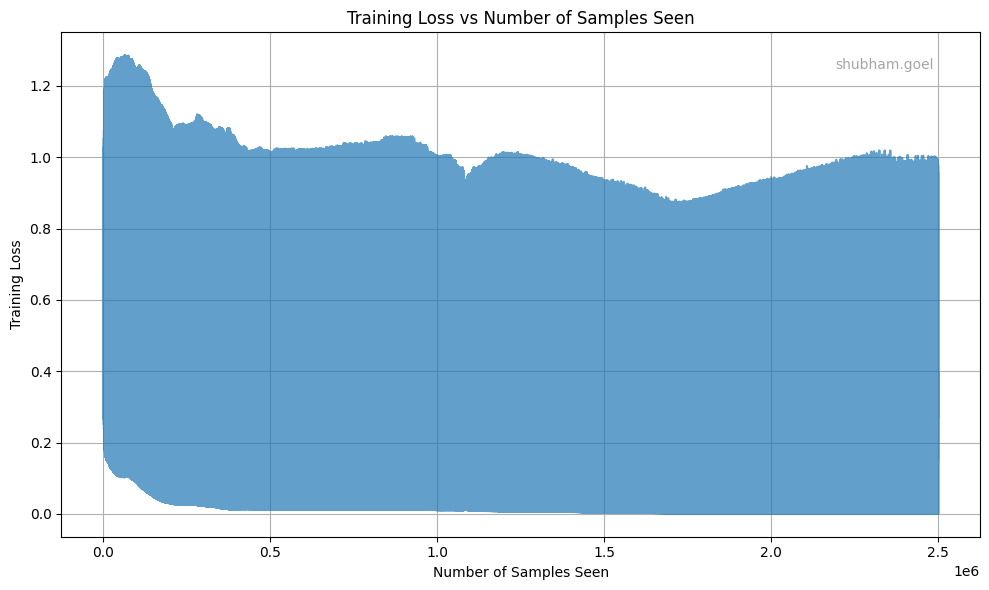

Results saved to runs/border/subset_ratio_0.1/
Model accuracy: 86.00%


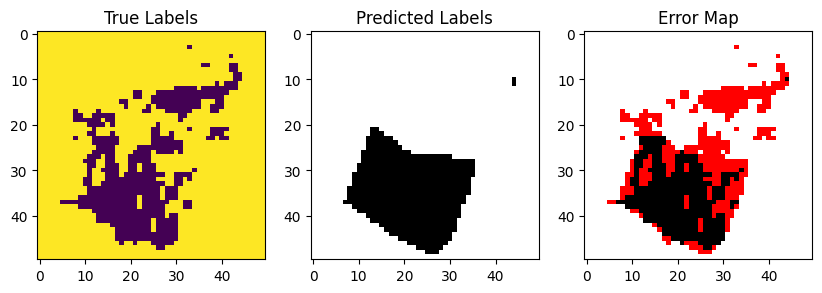

Running architecture with subset ratio 0.2
Model created with 105 parameters.
Subset size: 500 samples
Label counts:
  Class 0 (Belgium): 106 samples (21.20%)
  Class 1 (Netherlands): 394 samples (78.80%)
Starting training: border/subset_ratio_0.2
Early stopping at epoch 5143
Training completed: 5144 epochs, 2572000 samples
Final loss: 0.245078


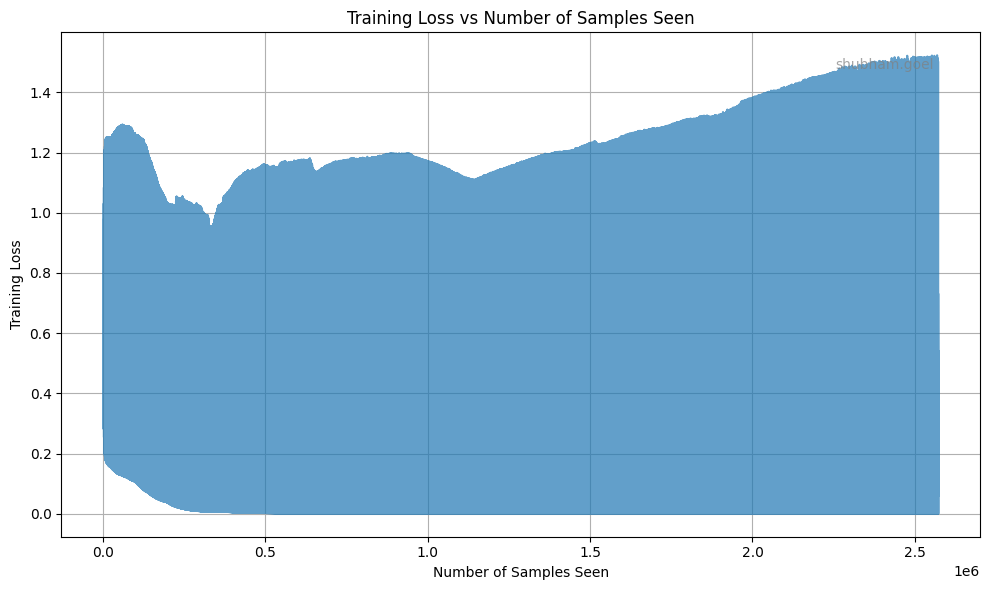

Results saved to runs/border/subset_ratio_0.2/
Model accuracy: 88.20%


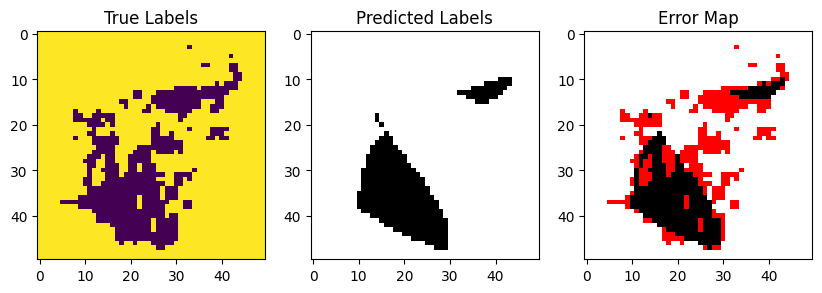

Running architecture with subset ratio 0.3
Model created with 105 parameters.
Subset size: 750 samples
Label counts:
  Class 0 (Belgium): 159 samples (21.20%)
  Class 1 (Netherlands): 591 samples (78.80%)
Starting training: border/subset_ratio_0.3
Early stopping at epoch 3946
Training completed: 3947 epochs, 2960250 samples
Final loss: 0.226295


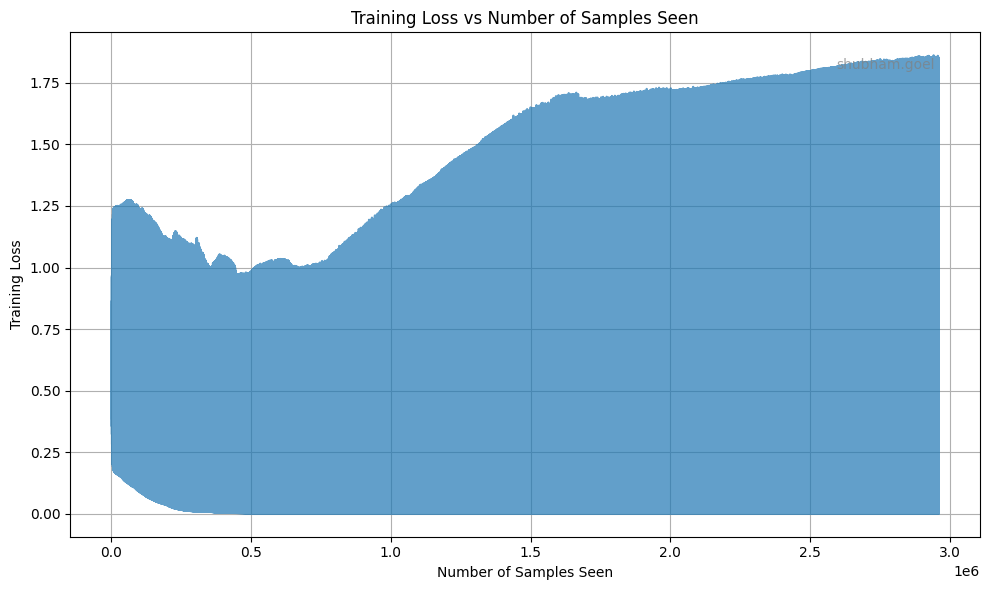

Results saved to runs/border/subset_ratio_0.3/
Model accuracy: 89.52%


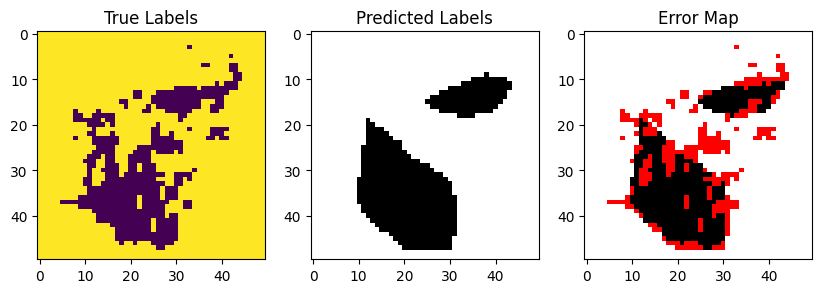

Running architecture with subset ratio 0.4
Model created with 105 parameters.
Subset size: 1000 samples
Label counts:
  Class 0 (Belgium): 211 samples (21.10%)
  Class 1 (Netherlands): 789 samples (78.90%)
Starting training: border/subset_ratio_0.4
Early stopping at epoch 6772
Training completed: 6773 epochs, 6773000 samples
Final loss: 0.217965


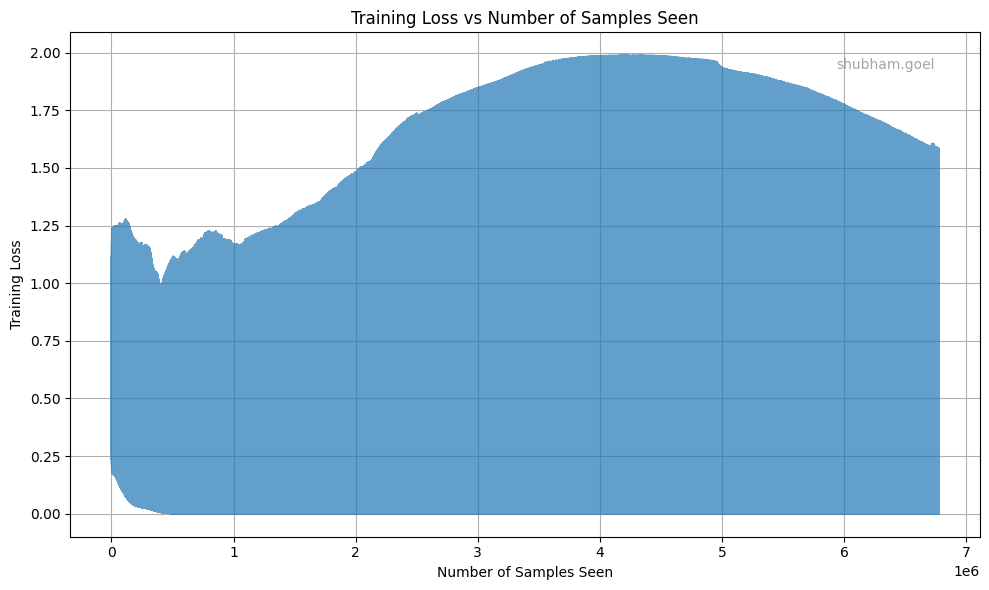

Results saved to runs/border/subset_ratio_0.4/
Model accuracy: 89.40%


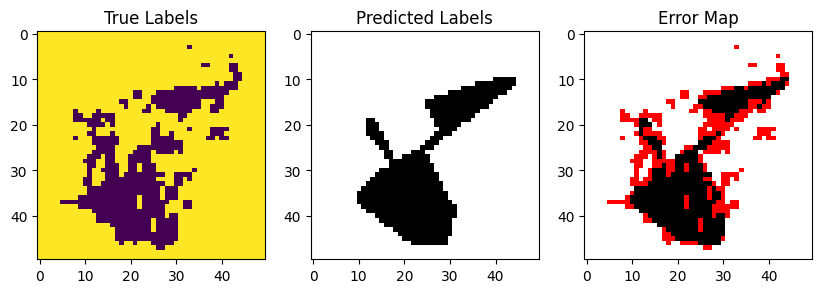

Running architecture with subset ratio 0.5
Model created with 105 parameters.
Subset size: 1250 samples
Label counts:
  Class 0 (Belgium): 264 samples (21.12%)
  Class 1 (Netherlands): 986 samples (78.88%)
Starting training: border/subset_ratio_0.5
Early stopping at epoch 2627
Training completed: 2628 epochs, 3285000 samples
Final loss: 0.232696


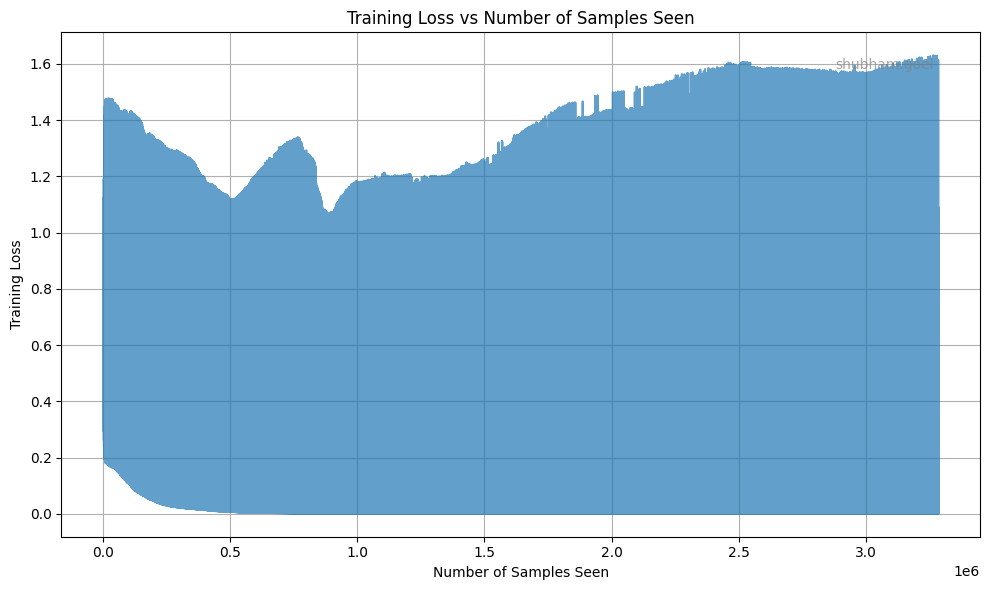

Results saved to runs/border/subset_ratio_0.5/
Model accuracy: 88.68%


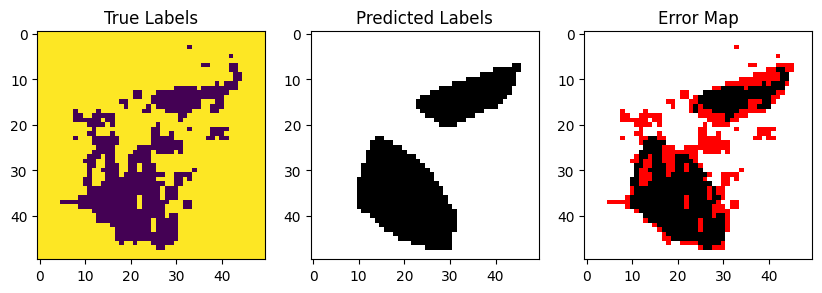

Running architecture with subset ratio 0.6
Model created with 105 parameters.
Subset size: 1500 samples
Label counts:
  Class 0 (Belgium): 320 samples (21.33%)
  Class 1 (Netherlands): 1180 samples (78.67%)
Starting training: border/subset_ratio_0.6
Early stopping at epoch 5987
Training completed: 5988 epochs, 8982000 samples
Final loss: 0.202808


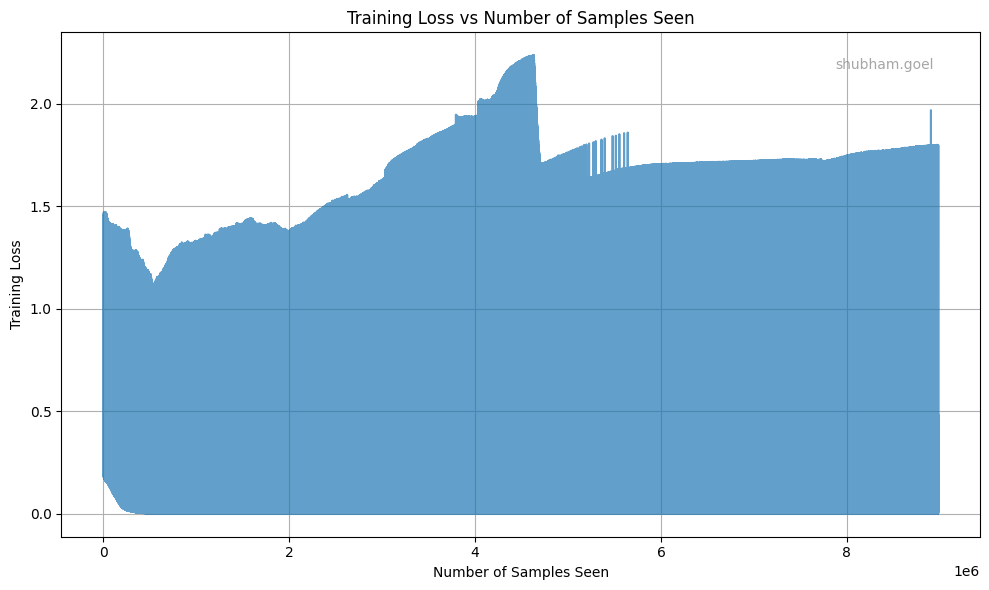

Results saved to runs/border/subset_ratio_0.6/
Model accuracy: 90.68%


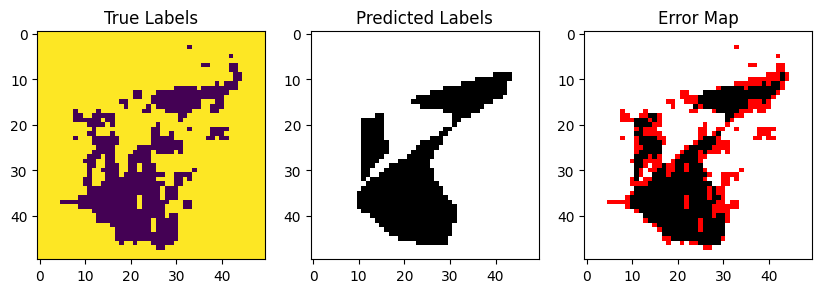

Running architecture with subset ratio 0.7
Model created with 105 parameters.
Subset size: 1750 samples
Label counts:
  Class 0 (Belgium): 368 samples (21.03%)
  Class 1 (Netherlands): 1382 samples (78.97%)
Starting training: border/subset_ratio_0.7
Early stopping at epoch 4051
Training completed: 4052 epochs, 7091000 samples
Final loss: 0.206750


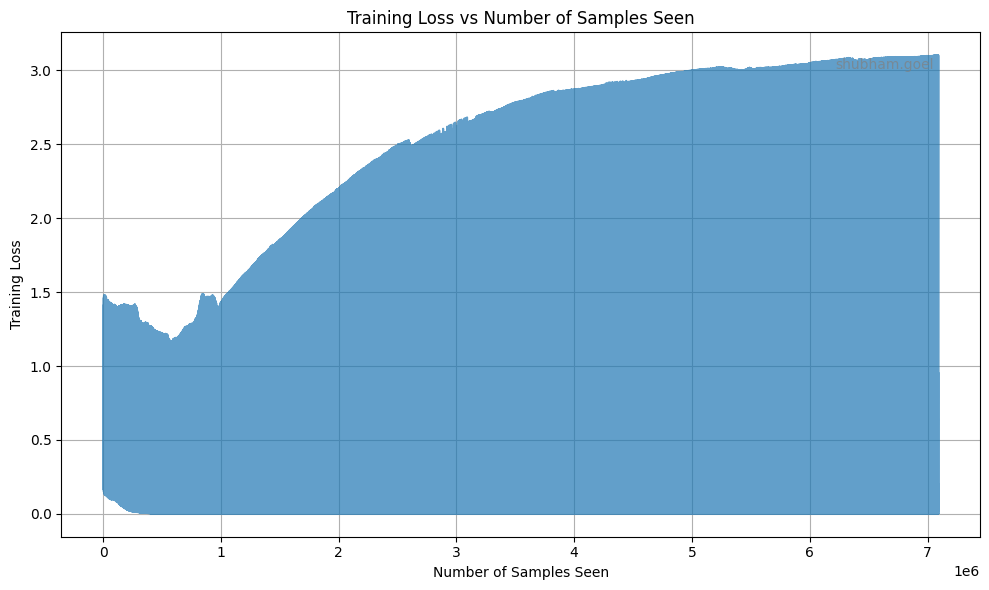

Results saved to runs/border/subset_ratio_0.7/
Model accuracy: 90.52%


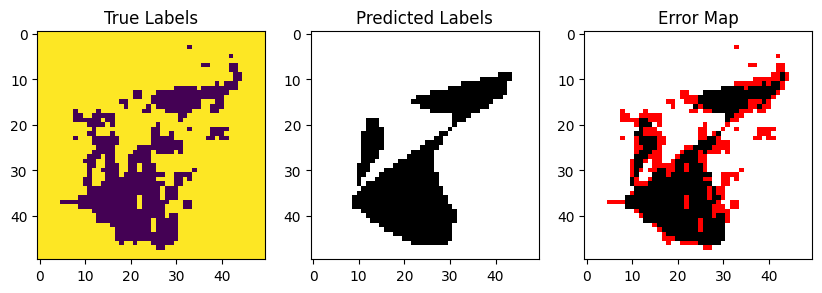

Running architecture with subset ratio 0.8
Model created with 105 parameters.
Subset size: 2000 samples
Label counts:
  Class 0 (Belgium): 420 samples (21.00%)
  Class 1 (Netherlands): 1580 samples (79.00%)
Starting training: border/subset_ratio_0.8
Early stopping at epoch 6409
Training completed: 6410 epochs, 12820000 samples
Final loss: 0.226933


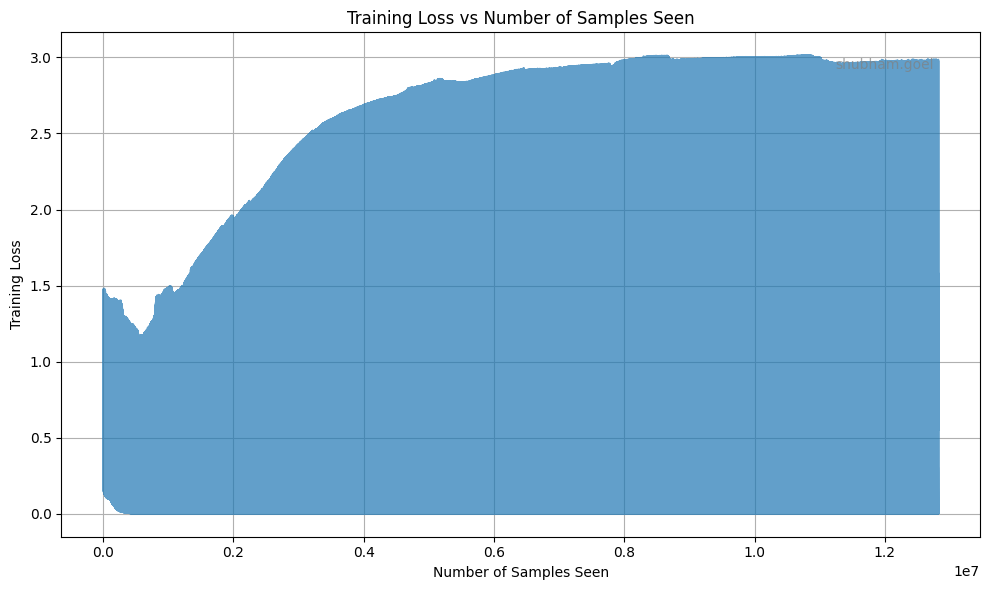

Results saved to runs/border/subset_ratio_0.8/
Model accuracy: 89.08%


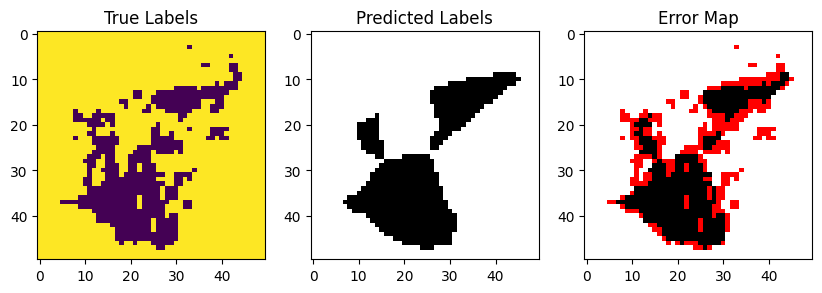

Running architecture with subset ratio 0.9
Model created with 105 parameters.
Subset size: 2250 samples
Label counts:
  Class 0 (Belgium): 476 samples (21.16%)
  Class 1 (Netherlands): 1774 samples (78.84%)
Starting training: border/subset_ratio_0.9


In [ ]:
ratios = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

for ratio in ratios:
    layers = []
    # Input layer
    layers.append(Linear(input_size=2, output_size=8, activation_function=ReLU(), learning_rate=0.01))
    
    # Hidden layers
    for _ in range(2 - 1):
        layers.append(Linear(input_size=8, output_size=8, activation_function=ReLU(), learning_rate=0.01))
    
    # Output layer
    layers.append(Linear(input_size=8, output_size=1, activation_function=Sigmoid(), learning_rate=0.01))
    
    print(f"Running architecture with subset ratio {ratio}")
    
    result = run_model_on__subset_border(
        layers=layers,
        loss_fn=BCELoss(),
        learning_rate=0.01,
        max_epochs=10000,
        mask=mask,
        subset_ratio=ratio,
        batch_size=4,
        grad_accumulation=1,
        patience=500,
        rel_loss_threshold=1e-6,
        run_name=f"border/subset_ratio_{ratio}",
        save_model=True
    )